In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Importing necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import layers, models
from skimage.feature import hog, sift
import glob


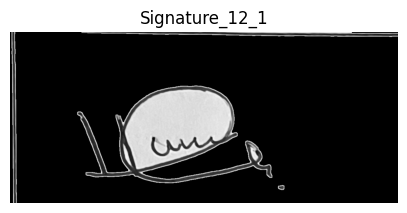

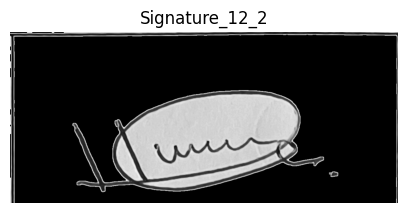

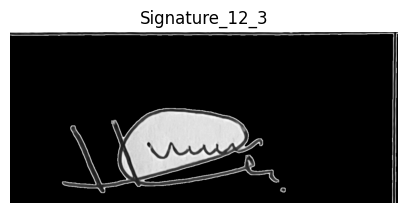

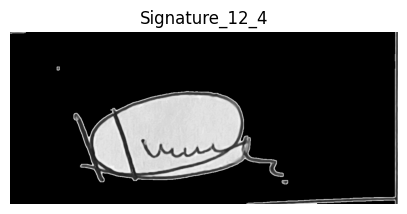

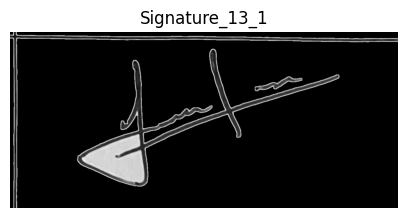

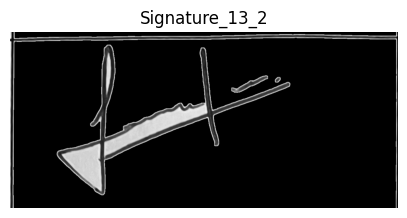

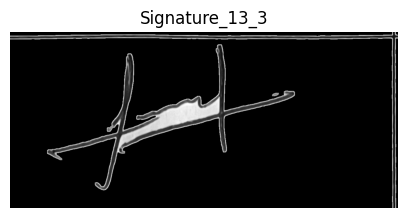

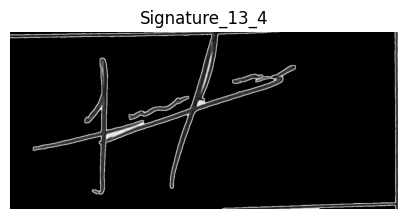

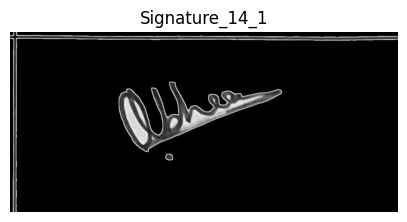

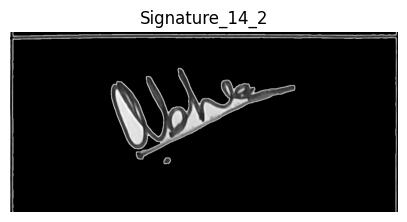

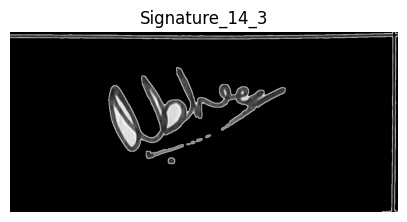

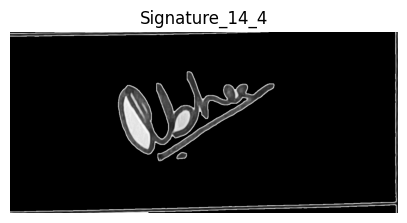

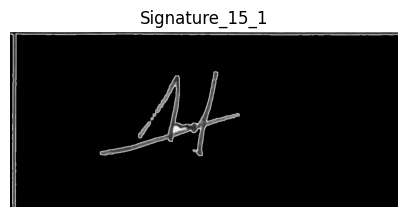

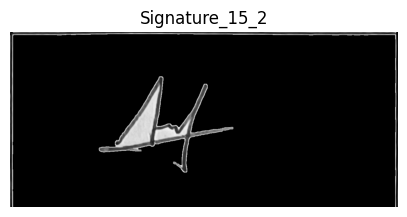

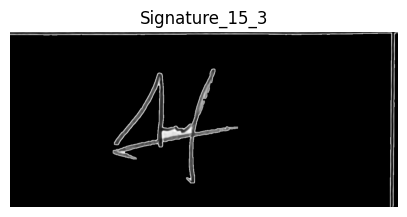

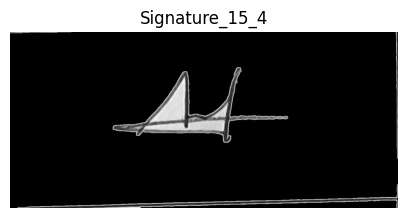

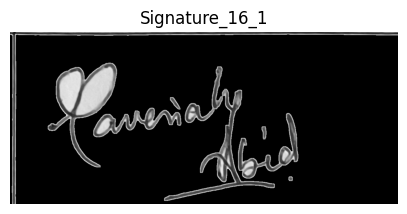

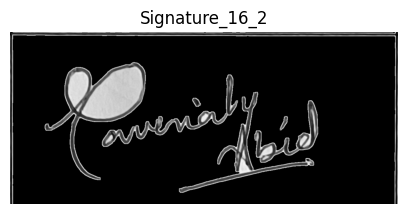

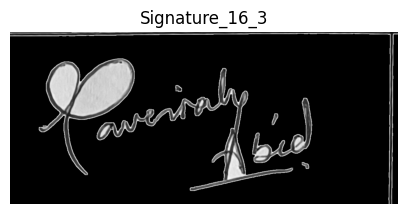

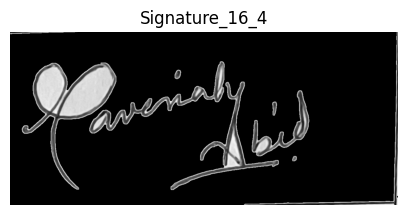

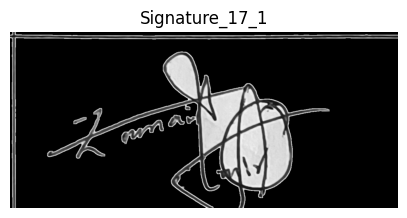

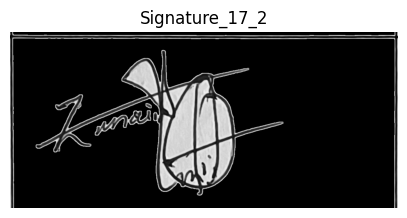

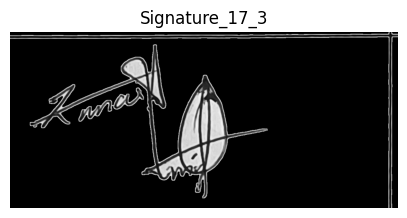

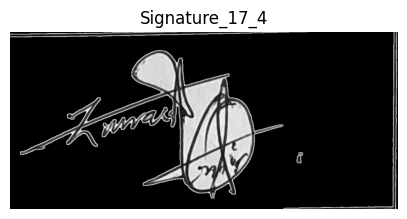

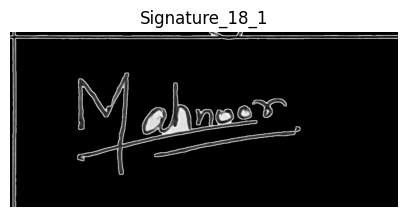

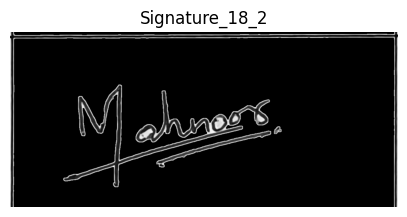

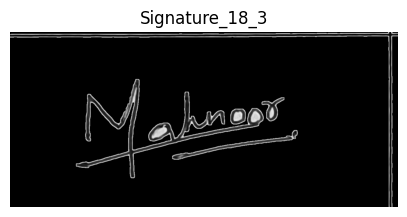

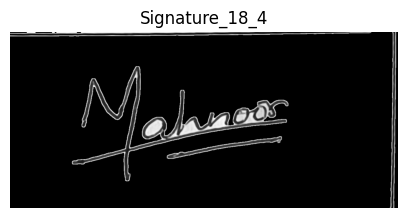

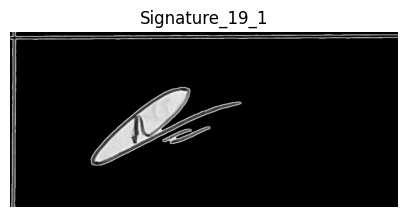

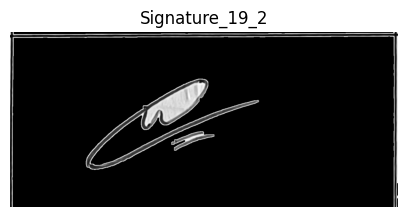

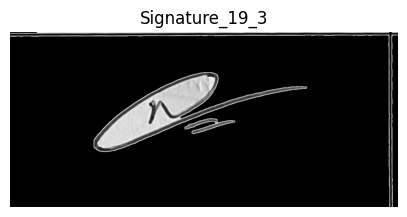

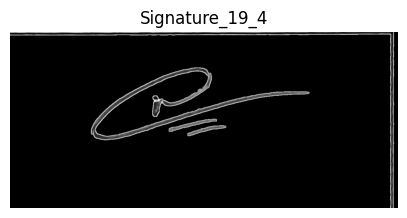

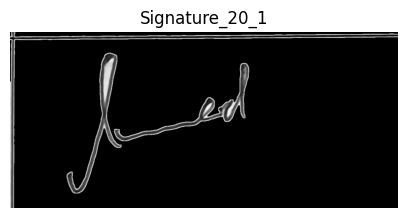

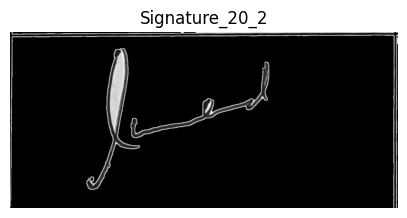

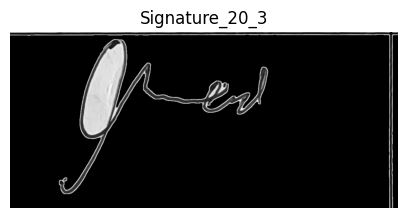

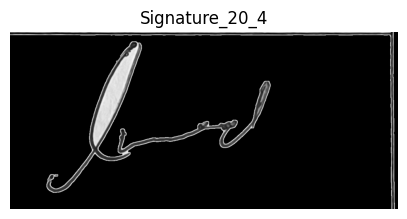

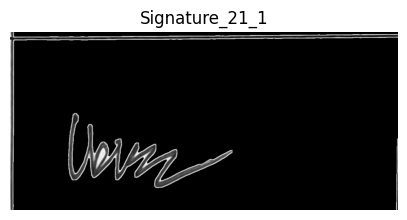

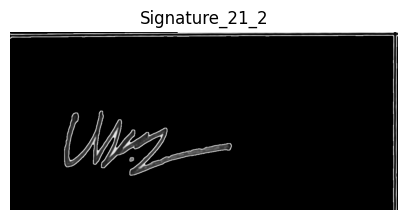

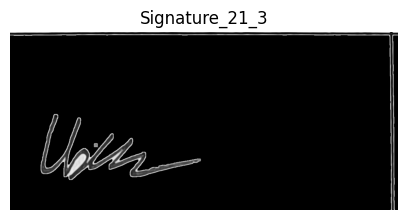

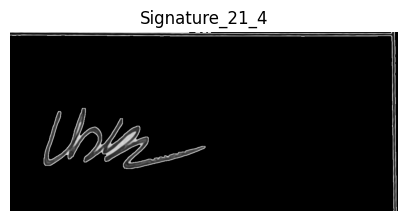

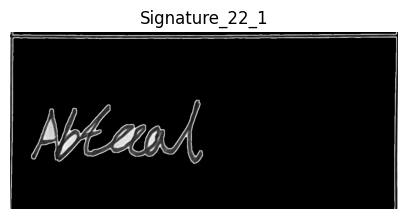

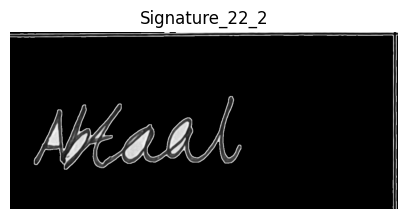

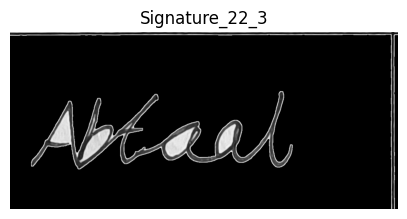

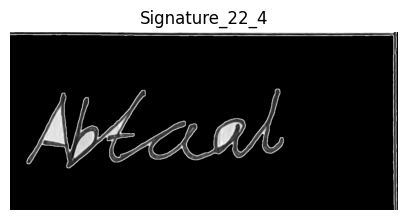

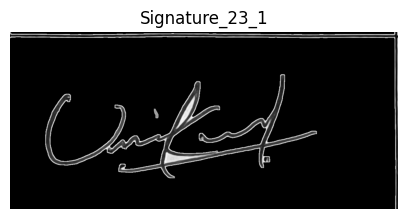

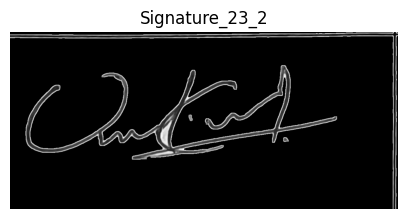

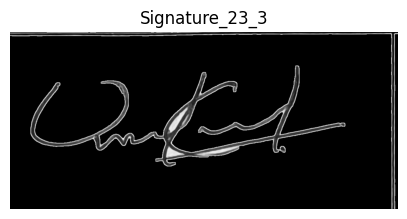

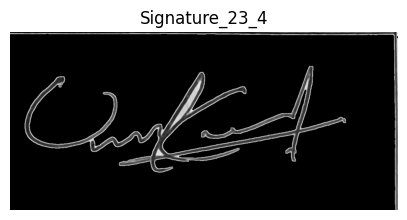

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the uploaded image from the path
input_image_path = "/content/drive/My Drive/Data/1.jpg"  # Use the uploaded image path
image = cv2.imread(input_image_path)

# Step 1: Align the image and crop extra areas
def align_and_crop_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Find contours to detect the document edges
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Get the largest contour which should be the document boundary
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        if len(approx) == 4:  # Looking for a 4-corner contour
            doc_contour = approx
            break

    # Apply perspective transformation to align the document
    pts = doc_contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype="float32")

    # Determine the rectangle coordinates
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # Top-left
    rect[2] = pts[np.argmax(s)]  # Bottom-right

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # Top-right
    rect[3] = pts[np.argmax(diff)]  # Bottom-left

    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype="float32")

    # Perspective transformation matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    aligned_image = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # Crop extra whitespace and a bit more from the top if needed
    aligned_gray = cv2.cvtColor(aligned_image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(aligned_gray, 150, 255, cv2.THRESH_BINARY)
    binary = cv2.bitwise_not(binary)

    # Find bounding box of the main content area
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))

    # Adjust crop area to remove extra from the top
    extra_crop_top = 27  # Adjust this value to crop more from the top
    cropped_image = aligned_image[y + extra_crop_top:y + h, x:x + w]

    return cropped_image

# Step 2: Detect and segment rows (same as before)
def segment_rows(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)

    # Use adaptive thresholding to enhance line visibility
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 15, 5)

    # Apply morphological operations to enhance row lines
    kernel = np.ones((7, 7), np.uint8)
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    edges = cv2.Canny(closed, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect lines with refined parameters
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=250, minLineLength=310, maxLineGap=100)
    horizontal_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Detect horizontal lines with stricter conditions
            if abs(y2 - y1) < abs(x2 - x1) * 0.1 and abs(x2 - x1) > 150:
                horizontal_lines.append(line)

    # Sort lines by their y-coordinates to ensure correct row order
    horizontal_lines = sorted(horizontal_lines, key=lambda line: line[0][1])

    # Merge close horizontal lines to avoid detecting multiple lines for one row
    merged_horizontal_lines = []
    merge_threshold = 90  # Adjusted to merge closely spaced lines better

    for line in horizontal_lines:
        if not merged_horizontal_lines:
            merged_horizontal_lines.append(line)
        else:
            prev_line = merged_horizontal_lines[-1]
            adjusted_merge_threshold = 40 if line[0][1] > 0.85 * image.shape[0] else merge_threshold
            if abs(line[0][1] - prev_line[0][1]) > adjusted_merge_threshold:
                merged_horizontal_lines.append(line)

    # Extract and display rows based on merged horizontal lines
    row_images = []
    for i in range(len(merged_horizontal_lines) - 1):
        y1 = merged_horizontal_lines[i][0][1]
        y2 = merged_horizontal_lines[i + 1][0][1]
        if abs(y2 - y1) > 30:  # Ensure the detected rows have significant height
            row_image = gray[y1:y2, :]
            row_images.append(row_image)
    return row_images

# Step 3: Detect contours in signature and refine
def detect_sign_contour(signature):
    # Apply Gaussian blur to reduce noise
    blurred_signature = cv2.GaussianBlur(signature, (5, 5), 0)

    # Convert to grayscale and apply thresholding
    gray_signature = cv2.cvtColor(blurred_signature, cv2.COLOR_BGR2GRAY) if len(blurred_signature.shape) == 3 else blurred_signature
    _, binary = cv2.threshold(gray_signature, 120, 255, cv2.THRESH_BINARY_INV)

    # Apply morphological operations to clean up the image
    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.dilate(binary, kernel, iterations=2)
    binary = cv2.erode(binary, kernel, iterations=1)

    # Find contours with hierarchy
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filter valid contours
    valid_contours = [c for c in contours if cv2.contourArea(c) > 100]

    # Create a mask to draw the filtered contours
    mask = np.zeros_like(gray_signature)

    for contour in valid_contours:
        cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)

    # Apply the mask to the original signature
    refined_signature = cv2.bitwise_and(signature, signature, mask=mask)

    return refined_signature

# Extract and detect contours in each signature
def extract_signatures(row_image, row_index):
    row_height, row_width = row_image.shape
    id_column_width = int(row_width * 0.08)  # Skip ID column
    signature_width = (row_width - id_column_width) // 4
    signature_adjustment = 5

    for col_index in range(4):
        x_start = id_column_width + col_index * (signature_width + signature_adjustment)
        x_end = x_start + signature_width - signature_adjustment

        signature = row_image[:, x_start:x_end]

        # Apply contour detection to refine the signature
        refined_signature = detect_sign_contour(signature)

        # Save and display the signature
        signature_filename = f"signature_{row_index + 12}_{col_index + 1}.png"
        cv2.imwrite(signature_filename, refined_signature)

        plt.figure(figsize=(5, 5))
        plt.imshow(refined_signature, cmap='gray')
        plt.title(f"Signature_{row_index + 12}_{col_index + 1}")
        plt.axis('off')
        plt.show()

# Main Workflow
aligned_cropped_image = align_and_crop_image(image)  # Align and crop the image
row_images = segment_rows(aligned_cropped_image)     # Segment rows

# Process each row and extract signatures
for idx, row in enumerate(row_images):
    extract_signatures(row, idx)


In [ ]:
# New function to save the signature to 'image2' subfolder
def save_signature_to_image2_subfolder(extracted_signature):
    # Define the path to the 'image2' subfolder
    base_path = "/content/drive/My Drive/YO/"
    image2_folder = os.path.join(base_path, "image2")

    # Create the 'image2' folder if it doesn't exist
    if not os.path.exists(image2_folder):
        os.makedirs(image2_folder)

    # Find the next available image number to avoid overwriting
    existing_images = [f for f in os.listdir(image2_folder) if f.endswith(".png")]
    image_number = len(existing_images) + 1

    # Define the filename and save the image
    signature_filename = f"{image_number}.png"
    signature_path = os.path.join(image2_folder, signature_filename)

    # Save the extracted signature
    cv2.imwrite(signature_path, extracted_signature)
    print(f"Saved signature to {signature_path}")


# Step 1: Detect the largest horizontal and vertical lines and crop the image based on them
def detect_largest_lines(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=300, maxLineGap=20)

    horizontal_lines = []
    vertical_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(x2 - x1) > abs(y2 - y1):  # Horizontal line
                horizontal_lines.append(line[0])
            else:  # Vertical line
                vertical_lines.append(line[0])

    # Sort horizontal and vertical lines by their positions
    horizontal_lines = sorted(horizontal_lines, key=lambda line: min(line[1], line[3]))  # Sort by y position
    vertical_lines = sorted(vertical_lines, key=lambda line: min(line[0], line[2]))  # Sort by x position

    # Get the top and bottom lines
    top_line = horizontal_lines[0] if horizontal_lines else None
    bottom_line = horizontal_lines[-1] if horizontal_lines else None

    # Get the leftmost and rightmost lines
    left_line = vertical_lines[0] if vertical_lines else None
    right_line = vertical_lines[-1] if vertical_lines else None

    return top_line, bottom_line, left_line, right_line

# Step 2: Crop the image using the detected largest lines
def crop_image_by_lines(image, top_line, bottom_line, left_line, right_line):
    if top_line is None or bottom_line is None or left_line is None or right_line is None:
        return image  # If we don't detect enough lines, return the original image

    # Extract the coordinates of the lines
    y_top = min(top_line[1], top_line[3])
    y_bottom = max(bottom_line[1], bottom_line[3])
    x_left = min(left_line[0], left_line[2])
    x_right = max(right_line[0], right_line[2])

    # Crop the image based on the detected lines
    cropped_image = image[y_top:y_bottom, x_left:x_right]

    return cropped_image

# Step 3: Detect rows using horizontal lines while ignoring black dividers
def detect_rows(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect horizontal lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=120, minLineLength=200, maxLineGap=15)
    horizontal_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Detect horizontal lines
            if abs(y2 - y1) < abs(x2 - x1) * 0.05 and abs(x2 - x1) > 200:
                horizontal_lines.append(line)

    # Sort lines by their y-coordinates to ensure correct row order
    horizontal_lines = sorted(horizontal_lines, key=lambda line: line[0][1])

    # Merge close horizontal lines to avoid detecting multiple lines for one row
    merged_horizontal_lines = []
    merge_threshold = 35

    for line in horizontal_lines:
        if not merged_horizontal_lines:
            merged_horizontal_lines.append(line)
        else:
            prev_line = merged_horizontal_lines[-1]
            if abs(line[0][1] - prev_line[0][1]) > merge_threshold:
                merged_horizontal_lines.append(line)

    return merged_horizontal_lines

def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Step 4: Extract and detect contours in each signature
def extract_signatures_from_row(row_image, row_index):
    # Check if the image is color (3 channels) or grayscale (2 channels)
    if len(row_image.shape) == 3:  # Color image
        row_height, row_width, _ = row_image.shape  # Get height, width, and channels
    else:  # Grayscale image
        row_height, row_width = row_image.shape  # Get height and width only

    id_column_width = int(row_width * 0.08)  # Skip ID column
    signature_width = (row_width - id_column_width) // 4  # Split remaining width into 4 columns
    signature_adjustment = 5

    # Loop through columns, skipping the first (ID column)
    for col_index in range(4):
        x_start = id_column_width + col_index * (signature_width + signature_adjustment)
        x_end = x_start + signature_width - signature_adjustment

        # Extract each signature column
        signature = row_image[:, x_start:x_end]

        # Apply Gaussian blur to reduce noise
        blurred_signature = cv2.GaussianBlur(signature, (5, 5), 0)

        # Ensure the image is in grayscale
        if len(blurred_signature.shape) == 3:  # If the signature is in color
            gray_signature = cv2.cvtColor(blurred_signature, cv2.COLOR_BGR2GRAY)
        else:
            gray_signature = blurred_signature  # Already grayscale

        # Step 1: Apply Gamma Correction to enhance brightness and contrast
        gamma_corrected_signature = adjust_gamma(gray_signature, gamma=1.5)



        # Display gamma-corrected image for debugging
        plt.imshow(gamma_corrected_signature, cmap='gray')
        plt.title("Gamma Corrected Signature")
        plt.axis('off')
        plt.show()

           # Step 3: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_signature = clahe.apply(gamma_corrected_signature)

        # Display CLAHE result for debugging
        plt.imshow(clahe_signature, cmap='gray')
        plt.title("CLAHE Enhanced Signature")
        plt.axis('off')
        plt.show()

         # Step 4: Apply Median Blurring (smoothing to reduce noise while preserving edges)
        blurred_signature = cv2.medianBlur(clahe_signature, 5)  # Adjust kernel size (5) as needed

        # Apply Sobel filter for better edge detection
        sobelx = cv2.Sobel(gray_signature, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray_signature, cv2.CV_64F, 0, 1, ksize=3)
        sobel_edges = cv2.magnitude(sobelx, sobely)

        # Convert back to uint8 for further processing
        sobel_edges = cv2.convertScaleAbs(sobel_edges)

         # Step 6: Apply a combination of Adaptive Thresholding and Otsu's Thresholding
        # Adaptive thresholding for fine contrast adjustments
        adaptive_thresh_signature = cv2.adaptiveThreshold(
        sobel_edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
         )

          # Otsu's Thresholding for global binarization
        _, otsu_thresh_signature = cv2.threshold(
        blurred_signature, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )

          # Combine both threshold results
        combined_thresh = cv2.bitwise_or(adaptive_thresh_signature, otsu_thresh_signature)

        # Display intermediate results for debugging
        plt.imshow(combined_thresh, cmap='gray')
        plt.title("Combined Thresholded Signature")
        plt.axis('off')
        plt.show()

        # Step 8: Find contours in the thresholded image
        contours, hierarchy = cv2.findContours(combined_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours based on area to avoid losing smaller but useful contours
        min_contour_area = 50  # Adjust this threshold based on the size of signatures
        valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

        # Debug output: draw contours on a copy of the image to visualize
        contour_debug_image = combined_thresh.copy()
        cv2.drawContours(contour_debug_image, valid_contours, -1, (255, 255, 255), thickness=2)
        plt.imshow(contour_debug_image, cmap='gray')
        plt.title("Contours Debug Output")
        plt.axis('off')
        plt.show()

         # If contours are found, find the largest contour
        if valid_contours:
            largest_contour = max(valid_contours, key=cv2.contourArea)

            # Step 9: Create a mask for the largest contour
            mask = np.zeros_like(combined_thresh)
            cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

            # Extract the signature using the mask
            extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

            # Display the extracted signature
            plt.imshow(extracted_signature, cmap='gray')
            plt.title(f"Extracted Signature from Row {row_index + 1}")
            plt.axis('off')
            plt.show()
        else:
            print(f"No valid contours found in row {row_index + 1}")
            extracted_signature = gray_signature  # Use grayscale if no contours are found

                  # Threshold the edges to form binary contours
        _, binary_edges = cv2.threshold(sobel_edges, 30, 255, cv2.THRESH_BINARY)

          # Ensure binary_edges is in CV_8UC1 format (grayscale)
        if len(binary_edges.shape) == 3:
              binary_edges = cv2.cvtColor(binary_edges, cv2.COLOR_BGR2GRAY)

          # Display the binary edges for debugging
        plt.figure(figsize=(5, 5))
        plt.imshow(binary_edges, cmap='gray')
        plt.title("Binary Edges")
        plt.axis('off')
        plt.show()

          # Find contours with hierarchy
        contours, hierarchy = cv2.findContours(binary_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

          # If contours are found, proceed to mask creation and contour processing
        if contours:
              # Debug: Visualize all contours on the binary edges for inspection
            contour_debug_image = binary_edges.copy()
            cv2.drawContours(contour_debug_image, contours, -1, (255, 255, 255), thickness=2)

              # Display the debug contours image
            plt.figure(figsize=(5, 5))
            plt.imshow(contour_debug_image, cmap='gray')
            plt.title("All Detected Contours")
            plt.axis('off')
            plt.show()

              # Option 1: Select the largest contour (can miss smaller parts of the signature)
            largest_contour = max(contours, key=cv2.contourArea)

              # Option 2 (Recommended): Iterate over all valid contours and apply the mask
            min_contour_area = 50  # Adjust this threshold based on the size of the signature parts
            valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

              # Debug: If no valid contours found, skip processing
            if not valid_contours:
                print(f"No valid contours found in row {row_index + 1}")
                extracted_signature = gray_signature  # Use grayscale image if no contours found
            else:
                  # Create a mask for all valid contours
                mask = np.zeros_like(binary_edges)
                cv2.drawContours(mask, valid_contours, -1, 255, thickness=cv2.FILLED)

                  # Extract the signature using the mask
                extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

                  # Display the final extracted signature
                plt.figure(figsize=(5, 5))
                plt.imshow(extracted_signature, cmap='gray')
                plt.title(f"Extracted Signature from Row {row_index + 1}")
                plt.axis('off')
                plt.show()
        else:
          print(f"No contours found in row {row_index + 1}")
          extracted_signature = gray_signature  # Use the grayscale image if no contours are found


          # Save the extracted signature
        signature_filename = f"signature_{row_index + 1}_{col_index + 1}.png"
        cv2.imwrite(signature_filename, extracted_signature)

          # Display the extracted signature
        plt.figure(figsize=(5, 5))
        plt.imshow(extracted_signature, cmap='gray')
        plt.title(f"Signature_{row_index + 1}_{col_index + 1}")
        plt.axis('off')
        plt.show()
        save_signature_to_image2_subfolder(extracted_signature)





# Main processing
input_image_path = "/content/drive/My Drive/Data/2.jpg"
image = cv2.imread(input_image_path)

# Step 1: Detect largest lines and crop the image
top_line, bottom_line, left_line, right_line = detect_largest_lines(image)
cropped_image = crop_image_by_lines(image, top_line, bottom_line, left_line, right_line)

# Step 2: Detect rows
merged_horizontal_lines = detect_rows(cropped_image)

# Step 3: Split rows and extract signatures
row_images = []
for i in range(len(merged_horizontal_lines) - 1):
    y1 = merged_horizontal_lines[i][0][1]
    y2 = merged_horizontal_lines[i + 1][0][1]
    row_height = abs(y2 - y1)

    # Ignore lines that represent black boundary dividers by checking for expected row height
    if row_height > 100:  # This threshold ensures dividers are ignored
        row_image = cropped_image[y1:y2, :]
        row_images.append(row_image)

        # Extract signatures from the row
        extract_signatures_from_row(row_image, i)


In [ ]:
# New function to save the signature to 'image2' subfolder
def save_signature_to_image2_subfolder(extracted_signature):
    # Define the path to the 'image2' subfolder
    base_path = "/content/drive/My Drive/YO/"
    image2_folder = os.path.join(base_path, "image3")

    # Create the 'image2' folder if it doesn't exist
    if not os.path.exists(image2_folder):
        os.makedirs(image2_folder)

    # Find the next available image number to avoid overwriting
    existing_images = [f for f in os.listdir(image2_folder) if f.endswith(".png")]
    image_number = len(existing_images) + 1

    # Define the filename and save the image
    signature_filename = f"{image_number}.png"
    signature_path = os.path.join(image2_folder, signature_filename)

    # Save the extracted signature
    cv2.imwrite(signature_path, extracted_signature)
    print(f"Saved signature to {signature_path}")


# Step 1: Detect the largest horizontal and vertical lines and crop the image based on them
def detect_largest_lines(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=300, maxLineGap=20)

    horizontal_lines = []
    vertical_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(x2 - x1) > abs(y2 - y1):  # Horizontal line
                horizontal_lines.append(line[0])
            else:  # Vertical line
                vertical_lines.append(line[0])

    # Sort horizontal and vertical lines by their positions
    horizontal_lines = sorted(horizontal_lines, key=lambda line: min(line[1], line[3]))  # Sort by y position
    vertical_lines = sorted(vertical_lines, key=lambda line: min(line[0], line[2]))  # Sort by x position

    # Get the top and bottom lines
    top_line = horizontal_lines[0] if horizontal_lines else None
    bottom_line = horizontal_lines[-1] if horizontal_lines else None

    # Get the leftmost and rightmost lines
    left_line = vertical_lines[0] if vertical_lines else None
    right_line = vertical_lines[-1] if vertical_lines else None

    return top_line, bottom_line, left_line, right_line

# Step 2: Crop the image using the detected largest lines
def crop_image_by_lines(image, top_line, bottom_line, left_line, right_line):
    if top_line is None or bottom_line is None or left_line is None or right_line is None:
        return image  # If we don't detect enough lines, return the original image

    # Extract the coordinates of the lines
    y_top = min(top_line[1], top_line[3])
    y_bottom = max(bottom_line[1], bottom_line[3])
    x_left = min(left_line[0], left_line[2])
    x_right = max(right_line[0], right_line[2])

    # Crop the image based on the detected lines
    cropped_image = image[y_top:y_bottom, x_left:x_right]

    return cropped_image

# Step 3: Detect rows using horizontal lines while ignoring black dividers
def detect_rows(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect horizontal lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=120, minLineLength=200, maxLineGap=15)
    horizontal_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Detect horizontal lines
            if abs(y2 - y1) < abs(x2 - x1) * 0.05 and abs(x2 - x1) > 200:
                horizontal_lines.append(line)

    # Sort lines by their y-coordinates to ensure correct row order
    horizontal_lines = sorted(horizontal_lines, key=lambda line: line[0][1])

    # Merge close horizontal lines to avoid detecting multiple lines for one row
    merged_horizontal_lines = []
    merge_threshold = 35

    for line in horizontal_lines:
        if not merged_horizontal_lines:
            merged_horizontal_lines.append(line)
        else:
            prev_line = merged_horizontal_lines[-1]
            if abs(line[0][1] - prev_line[0][1]) > merge_threshold:
                merged_horizontal_lines.append(line)

    return merged_horizontal_lines

def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Step 4: Extract and detect contours in each signature
def extract_signatures_from_row(row_image, row_index):
    # Check if the image is color (3 channels) or grayscale (2 channels)
    if len(row_image.shape) == 3:  # Color image
        row_height, row_width, _ = row_image.shape  # Get height, width, and channels
    else:  # Grayscale image
        row_height, row_width = row_image.shape  # Get height and width only

    id_column_width = int(row_width * 0.08)  # Skip ID column
    signature_width = (row_width - id_column_width) // 4  # Split remaining width into 4 columns
    signature_adjustment = 5

    # Loop through columns, skipping the first (ID column)
    for col_index in range(4):
        x_start = id_column_width + col_index * (signature_width + signature_adjustment)
        x_end = x_start + signature_width - signature_adjustment

        # Extract each signature column
        signature = row_image[:, x_start:x_end]

        # Apply Gaussian blur to reduce noise
        blurred_signature = cv2.GaussianBlur(signature, (5, 5), 0)

        # Ensure the image is in grayscale
        if len(blurred_signature.shape) == 3:  # If the signature is in color
            gray_signature = cv2.cvtColor(blurred_signature, cv2.COLOR_BGR2GRAY)
        else:
            gray_signature = blurred_signature  # Already grayscale

        # Step 1: Apply Gamma Correction to enhance brightness and contrast
        gamma_corrected_signature = adjust_gamma(gray_signature, gamma=1.5)



        # Display gamma-corrected image for debugging
        plt.imshow(gamma_corrected_signature, cmap='gray')
        plt.title("Gamma Corrected Signature")
        plt.axis('off')
        plt.show()

           # Step 3: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_signature = clahe.apply(gamma_corrected_signature)

        # Display CLAHE result for debugging
        plt.imshow(clahe_signature, cmap='gray')
        plt.title("CLAHE Enhanced Signature")
        plt.axis('off')
        plt.show()

         # Step 4: Apply Median Blurring (smoothing to reduce noise while preserving edges)
        blurred_signature = cv2.medianBlur(clahe_signature, 5)  # Adjust kernel size (5) as needed

        # Apply Sobel filter for better edge detection
        sobelx = cv2.Sobel(gray_signature, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray_signature, cv2.CV_64F, 0, 1, ksize=3)
        sobel_edges = cv2.magnitude(sobelx, sobely)

        # Convert back to uint8 for further processing
        sobel_edges = cv2.convertScaleAbs(sobel_edges)

         # Step 6: Apply a combination of Adaptive Thresholding and Otsu's Thresholding
        # Adaptive thresholding for fine contrast adjustments
        adaptive_thresh_signature = cv2.adaptiveThreshold(
        sobel_edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
         )

          # Otsu's Thresholding for global binarization
        _, otsu_thresh_signature = cv2.threshold(
        blurred_signature, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )

          # Combine both threshold results
        combined_thresh = cv2.bitwise_or(adaptive_thresh_signature, otsu_thresh_signature)

        # Display intermediate results for debugging
        plt.imshow(combined_thresh, cmap='gray')
        plt.title("Combined Thresholded Signature")
        plt.axis('off')
        plt.show()

        # Step 8: Find contours in the thresholded image
        contours, hierarchy = cv2.findContours(combined_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours based on area to avoid losing smaller but useful contours
        min_contour_area = 50  # Adjust this threshold based on the size of signatures
        valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

        # Debug output: draw contours on a copy of the image to visualize
        contour_debug_image = combined_thresh.copy()
        cv2.drawContours(contour_debug_image, valid_contours, -1, (255, 255, 255), thickness=2)
        plt.imshow(contour_debug_image, cmap='gray')
        plt.title("Contours Debug Output")
        plt.axis('off')
        plt.show()

         # If contours are found, find the largest contour
        if valid_contours:
            largest_contour = max(valid_contours, key=cv2.contourArea)

            # Step 9: Create a mask for the largest contour
            mask = np.zeros_like(combined_thresh)
            cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

            # Extract the signature using the mask
            extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

            # Display the extracted signature
            plt.imshow(extracted_signature, cmap='gray')
            plt.title(f"Extracted Signature from Row {row_index + 1}")
            plt.axis('off')
            plt.show()
        else:
            print(f"No valid contours found in row {row_index + 1}")
            extracted_signature = gray_signature  # Use grayscale if no contours are found

                  # Threshold the edges to form binary contours
        _, binary_edges = cv2.threshold(sobel_edges, 30, 255, cv2.THRESH_BINARY)

          # Ensure binary_edges is in CV_8UC1 format (grayscale)
        if len(binary_edges.shape) == 3:
              binary_edges = cv2.cvtColor(binary_edges, cv2.COLOR_BGR2GRAY)

          # Display the binary edges for debugging
        plt.figure(figsize=(5, 5))
        plt.imshow(binary_edges, cmap='gray')
        plt.title("Binary Edges")
        plt.axis('off')
        plt.show()

          # Find contours with hierarchy
        contours, hierarchy = cv2.findContours(binary_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

          # If contours are found, proceed to mask creation and contour processing
        if contours:
              # Debug: Visualize all contours on the binary edges for inspection
            contour_debug_image = binary_edges.copy()
            cv2.drawContours(contour_debug_image, contours, -1, (255, 255, 255), thickness=2)

              # Display the debug contours image
            plt.figure(figsize=(5, 5))
            plt.imshow(contour_debug_image, cmap='gray')
            plt.title("All Detected Contours")
            plt.axis('off')
            plt.show()

              # Option 1: Select the largest contour (can miss smaller parts of the signature)
            largest_contour = max(contours, key=cv2.contourArea)

              # Option 2 (Recommended): Iterate over all valid contours and apply the mask
            min_contour_area = 50  # Adjust this threshold based on the size of the signature parts
            valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

              # Debug: If no valid contours found, skip processing
            if not valid_contours:
                print(f"No valid contours found in row {row_index + 1}")
                extracted_signature = gray_signature  # Use grayscale image if no contours found
            else:
                  # Create a mask for all valid contours
                mask = np.zeros_like(binary_edges)
                cv2.drawContours(mask, valid_contours, -1, 255, thickness=cv2.FILLED)

                  # Extract the signature using the mask
                extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

                  # Display the final extracted signature
                plt.figure(figsize=(5, 5))
                plt.imshow(extracted_signature, cmap='gray')
                plt.title(f"Extracted Signature from Row {row_index + 1}")
                plt.axis('off')
                plt.show()
        else:
          print(f"No contours found in row {row_index + 1}")
          extracted_signature = gray_signature  # Use the grayscale image if no contours are found


          # Save the extracted signature
        signature_filename = f"signature_{row_index + 1}_{col_index + 1}.png"
        cv2.imwrite(signature_filename, extracted_signature)

          # Display the extracted signature
        plt.figure(figsize=(5, 5))
        plt.imshow(extracted_signature, cmap='gray')
        plt.title(f"Signature_{row_index + 1}_{col_index + 1}")
        plt.axis('off')
        plt.show()
        save_signature_to_image2_subfolder(extracted_signature)





# Main processing
input_image_path = "/content/drive/My Drive/Data/3.jpg"
image = cv2.imread(input_image_path)

# Step 1: Detect largest lines and crop the image
top_line, bottom_line, left_line, right_line = detect_largest_lines(image)
cropped_image = crop_image_by_lines(image, top_line, bottom_line, left_line, right_line)

# Step 2: Detect rows
merged_horizontal_lines = detect_rows(cropped_image)

# Step 3: Split rows and extract signatures
row_images = []
for i in range(len(merged_horizontal_lines) - 1):
    y1 = merged_horizontal_lines[i][0][1]
    y2 = merged_horizontal_lines[i + 1][0][1]
    row_height = abs(y2 - y1)

    # Ignore lines that represent black boundary dividers by checking for expected row height
    if row_height > 100:  # This threshold ensures dividers are ignored
        row_image = cropped_image[y1:y2, :]
        row_images.append(row_image)

        # Extract signatures from the row
        extract_signatures_from_row(row_image, i)


## Image 4


In [ ]:
# New function to save the signature to 'image2' subfolder
def save_signature_to_image2_subfolder(extracted_signature):
    # Define the path to the 'image2' subfolder
    base_path = "/content/drive/My Drive/YO/"
    image2_folder = os.path.join(base_path, "image4")

    # Create the 'image2' folder if it doesn't exist
    if not os.path.exists(image2_folder):
        os.makedirs(image2_folder)

    # Find the next available image number to avoid overwriting
    existing_images = [f for f in os.listdir(image2_folder) if f.endswith(".png")]
    image_number = len(existing_images) + 1

    # Define the filename and save the image
    signature_filename = f"{image_number}.png"
    signature_path = os.path.join(image2_folder, signature_filename)

    # Save the extracted signature
    cv2.imwrite(signature_path, extracted_signature)
    print(f"Saved signature to {signature_path}")


# Step 1: Detect the largest horizontal and vertical lines and crop the image based on them
def detect_largest_lines(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=120, minLineLength=300, maxLineGap=30)

    horizontal_lines = []
    vertical_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(x2 - x1) > abs(y2 - y1):  # Horizontal line
                horizontal_lines.append(line[0])
            else:  # Vertical line
                vertical_lines.append(line[0])

    # Sort horizontal and vertical lines by their positions
    horizontal_lines = sorted(horizontal_lines, key=lambda line: min(line[1], line[3]))  # Sort by y position
    vertical_lines = sorted(vertical_lines, key=lambda line: min(line[0], line[2]))  # Sort by x position

    # Get the top and bottom lines
    top_line = horizontal_lines[0] if horizontal_lines else None
    bottom_line = horizontal_lines[-1] if horizontal_lines else None

    # Get the leftmost and rightmost lines
    left_line = vertical_lines[0] if vertical_lines else None
    right_line = vertical_lines[-1] if vertical_lines else None

    return top_line, bottom_line, left_line, right_line

# Step 2: Crop the image using the detected largest lines
def crop_image_by_lines(image, top_line, bottom_line, left_line, right_line):
    if top_line is None or bottom_line is None or left_line is None or right_line is None:
        return image  # If we don't detect enough lines, return the original image

    # Extract the coordinates of the lines
    y_top = min(top_line[1], top_line[3])
    y_bottom = max(bottom_line[1], bottom_line[3])
    x_left = min(left_line[0], left_line[2])
    x_right = max(right_line[0], right_line[2])

    # Crop the image based on the detected lines
    cropped_image = image[y_top:y_bottom, x_left:x_right]

    return cropped_image

# Step 3: Detect rows using horizontal lines while ignoring black dividers
def detect_rows(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect horizontal lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=120, minLineLength=200, maxLineGap=15)
    horizontal_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Detect horizontal lines
            if abs(y2 - y1) < abs(x2 - x1) * 0.05 and abs(x2 - x1) > 200:
                horizontal_lines.append(line)

    # Sort lines by their y-coordinates to ensure correct row order
    horizontal_lines = sorted(horizontal_lines, key=lambda line: line[0][1])

    # Merge close horizontal lines to avoid detecting multiple lines for one row
    merged_horizontal_lines = []
    merge_threshold = 35

    for line in horizontal_lines:
        if not merged_horizontal_lines:
            merged_horizontal_lines.append(line)
        else:
            prev_line = merged_horizontal_lines[-1]
            if abs(line[0][1] - prev_line[0][1]) > merge_threshold:
                merged_horizontal_lines.append(line)

    return merged_horizontal_lines

def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Step 4: Extract and detect contours in each signature
def extract_signatures_from_row(row_image, row_index):
    # Check if the image is color (3 channels) or grayscale (2 channels)
    if len(row_image.shape) == 3:  # Color image
        row_height, row_width, _ = row_image.shape  # Get height, width, and channels
    else:  # Grayscale image
        row_height, row_width = row_image.shape  # Get height and width only

    id_column_width = int(row_width * 0.08)  # Skip ID column
    signature_width = (row_width - id_column_width) // 4  # Split remaining width into 4 columns
    signature_adjustment = 5

    # Loop through columns, skipping the first (ID column)
    for col_index in range(4):
        x_start = id_column_width + col_index * (signature_width + signature_adjustment)
        x_end = x_start + signature_width - signature_adjustment

        # Extract each signature column
        signature = row_image[:, x_start:x_end]

        # Apply Gaussian blur to reduce noise
        blurred_signature = cv2.GaussianBlur(signature, (5, 5), 0)

        # Ensure the image is in grayscale
        if len(blurred_signature.shape) == 3:  # If the signature is in color
            gray_signature = cv2.cvtColor(blurred_signature, cv2.COLOR_BGR2GRAY)
        else:
            gray_signature = blurred_signature  # Already grayscale

        # Step 1: Apply Gamma Correction to enhance brightness and contrast
        gamma_corrected_signature = adjust_gamma(gray_signature, gamma=1.5)



        # Display gamma-corrected image for debugging
        plt.imshow(gamma_corrected_signature, cmap='gray')
        plt.title("Gamma Corrected Signature")
        plt.axis('off')
        plt.show()

           # Step 3: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_signature = clahe.apply(gamma_corrected_signature)

        # Display CLAHE result for debugging
        plt.imshow(clahe_signature, cmap='gray')
        plt.title("CLAHE Enhanced Signature")
        plt.axis('off')
        plt.show()

         # Step 4: Apply Median Blurring (smoothing to reduce noise while preserving edges)
        blurred_signature = cv2.medianBlur(clahe_signature, 5)  # Adjust kernel size (5) as needed

        # Apply Sobel filter for better edge detection
        sobelx = cv2.Sobel(gray_signature, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray_signature, cv2.CV_64F, 0, 1, ksize=3)
        sobel_edges = cv2.magnitude(sobelx, sobely)

        # Convert back to uint8 for further processing
        sobel_edges = cv2.convertScaleAbs(sobel_edges)

         # Step 6: Apply a combination of Adaptive Thresholding and Otsu's Thresholding
        # Adaptive thresholding for fine contrast adjustments
        adaptive_thresh_signature = cv2.adaptiveThreshold(
        sobel_edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
         )

          # Otsu's Thresholding for global binarization
        _, otsu_thresh_signature = cv2.threshold(
        blurred_signature, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )

          # Combine both threshold results
        combined_thresh = cv2.bitwise_or(adaptive_thresh_signature, otsu_thresh_signature)

        # Display intermediate results for debugging
        plt.imshow(combined_thresh, cmap='gray')
        plt.title("Combined Thresholded Signature")
        plt.axis('off')
        plt.show()

        # Step 8: Find contours in the thresholded image
        contours, hierarchy = cv2.findContours(combined_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours based on area to avoid losing smaller but useful contours
        min_contour_area = 50  # Adjust this threshold based on the size of signatures
        valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

        # Debug output: draw contours on a copy of the image to visualize
        contour_debug_image = combined_thresh.copy()
        cv2.drawContours(contour_debug_image, valid_contours, -1, (255, 255, 255), thickness=2)
        plt.imshow(contour_debug_image, cmap='gray')
        plt.title("Contours Debug Output")
        plt.axis('off')
        plt.show()

         # If contours are found, find the largest contour
        if valid_contours:
            largest_contour = max(valid_contours, key=cv2.contourArea)

            # Step 9: Create a mask for the largest contour
            mask = np.zeros_like(combined_thresh)
            cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

            # Extract the signature using the mask
            extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

            # Display the extracted signature
            plt.imshow(extracted_signature, cmap='gray')
            plt.title(f"Extracted Signature from Row {row_index + 1}")
            plt.axis('off')
            plt.show()
        else:
            print(f"No valid contours found in row {row_index + 1}")
            extracted_signature = gray_signature  # Use grayscale if no contours are found

                  # Threshold the edges to form binary contours
        _, binary_edges = cv2.threshold(sobel_edges, 30, 255, cv2.THRESH_BINARY)

          # Ensure binary_edges is in CV_8UC1 format (grayscale)
        if len(binary_edges.shape) == 3:
              binary_edges = cv2.cvtColor(binary_edges, cv2.COLOR_BGR2GRAY)

          # Display the binary edges for debugging
        plt.figure(figsize=(5, 5))
        plt.imshow(binary_edges, cmap='gray')
        plt.title("Binary Edges")
        plt.axis('off')
        plt.show()

          # Find contours with hierarchy
        contours, hierarchy = cv2.findContours(binary_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

          # If contours are found, proceed to mask creation and contour processing
        if contours:
              # Debug: Visualize all contours on the binary edges for inspection
            contour_debug_image = binary_edges.copy()
            cv2.drawContours(contour_debug_image, contours, -1, (255, 255, 255), thickness=2)

              # Display the debug contours image
            plt.figure(figsize=(5, 5))
            plt.imshow(contour_debug_image, cmap='gray')
            plt.title("All Detected Contours")
            plt.axis('off')
            plt.show()

              # Option 1: Select the largest contour (can miss smaller parts of the signature)
            largest_contour = max(contours, key=cv2.contourArea)

              # Option 2 (Recommended): Iterate over all valid contours and apply the mask
            min_contour_area = 50  # Adjust this threshold based on the size of the signature parts
            valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

              # Debug: If no valid contours found, skip processing
            if not valid_contours:
                print(f"No valid contours found in row {row_index + 1}")
                extracted_signature = gray_signature  # Use grayscale image if no contours found
            else:
                  # Create a mask for all valid contours
                mask = np.zeros_like(binary_edges)
                cv2.drawContours(mask, valid_contours, -1, 255, thickness=cv2.FILLED)

                  # Extract the signature using the mask
                extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

                  # Display the final extracted signature
                plt.figure(figsize=(5, 5))
                plt.imshow(extracted_signature, cmap='gray')
                plt.title(f"Extracted Signature from Row {row_index + 1}")
                plt.axis('off')
                plt.show()
        else:
          print(f"No contours found in row {row_index + 1}")
          extracted_signature = gray_signature  # Use the grayscale image if no contours are found


          # Save the extracted signature
        signature_filename = f"signature_{row_index + 1}_{col_index + 1}.png"
        cv2.imwrite(signature_filename, extracted_signature)

          # Display the extracted signature
        plt.figure(figsize=(5, 5))
        plt.imshow(extracted_signature, cmap='gray')
        plt.title(f"Signature_{row_index + 1}_{col_index + 1}")
        plt.axis('off')
        plt.show()
        save_signature_to_image2_subfolder(extracted_signature)





# Main processing
input_image_path = "/content/drive/My Drive/Data/4.jpg"
image = cv2.imread(input_image_path)

# Step 1: Detect largest lines and crop the image
top_line, bottom_line, left_line, right_line = detect_largest_lines(image)
cropped_image = crop_image_by_lines(image, top_line, bottom_line, left_line, right_line)

# Step 2: Detect rows
merged_horizontal_lines = detect_rows(cropped_image)

# Step 3: Split rows and extract signatures
row_images = []
for i in range(len(merged_horizontal_lines) - 1):
    y1 = merged_horizontal_lines[i][0][1]
    y2 = merged_horizontal_lines[i + 1][0][1]
    row_height = abs(y2 - y1)

    # Ignore lines that represent black boundary dividers by checking for expected row height
    if row_height > 100:  # This threshold ensures dividers are ignored
        row_image = cropped_image[y1:y2, :]
        row_images.append(row_image)

        # Extract signatures from the row
        extract_signatures_from_row(row_image, i)


## Image 5


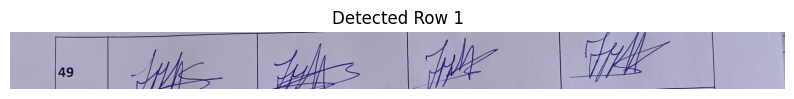

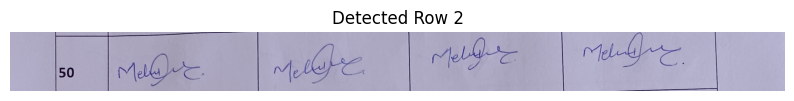

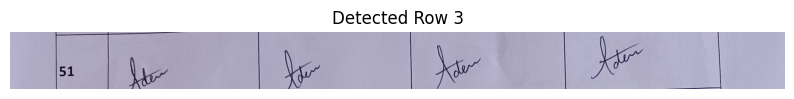

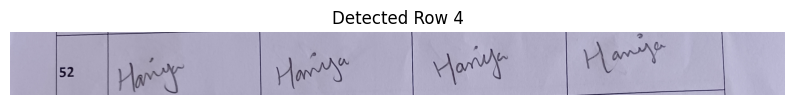

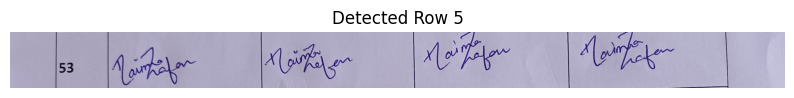

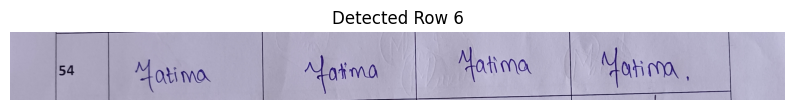

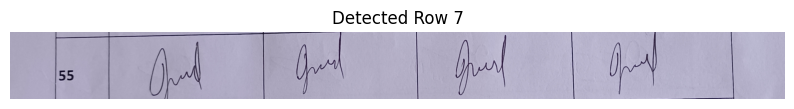

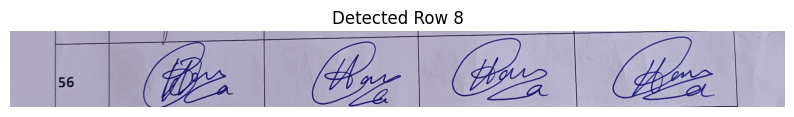

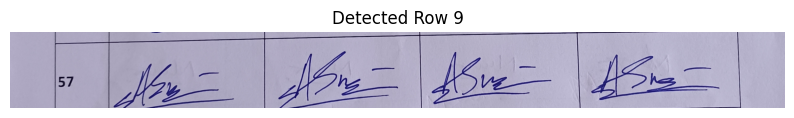

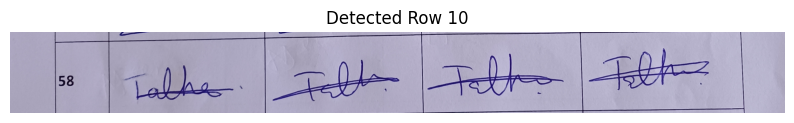

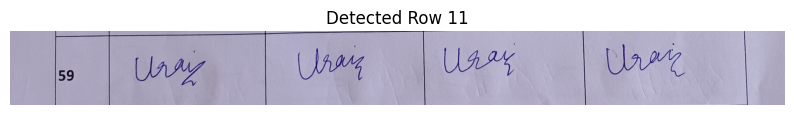

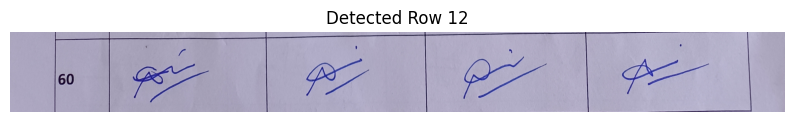

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to detect rows and output each row individually, while filtering out boundary dividers
def detect_and_output_rows(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect horizontal lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=120, minLineLength=200, maxLineGap=15)
    horizontal_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Detect horizontal lines
            if abs(y2 - y1) < abs(x2 - x1) * 0.05 and abs(x2 - x1) > 200:
                horizontal_lines.append(line)

    # Sort lines by their y-coordinates to ensure correct row order
    horizontal_lines = sorted(horizontal_lines, key=lambda line: line[0][1])

    # Merge close horizontal lines to avoid detecting multiple lines for one row
    merged_horizontal_lines = []
    merge_threshold = 100  # Increase the threshold to filter out dividers

    for line in horizontal_lines:
        if not merged_horizontal_lines:
            merged_horizontal_lines.append(line)
        else:
            prev_line = merged_horizontal_lines[-1]
            # Filter based on distance to ensure rows are sufficiently spaced
            if abs(line[0][1] - prev_line[0][1]) > merge_threshold:
                merged_horizontal_lines.append(line)

    # Now crop the image into individual rows based on the detected lines
    detected_rows = []
    for i in range(len(merged_horizontal_lines) - 1):
        y1 = merged_horizontal_lines[i][0][1]
        y2 = merged_horizontal_lines[i + 1][0][1]
        if abs(y2 - y1) > 120:  # Ensure rows have height > 100 to filter out dividers
            row_image = image[y1:y2, :]
            detected_rows.append(row_image)

    # Output and visualize each row separately
    for idx, row in enumerate(detected_rows):
        plt.figure(figsize=(10, 3))
        plt.imshow(cv2.cvtColor(row, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected Row {idx + 1}")
        plt.axis('off')
        plt.show()

    return detected_rows

# Main processing function to test row extraction
input_image_path = "/content/drive/My Drive/Data/5.jpg"
image = cv2.imread(input_image_path)

# Detect and visualize individual rows
detected_rows = detect_and_output_rows(image)


In [ ]:
# New function to save the signature to 'image2' subfolder
def save_signature_to_image2_subfolder(extracted_signature):
    # Define the path to the 'image2' subfolder
    base_path = "/content/drive/My Drive/YO/"
    image2_folder = os.path.join(base_path, "image5")

    # Create the 'image2' folder if it doesn't exist
    if not os.path.exists(image2_folder):
        os.makedirs(image2_folder)

    # Find the next available image number to avoid overwriting
    existing_images = [f for f in os.listdir(image2_folder) if f.endswith(".png")]
    image_number = len(existing_images) + 1

    # Define the filename and save the image
    signature_filename = f"{image_number}.png"
    signature_path = os.path.join(image2_folder, signature_filename)

    # Save the extracted signature
    cv2.imwrite(signature_path, extracted_signature)
    print(f"Saved signature to {signature_path}")


# Step 1: Detect the largest horizontal and vertical lines and crop the image based on them
def detect_largest_lines(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=120, minLineLength=300, maxLineGap=30)

    horizontal_lines = []
    vertical_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(x2 - x1) > abs(y2 - y1):  # Horizontal line
                horizontal_lines.append(line[0])
            else:  # Vertical line
                vertical_lines.append(line[0])

    # Sort horizontal and vertical lines by their positions
    horizontal_lines = sorted(horizontal_lines, key=lambda line: min(line[1], line[3]))  # Sort by y position
    vertical_lines = sorted(vertical_lines, key=lambda line: min(line[0], line[2]))  # Sort by x position

    # Get the top and bottom lines
    top_line = horizontal_lines[0] if horizontal_lines else None
    bottom_line = horizontal_lines[-1] if horizontal_lines else None

    # Get the leftmost and rightmost lines
    left_line = vertical_lines[0] if vertical_lines else None
    right_line = vertical_lines[-1] if vertical_lines else None

    return top_line, bottom_line, left_line, right_line

# Step 2: Crop the image using the detected largest lines
def crop_image_by_lines(image, top_line, bottom_line, left_line, right_line):
    if top_line is None or bottom_line is None or left_line is None or right_line is None:
        return image  # If we don't detect enough lines, return the original image

    # Extract the coordinates of the lines
    y_top = min(top_line[1], top_line[3])
    y_bottom = max(bottom_line[1], bottom_line[3])
    x_left = min(left_line[0], left_line[2])
    x_right = max(right_line[0], right_line[2])

    # Crop the image based on the detected lines
    cropped_image = image[y_top:y_bottom, x_left:x_right]

    return cropped_image


# Function to detect rows and output each row individually, while filtering out boundary dividers
def detect_and_output_rows(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=250, minLineLength=400, maxLineGap=70)
    horizontal_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(y2 - y1) < abs(x2 - x1) * 0.05 and abs(x2 - x1) > 250:
                horizontal_lines.append(line)

    horizontal_lines = sorted(horizontal_lines, key=lambda line: line[0][1])

    merged_horizontal_lines = []
    merge_threshold = 350  # Increase the threshold to filter out dividers

    for line in horizontal_lines:
        if not merged_horizontal_lines:
            merged_horizontal_lines.append(line)
        else:
            prev_line = merged_horizontal_lines[-1]
            if abs(line[0][1] - prev_line[0][1]) > merge_threshold:
                merged_horizontal_lines.append(line)

    detected_rows = []
    for i in range(len(merged_horizontal_lines) - 1):
        y1 = merged_horizontal_lines[i][0][1]
        y2 = merged_horizontal_lines[i + 1][0][1]
        if abs(y2 - y1) > 120:  # Ensure rows have height > 100 to filter out dividers
            row_image = image[y1:y2, :]
            detected_rows.append(row_image)

    # Visualize all detected rows first
    for idx, row in enumerate(detected_rows):
        plt.figure(figsize=(10, 3))
        plt.imshow(cv2.cvtColor(row, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected Row {idx + 1}")
        plt.axis('off')
        plt.show()

    return detected_rows

def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Step 4: Extract and detect contours in each signature
def extract_signatures_from_row(row_image, row_index):
    # Check if the image is color (3 channels) or grayscale (2 channels)
    if len(row_image.shape) == 3:  # Color image
        row_height, row_width, _ = row_image.shape  # Get height, width, and channels
    else:  # Grayscale image
        row_height, row_width = row_image.shape  # Get height and width only

    id_column_width = int(row_width * 0.08)  # Skip ID column
    signature_width = (row_width - id_column_width) // 4  # Split remaining width into 4 columns
    signature_adjustment = 5

    # Loop through columns, skipping the first (ID column)
    for col_index in range(4):
        x_start = id_column_width + col_index * (signature_width + signature_adjustment)
        x_end = x_start + signature_width - signature_adjustment

        # Extract each signature column
        signature = row_image[:, x_start:x_end]

        # Apply Gaussian blur to reduce noise
        blurred_signature = cv2.GaussianBlur(signature, (5, 5), 0)

        # Ensure the image is in grayscale
        if len(blurred_signature.shape) == 3:  # If the signature is in color
            gray_signature = cv2.cvtColor(blurred_signature, cv2.COLOR_BGR2GRAY)
        else:
            gray_signature = blurred_signature  # Already grayscale

        # Step 1: Apply Gamma Correction to enhance brightness and contrast
        gamma_corrected_signature = adjust_gamma(gray_signature, gamma=1.5)



        # Display gamma-corrected image for debugging
        plt.imshow(gamma_corrected_signature, cmap='gray')
        plt.title("Gamma Corrected Signature")
        plt.axis('off')
        plt.show()

           # Step 3: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_signature = clahe.apply(gamma_corrected_signature)

        # Display CLAHE result for debugging
        plt.imshow(clahe_signature, cmap='gray')
        plt.title("CLAHE Enhanced Signature")
        plt.axis('off')
        plt.show()

         # Step 4: Apply Median Blurring (smoothing to reduce noise while preserving edges)
        blurred_signature = cv2.medianBlur(clahe_signature, 5)  # Adjust kernel size (5) as needed

        # Apply Sobel filter for better edge detection
        sobelx = cv2.Sobel(gray_signature, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray_signature, cv2.CV_64F, 0, 1, ksize=3)
        sobel_edges = cv2.magnitude(sobelx, sobely)

        # Convert back to uint8 for further processing
        sobel_edges = cv2.convertScaleAbs(sobel_edges)

         # Step 6: Apply a combination of Adaptive Thresholding and Otsu's Thresholding
        # Adaptive thresholding for fine contrast adjustments
        adaptive_thresh_signature = cv2.adaptiveThreshold(
        sobel_edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
         )

          # Otsu's Thresholding for global binarization
        _, otsu_thresh_signature = cv2.threshold(
        blurred_signature, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )

          # Combine both threshold results
        combined_thresh = cv2.bitwise_or(adaptive_thresh_signature, otsu_thresh_signature)

        # Display intermediate results for debugging
        plt.imshow(combined_thresh, cmap='gray')
        plt.title("Combined Thresholded Signature")
        plt.axis('off')
        plt.show()

        # Step 8: Find contours in the thresholded image
        contours, hierarchy = cv2.findContours(combined_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours based on area to avoid losing smaller but useful contours
        min_contour_area = 50  # Adjust this threshold based on the size of signatures
        valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

        # Debug output: draw contours on a copy of the image to visualize
        contour_debug_image = combined_thresh.copy()
        cv2.drawContours(contour_debug_image, valid_contours, -1, (255, 255, 255), thickness=2)
        plt.imshow(contour_debug_image, cmap='gray')
        plt.title("Contours Debug Output")
        plt.axis('off')
        plt.show()

         # If contours are found, find the largest contour
        if valid_contours:
            largest_contour = max(valid_contours, key=cv2.contourArea)

            # Step 9: Create a mask for the largest contour
            mask = np.zeros_like(combined_thresh)
            cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

            # Extract the signature using the mask
            extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

            # Display the extracted signature
            plt.imshow(extracted_signature, cmap='gray')
            plt.title(f"Extracted Signature from Row {row_index + 1}")
            plt.axis('off')
            plt.show()
        else:
            print(f"No valid contours found in row {row_index + 1}")
            extracted_signature = gray_signature  # Use grayscale if no contours are found

                  # Threshold the edges to form binary contours
        _, binary_edges = cv2.threshold(sobel_edges, 30, 255, cv2.THRESH_BINARY)

          # Ensure binary_edges is in CV_8UC1 format (grayscale)
        if len(binary_edges.shape) == 3:
              binary_edges = cv2.cvtColor(binary_edges, cv2.COLOR_BGR2GRAY)

          # Display the binary edges for debugging
        plt.figure(figsize=(5, 5))
        plt.imshow(binary_edges, cmap='gray')
        plt.title("Binary Edges")
        plt.axis('off')
        plt.show()

          # Find contours with hierarchy
        contours, hierarchy = cv2.findContours(binary_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

          # If contours are found, proceed to mask creation and contour processing
        if contours:
              # Debug: Visualize all contours on the binary edges for inspection
            contour_debug_image = binary_edges.copy()
            cv2.drawContours(contour_debug_image, contours, -1, (255, 255, 255), thickness=2)

              # Display the debug contours image
            plt.figure(figsize=(5, 5))
            plt.imshow(contour_debug_image, cmap='gray')
            plt.title("All Detected Contours")
            plt.axis('off')
            plt.show()

              # Option 1: Select the largest contour (can miss smaller parts of the signature)
            largest_contour = max(contours, key=cv2.contourArea)

              # Option 2 (Recommended): Iterate over all valid contours and apply the mask
            min_contour_area = 50  # Adjust this threshold based on the size of the signature parts
            valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

              # Debug: If no valid contours found, skip processing
            if not valid_contours:
                print(f"No valid contours found in row {row_index + 1}")
                extracted_signature = gray_signature  # Use grayscale image if no contours found
            else:
                  # Create a mask for all valid contours
                mask = np.zeros_like(binary_edges)
                cv2.drawContours(mask, valid_contours, -1, 255, thickness=cv2.FILLED)

                  # Extract the signature using the mask
                extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

                  # Display the final extracted signature
                plt.figure(figsize=(5, 5))
                plt.imshow(extracted_signature, cmap='gray')
                plt.title(f"Extracted Signature from Row {row_index + 1}")
                plt.axis('off')
                plt.show()
        else:
          print(f"No contours found in row {row_index + 1}")
          extracted_signature = gray_signature  # Use the grayscale image if no contours are found


          # Save the extracted signature
        signature_filename = f"signature_{row_index + 1}_{col_index + 1}.png"
        cv2.imwrite(signature_filename, extracted_signature)

          # Display the extracted signature
        plt.figure(figsize=(5, 5))
        plt.imshow(extracted_signature, cmap='gray')
        plt.title(f"Signature_{row_index + 1}_{col_index + 1}")
        plt.axis('off')
        plt.show()
        save_signature_to_image2_subfolder(extracted_signature)





# Main processing
input_image_path = "/content/drive/My Drive/Data/5.jpg"
image = cv2.imread(input_image_path)

# Step 1: Detect largest lines and crop the image
top_line, bottom_line, left_line, right_line = detect_largest_lines(image)
cropped_image = crop_image_by_lines(image, top_line, bottom_line, left_line, right_line)

# Step 2: Detect rows
detected_rows = detect_and_output_rows(cropped_image)

# Step 3: Loop through detected rows and extract signatures
for i, row_image in enumerate(detected_rows):
    # Extract signatures from the row
    extract_signatures_from_row(row_image, i)



## Image 6

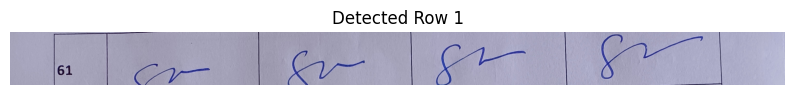

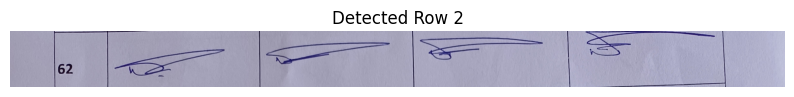

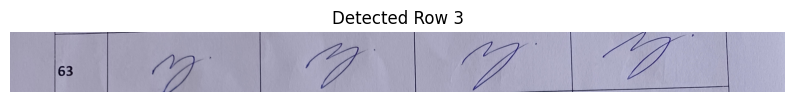

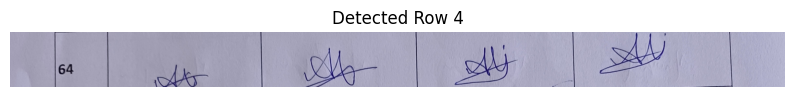

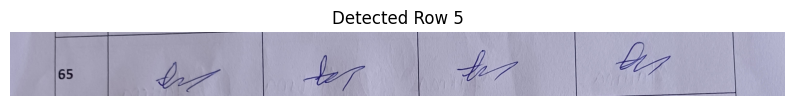

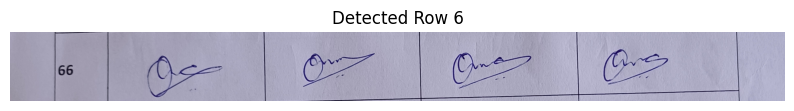

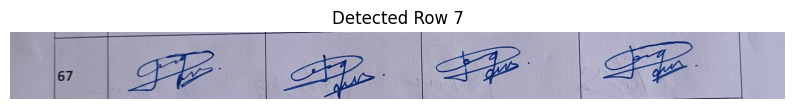

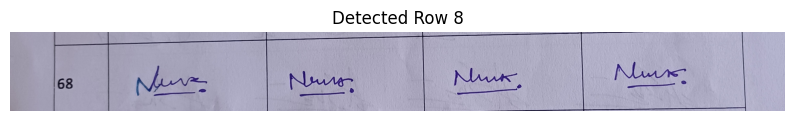

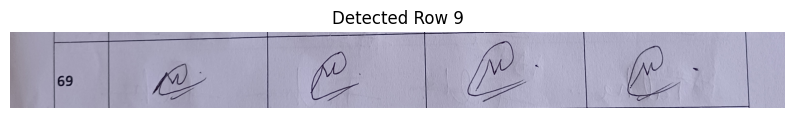

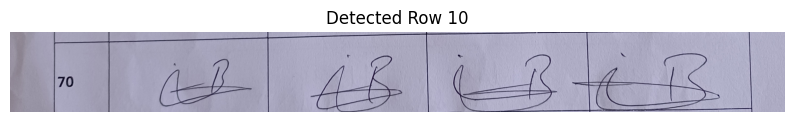

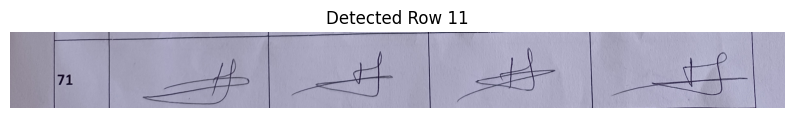

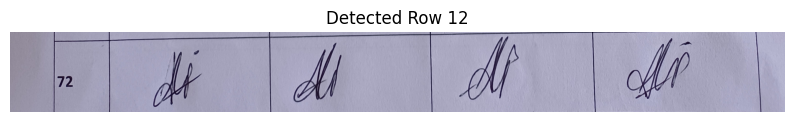

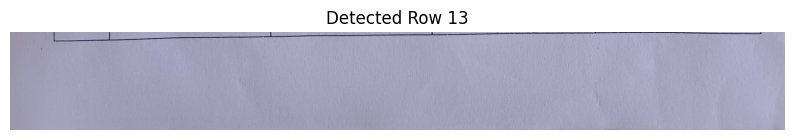

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to detect rows and output each row individually, while filtering out boundary dividers
def detect_and_output_rows(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect horizontal lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=120, minLineLength=200, maxLineGap=15)
    horizontal_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Detect horizontal lines
            if abs(y2 - y1) < abs(x2 - x1) * 0.05 and abs(x2 - x1) > 200:
                horizontal_lines.append(line)

    # Sort lines by their y-coordinates to ensure correct row order
    horizontal_lines = sorted(horizontal_lines, key=lambda line: line[0][1])

    # Merge close horizontal lines to avoid detecting multiple lines for one row
    merged_horizontal_lines = []
    merge_threshold = 100  # Increase the threshold to filter out dividers

    for line in horizontal_lines:
        if not merged_horizontal_lines:
            merged_horizontal_lines.append(line)
        else:
            prev_line = merged_horizontal_lines[-1]
            # Filter based on distance to ensure rows are sufficiently spaced
            if abs(line[0][1] - prev_line[0][1]) > merge_threshold:
                merged_horizontal_lines.append(line)

    # Now crop the image into individual rows based on the detected lines
    detected_rows = []
    for i in range(len(merged_horizontal_lines) - 1):
        y1 = merged_horizontal_lines[i][0][1]
        y2 = merged_horizontal_lines[i + 1][0][1]
        if abs(y2 - y1) > 150:  # Ensure rows have height > 100 to filter out dividers
            row_image = image[y1:y2, :]
            detected_rows.append(row_image)

    # Output and visualize each row separately
    for idx, row in enumerate(detected_rows):
        plt.figure(figsize=(10, 3))
        plt.imshow(cv2.cvtColor(row, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected Row {idx + 1}")
        plt.axis('off')
        plt.show()

    return detected_rows

# Main processing function to test row extraction
input_image_path = "/content/drive/My Drive/Data/6.jpg"
image = cv2.imread(input_image_path)

# Detect and visualize individual rows
detected_rows = detect_and_output_rows(image)


In [ ]:
# New function to save the signature to 'image2' subfolder
def save_signature_to_image2_subfolder(extracted_signature):
    # Define the path to the 'image2' subfolder
    base_path = "/content/drive/My Drive/YO/"
    image2_folder = os.path.join(base_path, "image6")

    # Create the 'image2' folder if it doesn't exist
    if not os.path.exists(image2_folder):
        os.makedirs(image2_folder)

    # Find the next available image number to avoid overwriting
    existing_images = [f for f in os.listdir(image2_folder) if f.endswith(".png")]
    image_number = len(existing_images) + 1

    # Define the filename and save the image
    signature_filename = f"{image_number}.png"
    signature_path = os.path.join(image2_folder, signature_filename)

    # Save the extracted signature
    cv2.imwrite(signature_path, extracted_signature)
    print(f"Saved signature to {signature_path}")


# Step 1: Detect the largest horizontal and vertical lines and crop the image based on them
def detect_largest_lines(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=120, minLineLength=300, maxLineGap=30)

    horizontal_lines = []
    vertical_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(x2 - x1) > abs(y2 - y1):  # Horizontal line
                horizontal_lines.append(line[0])
            else:  # Vertical line
                vertical_lines.append(line[0])

    # Sort horizontal and vertical lines by their positions
    horizontal_lines = sorted(horizontal_lines, key=lambda line: min(line[1], line[3]))  # Sort by y position
    vertical_lines = sorted(vertical_lines, key=lambda line: min(line[0], line[2]))  # Sort by x position

    # Get the top and bottom lines
    top_line = horizontal_lines[0] if horizontal_lines else None
    bottom_line = horizontal_lines[-1] if horizontal_lines else None

    # Get the leftmost and rightmost lines
    left_line = vertical_lines[0] if vertical_lines else None
    right_line = vertical_lines[-1] if vertical_lines else None

    return top_line, bottom_line, left_line, right_line

# Step 2: Crop the image using the detected largest lines
def crop_image_by_lines(image, top_line, bottom_line, left_line, right_line):
    if top_line is None or bottom_line is None or left_line is None or right_line is None:
        return image  # If we don't detect enough lines, return the original image

    # Extract the coordinates of the lines
    y_top = min(top_line[1], top_line[3])
    y_bottom = max(bottom_line[1], bottom_line[3])
    x_left = min(left_line[0], left_line[2])
    x_right = max(right_line[0], right_line[2])

    # Crop the image based on the detected lines
    cropped_image = image[y_top:y_bottom, x_left:x_right]

    return cropped_image


# Function to detect rows and output each row individually, while filtering out boundary dividers
def detect_and_output_rows(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=250, minLineLength=300, maxLineGap=55)
    horizontal_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(y2 - y1) < abs(x2 - x1) * 0.05 and abs(x2 - x1) > 250:
                horizontal_lines.append(line)

    horizontal_lines = sorted(horizontal_lines, key=lambda line: line[0][1])

    merged_horizontal_lines = []
    merge_threshold = 290  # Increase the threshold to filter out dividers

    for line in horizontal_lines:
        if not merged_horizontal_lines:
            merged_horizontal_lines.append(line)
        else:
            prev_line = merged_horizontal_lines[-1]
            if abs(line[0][1] - prev_line[0][1]) > merge_threshold:
                merged_horizontal_lines.append(line)

    detected_rows = []
    for i in range(len(merged_horizontal_lines) - 1):
        y1 = merged_horizontal_lines[i][0][1]
        y2 = merged_horizontal_lines[i + 1][0][1]
        if abs(y2 - y1) > 120:  # Ensure rows have height > 100 to filter out dividers
            row_image = image[y1:y2, :]
            detected_rows.append(row_image)

    # Visualize all detected rows first
    for idx, row in enumerate(detected_rows):
        plt.figure(figsize=(10, 3))
        plt.imshow(cv2.cvtColor(row, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected Row {idx + 1}")
        plt.axis('off')
        plt.show()

    return detected_rows

def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Step 4: Extract and detect contours in each signature
def extract_signatures_from_row(row_image, row_index):
    # Check if the image is color (3 channels) or grayscale (2 channels)
    if len(row_image.shape) == 3:  # Color image
        row_height, row_width, _ = row_image.shape  # Get height, width, and channels
    else:  # Grayscale image
        row_height, row_width = row_image.shape  # Get height and width only

    id_column_width = int(row_width * 0.08)  # Skip ID column
    signature_width = (row_width - id_column_width) // 4  # Split remaining width into 4 columns
    signature_adjustment = 5

    # Loop through columns, skipping the first (ID column)
    for col_index in range(4):
        x_start = id_column_width + col_index * (signature_width + signature_adjustment)
        x_end = x_start + signature_width - signature_adjustment

        # Extract each signature column
        signature = row_image[:, x_start:x_end]

        # Apply Gaussian blur to reduce noise
        blurred_signature = cv2.GaussianBlur(signature, (5, 5), 0)

        # Ensure the image is in grayscale
        if len(blurred_signature.shape) == 3:  # If the signature is in color
            gray_signature = cv2.cvtColor(blurred_signature, cv2.COLOR_BGR2GRAY)
        else:
            gray_signature = blurred_signature  # Already grayscale

        # Step 1: Apply Gamma Correction to enhance brightness and contrast
        gamma_corrected_signature = adjust_gamma(gray_signature, gamma=1.5)



        # Display gamma-corrected image for debugging
        plt.imshow(gamma_corrected_signature, cmap='gray')
        plt.title("Gamma Corrected Signature")
        plt.axis('off')
        plt.show()

           # Step 3: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_signature = clahe.apply(gamma_corrected_signature)

        # Display CLAHE result for debugging
        plt.imshow(clahe_signature, cmap='gray')
        plt.title("CLAHE Enhanced Signature")
        plt.axis('off')
        plt.show()

         # Step 4: Apply Median Blurring (smoothing to reduce noise while preserving edges)
        blurred_signature = cv2.medianBlur(clahe_signature, 5)  # Adjust kernel size (5) as needed

        # Apply Sobel filter for better edge detection
        sobelx = cv2.Sobel(gray_signature, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray_signature, cv2.CV_64F, 0, 1, ksize=3)
        sobel_edges = cv2.magnitude(sobelx, sobely)

        # Convert back to uint8 for further processing
        sobel_edges = cv2.convertScaleAbs(sobel_edges)

         # Step 6: Apply a combination of Adaptive Thresholding and Otsu's Thresholding
        # Adaptive thresholding for fine contrast adjustments
        adaptive_thresh_signature = cv2.adaptiveThreshold(
        sobel_edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
         )

          # Otsu's Thresholding for global binarization
        _, otsu_thresh_signature = cv2.threshold(
        blurred_signature, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )

          # Combine both threshold results
        combined_thresh = cv2.bitwise_or(adaptive_thresh_signature, otsu_thresh_signature)

        # Display intermediate results for debugging
        plt.imshow(combined_thresh, cmap='gray')
        plt.title("Combined Thresholded Signature")
        plt.axis('off')
        plt.show()

        # Step 8: Find contours in the thresholded image
        contours, hierarchy = cv2.findContours(combined_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours based on area to avoid losing smaller but useful contours
        min_contour_area = 50  # Adjust this threshold based on the size of signatures
        valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

        # Debug output: draw contours on a copy of the image to visualize
        contour_debug_image = combined_thresh.copy()
        cv2.drawContours(contour_debug_image, valid_contours, -1, (255, 255, 255), thickness=2)
        plt.imshow(contour_debug_image, cmap='gray')
        plt.title("Contours Debug Output")
        plt.axis('off')
        plt.show()

         # If contours are found, find the largest contour
        if valid_contours:
            largest_contour = max(valid_contours, key=cv2.contourArea)

            # Step 9: Create a mask for the largest contour
            mask = np.zeros_like(combined_thresh)
            cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

            # Extract the signature using the mask
            extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

            # Display the extracted signature
            plt.imshow(extracted_signature, cmap='gray')
            plt.title(f"Extracted Signature from Row {row_index + 1}")
            plt.axis('off')
            plt.show()
        else:
            print(f"No valid contours found in row {row_index + 1}")
            extracted_signature = gray_signature  # Use grayscale if no contours are found

                  # Threshold the edges to form binary contours
        _, binary_edges = cv2.threshold(sobel_edges, 30, 255, cv2.THRESH_BINARY)

          # Ensure binary_edges is in CV_8UC1 format (grayscale)
        if len(binary_edges.shape) == 3:
              binary_edges = cv2.cvtColor(binary_edges, cv2.COLOR_BGR2GRAY)

          # Display the binary edges for debugging
        plt.figure(figsize=(5, 5))
        plt.imshow(binary_edges, cmap='gray')
        plt.title("Binary Edges")
        plt.axis('off')
        plt.show()

          # Find contours with hierarchy
        contours, hierarchy = cv2.findContours(binary_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

          # If contours are found, proceed to mask creation and contour processing
        if contours:
              # Debug: Visualize all contours on the binary edges for inspection
            contour_debug_image = binary_edges.copy()
            cv2.drawContours(contour_debug_image, contours, -1, (255, 255, 255), thickness=2)

              # Display the debug contours image
            plt.figure(figsize=(5, 5))
            plt.imshow(contour_debug_image, cmap='gray')
            plt.title("All Detected Contours")
            plt.axis('off')
            plt.show()

              # Option 1: Select the largest contour (can miss smaller parts of the signature)
            largest_contour = max(contours, key=cv2.contourArea)

              # Option 2 (Recommended): Iterate over all valid contours and apply the mask
            min_contour_area = 50  # Adjust this threshold based on the size of the signature parts
            valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

              # Debug: If no valid contours found, skip processing
            if not valid_contours:
                print(f"No valid contours found in row {row_index + 1}")
                extracted_signature = gray_signature  # Use grayscale image if no contours found
            else:
                  # Create a mask for all valid contours
                mask = np.zeros_like(binary_edges)
                cv2.drawContours(mask, valid_contours, -1, 255, thickness=cv2.FILLED)

                  # Extract the signature using the mask
                extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

                  # Display the final extracted signature
                plt.figure(figsize=(5, 5))
                plt.imshow(extracted_signature, cmap='gray')
                plt.title(f"Extracted Signature from Row {row_index + 1}")
                plt.axis('off')
                plt.show()
        else:
          print(f"No contours found in row {row_index + 1}")
          extracted_signature = gray_signature  # Use the grayscale image if no contours are found


          # Save the extracted signature
        signature_filename = f"signature_{row_index + 1}_{col_index + 1}.png"
        cv2.imwrite(signature_filename, extracted_signature)

          # Display the extracted signature
        plt.figure(figsize=(5, 5))
        plt.imshow(extracted_signature, cmap='gray')
        plt.title(f"Signature_{row_index + 1}_{col_index + 1}")
        plt.axis('off')
        plt.show()
        save_signature_to_image2_subfolder(extracted_signature)





# Main processing
input_image_path = "/content/drive/My Drive/Data/6.jpg"
image = cv2.imread(input_image_path)

# Step 1: Detect largest lines and crop the image
top_line, bottom_line, left_line, right_line = detect_largest_lines(image)
cropped_image = crop_image_by_lines(image, top_line, bottom_line, left_line, right_line)

# Step 2: Detect rows
detected_rows = detect_and_output_rows(cropped_image)

# Step 3: Loop through detected rows and extract signatures
for i, row_image in enumerate(detected_rows):
    # Extract signatures from the row
    extract_signatures_from_row(row_image, i)



## Image 7

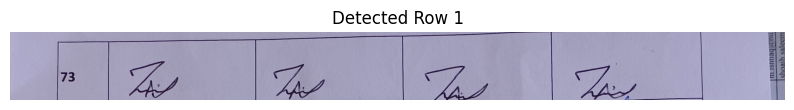

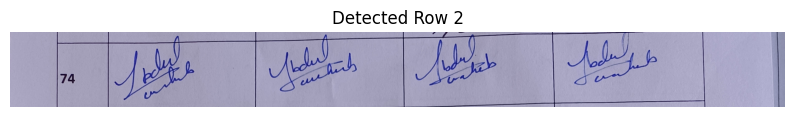

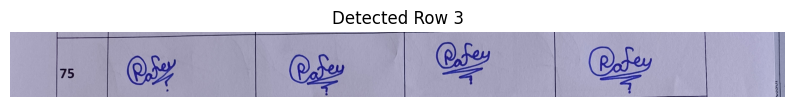

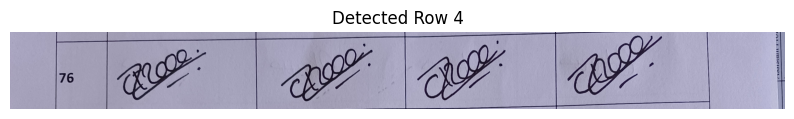

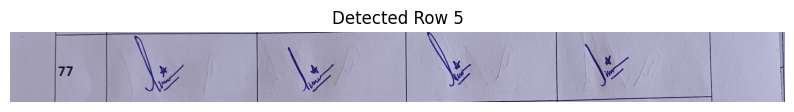

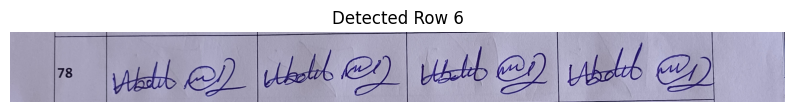

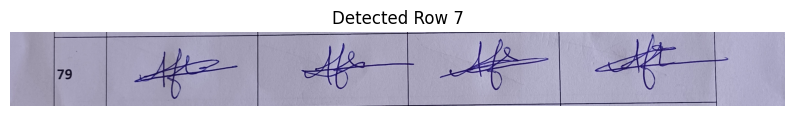

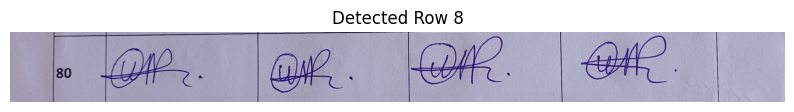

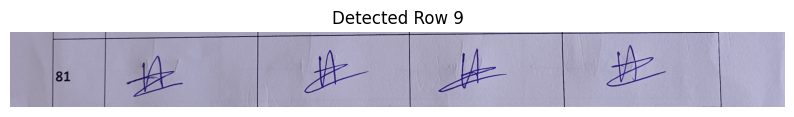

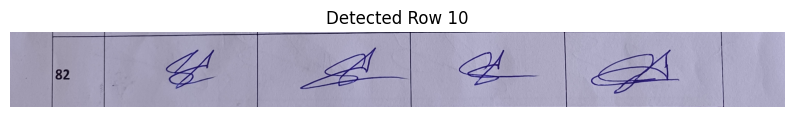

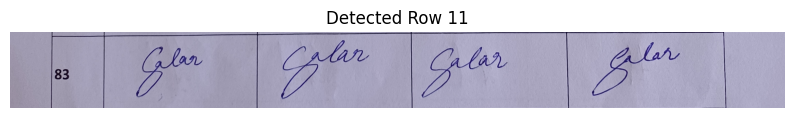

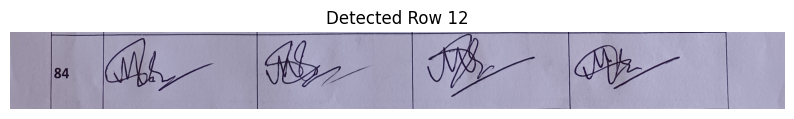

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to detect rows and output each row individually, while filtering out boundary dividers
def detect_and_output_rows(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect horizontal lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=120, minLineLength=200, maxLineGap=15)
    horizontal_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Detect horizontal lines
            if abs(y2 - y1) < abs(x2 - x1) * 0.05 and abs(x2 - x1) > 200:
                horizontal_lines.append(line)

    # Sort lines by their y-coordinates to ensure correct row order
    horizontal_lines = sorted(horizontal_lines, key=lambda line: line[0][1])

    # Merge close horizontal lines to avoid detecting multiple lines for one row
    merged_horizontal_lines = []
    merge_threshold = 100  # Increase the threshold to filter out dividers

    for line in horizontal_lines:
        if not merged_horizontal_lines:
            merged_horizontal_lines.append(line)
        else:
            prev_line = merged_horizontal_lines[-1]
            # Filter based on distance to ensure rows are sufficiently spaced
            if abs(line[0][1] - prev_line[0][1]) > merge_threshold:
                merged_horizontal_lines.append(line)

    # Now crop the image into individual rows based on the detected lines
    detected_rows = []
    for i in range(len(merged_horizontal_lines) - 1):
        y1 = merged_horizontal_lines[i][0][1]
        y2 = merged_horizontal_lines[i + 1][0][1]
        if abs(y2 - y1) > 150:  # Ensure rows have height > 100 to filter out dividers
            row_image = image[y1:y2, :]
            detected_rows.append(row_image)

    # Output and visualize each row separately
    for idx, row in enumerate(detected_rows):
        plt.figure(figsize=(10, 3))
        plt.imshow(cv2.cvtColor(row, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected Row {idx + 1}")
        plt.axis('off')
        plt.show()

    return detected_rows

# Main processing function to test row extraction
input_image_path = "/content/drive/My Drive/Data/7.jpg"
image = cv2.imread(input_image_path)

# Detect and visualize individual rows
detected_rows = detect_and_output_rows(image)


In [ ]:
# New function to save the signature to 'image2' subfolder
def save_signature_to_image2_subfolder(extracted_signature):
    # Define the path to the 'image2' subfolder
    base_path = "/content/drive/My Drive/YO/"
    image2_folder = os.path.join(base_path, "image7")

    # Create the 'image2' folder if it doesn't exist
    if not os.path.exists(image2_folder):
        os.makedirs(image2_folder)

    # Find the next available image number to avoid overwriting
    existing_images = [f for f in os.listdir(image2_folder) if f.endswith(".png")]
    image_number = len(existing_images) + 1

    # Define the filename and save the image
    signature_filename = f"{image_number}.png"
    signature_path = os.path.join(image2_folder, signature_filename)

    # Save the extracted signature
    cv2.imwrite(signature_path, extracted_signature)
    print(f"Saved signature to {signature_path}")


# Step 1: Detect the largest horizontal and vertical lines and crop the image based on them
def detect_largest_lines(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=120, minLineLength=300, maxLineGap=30)

    horizontal_lines = []
    vertical_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(x2 - x1) > abs(y2 - y1):  # Horizontal line
                horizontal_lines.append(line[0])
            else:  # Vertical line
                vertical_lines.append(line[0])

    # Sort horizontal and vertical lines by their positions
    horizontal_lines = sorted(horizontal_lines, key=lambda line: min(line[1], line[3]))  # Sort by y position
    vertical_lines = sorted(vertical_lines, key=lambda line: min(line[0], line[2]))  # Sort by x position

    # Get the top and bottom lines
    top_line = horizontal_lines[0] if horizontal_lines else None
    bottom_line = horizontal_lines[-1] if horizontal_lines else None

    # Get the leftmost and rightmost lines
    left_line = vertical_lines[0] if vertical_lines else None
    right_line = vertical_lines[-1] if vertical_lines else None

    return top_line, bottom_line, left_line, right_line

# Step 2: Crop the image using the detected largest lines
def crop_image_by_lines(image, top_line, bottom_line, left_line, right_line):
    if top_line is None or bottom_line is None or left_line is None or right_line is None:
        return image  # If we don't detect enough lines, return the original image

    # Extract the coordinates of the lines
    y_top = min(top_line[1], top_line[3])
    y_bottom = max(bottom_line[1], bottom_line[3])
    x_left = min(left_line[0], left_line[2])
    x_right = max(right_line[0], right_line[2])

    # Crop the image based on the detected lines
    cropped_image = image[y_top:y_bottom, x_left:x_right]

    return cropped_image


# Function to detect rows and output each row individually, while filtering out boundary dividers
def detect_and_output_rows(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=250, minLineLength=400, maxLineGap=70)
    horizontal_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(y2 - y1) < abs(x2 - x1) * 0.05 and abs(x2 - x1) > 250:
                horizontal_lines.append(line)

    horizontal_lines = sorted(horizontal_lines, key=lambda line: line[0][1])

    merged_horizontal_lines = []
    merge_threshold = 350  # Increase the threshold to filter out dividers

    for line in horizontal_lines:
        if not merged_horizontal_lines:
            merged_horizontal_lines.append(line)
        else:
            prev_line = merged_horizontal_lines[-1]
            if abs(line[0][1] - prev_line[0][1]) > merge_threshold:
                merged_horizontal_lines.append(line)

    detected_rows = []
    for i in range(len(merged_horizontal_lines) - 1):
        y1 = merged_horizontal_lines[i][0][1]
        y2 = merged_horizontal_lines[i + 1][0][1]
        if abs(y2 - y1) > 120:  # Ensure rows have height > 100 to filter out dividers
            row_image = image[y1:y2, :]
            detected_rows.append(row_image)

    # Visualize all detected rows first
    for idx, row in enumerate(detected_rows):
        plt.figure(figsize=(10, 3))
        plt.imshow(cv2.cvtColor(row, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected Row {idx + 1}")
        plt.axis('off')
        plt.show()

    return detected_rows

def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Step 4: Extract and detect contours in each signature
def extract_signatures_from_row(row_image, row_index):
    # Check if the image is color (3 channels) or grayscale (2 channels)
    if len(row_image.shape) == 3:  # Color image
        row_height, row_width, _ = row_image.shape  # Get height, width, and channels
    else:  # Grayscale image
        row_height, row_width = row_image.shape  # Get height and width only

    id_column_width = int(row_width * 0.08)  # Skip ID column
    signature_width = (row_width - id_column_width) // 4  # Split remaining width into 4 columns
    signature_adjustment = 5

    # Loop through columns, skipping the first (ID column)
    for col_index in range(4):
        x_start = id_column_width + col_index * (signature_width + signature_adjustment)
        x_end = x_start + signature_width - signature_adjustment

        # Extract each signature column
        signature = row_image[:, x_start:x_end]

        # Apply Gaussian blur to reduce noise
        blurred_signature = cv2.GaussianBlur(signature, (5, 5), 0)

        # Ensure the image is in grayscale
        if len(blurred_signature.shape) == 3:  # If the signature is in color
            gray_signature = cv2.cvtColor(blurred_signature, cv2.COLOR_BGR2GRAY)
        else:
            gray_signature = blurred_signature  # Already grayscale

        # Step 1: Apply Gamma Correction to enhance brightness and contrast
        gamma_corrected_signature = adjust_gamma(gray_signature, gamma=1.5)



        # Display gamma-corrected image for debugging
        plt.imshow(gamma_corrected_signature, cmap='gray')
        plt.title("Gamma Corrected Signature")
        plt.axis('off')
        plt.show()

           # Step 3: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_signature = clahe.apply(gamma_corrected_signature)

        # Display CLAHE result for debugging
        plt.imshow(clahe_signature, cmap='gray')
        plt.title("CLAHE Enhanced Signature")
        plt.axis('off')
        plt.show()

         # Step 4: Apply Median Blurring (smoothing to reduce noise while preserving edges)
        blurred_signature = cv2.medianBlur(clahe_signature, 5)  # Adjust kernel size (5) as needed

        # Apply Sobel filter for better edge detection
        sobelx = cv2.Sobel(gray_signature, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray_signature, cv2.CV_64F, 0, 1, ksize=3)
        sobel_edges = cv2.magnitude(sobelx, sobely)

        # Convert back to uint8 for further processing
        sobel_edges = cv2.convertScaleAbs(sobel_edges)

         # Step 6: Apply a combination of Adaptive Thresholding and Otsu's Thresholding
        # Adaptive thresholding for fine contrast adjustments
        adaptive_thresh_signature = cv2.adaptiveThreshold(
        sobel_edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
         )

          # Otsu's Thresholding for global binarization
        _, otsu_thresh_signature = cv2.threshold(
        blurred_signature, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )

          # Combine both threshold results
        combined_thresh = cv2.bitwise_or(adaptive_thresh_signature, otsu_thresh_signature)

        # Display intermediate results for debugging
        plt.imshow(combined_thresh, cmap='gray')
        plt.title("Combined Thresholded Signature")
        plt.axis('off')
        plt.show()

        # Step 8: Find contours in the thresholded image
        contours, hierarchy = cv2.findContours(combined_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours based on area to avoid losing smaller but useful contours
        min_contour_area = 50  # Adjust this threshold based on the size of signatures
        valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

        # Debug output: draw contours on a copy of the image to visualize
        contour_debug_image = combined_thresh.copy()
        cv2.drawContours(contour_debug_image, valid_contours, -1, (255, 255, 255), thickness=2)
        plt.imshow(contour_debug_image, cmap='gray')
        plt.title("Contours Debug Output")
        plt.axis('off')
        plt.show()

         # If contours are found, find the largest contour
        if valid_contours:
            largest_contour = max(valid_contours, key=cv2.contourArea)

            # Step 9: Create a mask for the largest contour
            mask = np.zeros_like(combined_thresh)
            cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

            # Extract the signature using the mask
            extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

            # Display the extracted signature
            plt.imshow(extracted_signature, cmap='gray')
            plt.title(f"Extracted Signature from Row {row_index + 1}")
            plt.axis('off')
            plt.show()
        else:
            print(f"No valid contours found in row {row_index + 1}")
            extracted_signature = gray_signature  # Use grayscale if no contours are found

                  # Threshold the edges to form binary contours
        _, binary_edges = cv2.threshold(sobel_edges, 30, 255, cv2.THRESH_BINARY)

          # Ensure binary_edges is in CV_8UC1 format (grayscale)
        if len(binary_edges.shape) == 3:
              binary_edges = cv2.cvtColor(binary_edges, cv2.COLOR_BGR2GRAY)

          # Display the binary edges for debugging
        plt.figure(figsize=(5, 5))
        plt.imshow(binary_edges, cmap='gray')
        plt.title("Binary Edges")
        plt.axis('off')
        plt.show()

          # Find contours with hierarchy
        contours, hierarchy = cv2.findContours(binary_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

          # If contours are found, proceed to mask creation and contour processing
        if contours:
              # Debug: Visualize all contours on the binary edges for inspection
            contour_debug_image = binary_edges.copy()
            cv2.drawContours(contour_debug_image, contours, -1, (255, 255, 255), thickness=2)

              # Display the debug contours image
            plt.figure(figsize=(5, 5))
            plt.imshow(contour_debug_image, cmap='gray')
            plt.title("All Detected Contours")
            plt.axis('off')
            plt.show()

              # Option 1: Select the largest contour (can miss smaller parts of the signature)
            largest_contour = max(contours, key=cv2.contourArea)

              # Option 2 (Recommended): Iterate over all valid contours and apply the mask
            min_contour_area = 50  # Adjust this threshold based on the size of the signature parts
            valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

              # Debug: If no valid contours found, skip processing
            if not valid_contours:
                print(f"No valid contours found in row {row_index + 1}")
                extracted_signature = gray_signature  # Use grayscale image if no contours found
            else:
                  # Create a mask for all valid contours
                mask = np.zeros_like(binary_edges)
                cv2.drawContours(mask, valid_contours, -1, 255, thickness=cv2.FILLED)

                  # Extract the signature using the mask
                extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

                  # Display the final extracted signature
                plt.figure(figsize=(5, 5))
                plt.imshow(extracted_signature, cmap='gray')
                plt.title(f"Extracted Signature from Row {row_index + 1}")
                plt.axis('off')
                plt.show()
        else:
          print(f"No contours found in row {row_index + 1}")
          extracted_signature = gray_signature  # Use the grayscale image if no contours are found


          # Save the extracted signature
        signature_filename = f"signature_{row_index + 1}_{col_index + 1}.png"
        cv2.imwrite(signature_filename, extracted_signature)

          # Display the extracted signature
        plt.figure(figsize=(5, 5))
        plt.imshow(extracted_signature, cmap='gray')
        plt.title(f"Signature_{row_index + 1}_{col_index + 1}")
        plt.axis('off')
        plt.show()
        save_signature_to_image2_subfolder(extracted_signature)





# Main processing
input_image_path = "/content/drive/My Drive/Data/7.jpg"
image = cv2.imread(input_image_path)

# Step 1: Detect largest lines and crop the image
top_line, bottom_line, left_line, right_line = detect_largest_lines(image)
cropped_image = crop_image_by_lines(image, top_line, bottom_line, left_line, right_line)

# Step 2: Detect rows
detected_rows = detect_and_output_rows(cropped_image)

# Step 3: Loop through detected rows and extract signatures
for i, row_image in enumerate(detected_rows):
    # Extract signatures from the row
    extract_signatures_from_row(row_image, i)



##Image 8

In [ ]:
# New function to save the signature to 'image2' subfolder
def save_signature_to_image2_subfolder(extracted_signature):
    # Define the path to the 'image2' subfolder
    base_path = "/content/drive/My Drive/YO/"
    image2_folder = os.path.join(base_path, "image8")

    # Create the 'image2' folder if it doesn't exist
    if not os.path.exists(image2_folder):
        os.makedirs(image2_folder)

    # Find the next available image number to avoid overwriting
    existing_images = [f for f in os.listdir(image2_folder) if f.endswith(".png")]
    image_number = len(existing_images) + 1

    # Define the filename and save the image
    signature_filename = f"{image_number}.png"
    signature_path = os.path.join(image2_folder, signature_filename)

    # Save the extracted signature
    cv2.imwrite(signature_path, extracted_signature)
    print(f"Saved signature to {signature_path}")


# Step 1: Detect the largest horizontal and vertical lines and crop the image based on them
def detect_largest_lines(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=120, minLineLength=300, maxLineGap=30)

    horizontal_lines = []
    vertical_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(x2 - x1) > abs(y2 - y1):  # Horizontal line
                horizontal_lines.append(line[0])
            else:  # Vertical line
                vertical_lines.append(line[0])

    # Sort horizontal and vertical lines by their positions
    horizontal_lines = sorted(horizontal_lines, key=lambda line: min(line[1], line[3]))  # Sort by y position
    vertical_lines = sorted(vertical_lines, key=lambda line: min(line[0], line[2]))  # Sort by x position

    # Get the top and bottom lines
    top_line = horizontal_lines[0] if horizontal_lines else None
    bottom_line = horizontal_lines[-1] if horizontal_lines else None

    # Get the leftmost and rightmost lines
    left_line = vertical_lines[0] if vertical_lines else None
    right_line = vertical_lines[-1] if vertical_lines else None

    return top_line, bottom_line, left_line, right_line

# Step 2: Crop the image using the detected largest lines
def crop_image_by_lines(image, top_line, bottom_line, left_line, right_line):
    if top_line is None or bottom_line is None or left_line is None or right_line is None:
        return image  # If we don't detect enough lines, return the original image

    # Extract the coordinates of the lines
    y_top = min(top_line[1], top_line[3])
    y_bottom = max(bottom_line[1], bottom_line[3])
    x_left = min(left_line[0], left_line[2])
    x_right = max(right_line[0], right_line[2])

    # Crop the image based on the detected lines
    cropped_image = image[y_top:y_bottom, x_left:x_right]

    return cropped_image


# Function to detect rows and output each row individually, while filtering out boundary dividers
def detect_and_output_rows(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=250, minLineLength=400, maxLineGap=70)
    horizontal_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(y2 - y1) < abs(x2 - x1) * 0.05 and abs(x2 - x1) > 250:
                horizontal_lines.append(line)

    horizontal_lines = sorted(horizontal_lines, key=lambda line: line[0][1])

    merged_horizontal_lines = []
    merge_threshold = 350  # Increase the threshold to filter out dividers

    for line in horizontal_lines:
        if not merged_horizontal_lines:
            merged_horizontal_lines.append(line)
        else:
            prev_line = merged_horizontal_lines[-1]
            if abs(line[0][1] - prev_line[0][1]) > merge_threshold:
                merged_horizontal_lines.append(line)

    detected_rows = []
    for i in range(len(merged_horizontal_lines) - 1):
        y1 = merged_horizontal_lines[i][0][1]
        y2 = merged_horizontal_lines[i + 1][0][1]
        if abs(y2 - y1) > 120:  # Ensure rows have height > 100 to filter out dividers
            row_image = image[y1:y2, :]
            detected_rows.append(row_image)

    # Visualize all detected rows first
    for idx, row in enumerate(detected_rows):
        plt.figure(figsize=(10, 3))
        plt.imshow(cv2.cvtColor(row, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected Row {idx + 1}")
        plt.axis('off')
        plt.show()

    return detected_rows

def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Step 4: Extract and detect contours in each signature
def extract_signatures_from_row(row_image, row_index):
    # Check if the image is color (3 channels) or grayscale (2 channels)
    if len(row_image.shape) == 3:  # Color image
        row_height, row_width, _ = row_image.shape  # Get height, width, and channels
    else:  # Grayscale image
        row_height, row_width = row_image.shape  # Get height and width only

    id_column_width = int(row_width * 0.08)  # Skip ID column
    signature_width = (row_width - id_column_width) // 4  # Split remaining width into 4 columns
    signature_adjustment = 5

    # Loop through columns, skipping the first (ID column)
    for col_index in range(4):
        x_start = id_column_width + col_index * (signature_width + signature_adjustment)
        x_end = x_start + signature_width - signature_adjustment

        # Extract each signature column
        signature = row_image[:, x_start:x_end]

        # Apply Gaussian blur to reduce noise
        blurred_signature = cv2.GaussianBlur(signature, (5, 5), 0)

        # Ensure the image is in grayscale
        if len(blurred_signature.shape) == 3:  # If the signature is in color
            gray_signature = cv2.cvtColor(blurred_signature, cv2.COLOR_BGR2GRAY)
        else:
            gray_signature = blurred_signature  # Already grayscale

        # Step 1: Apply Gamma Correction to enhance brightness and contrast
        gamma_corrected_signature = adjust_gamma(gray_signature, gamma=1.5)



        # Display gamma-corrected image for debugging
        plt.imshow(gamma_corrected_signature, cmap='gray')
        plt.title("Gamma Corrected Signature")
        plt.axis('off')
        plt.show()

           # Step 3: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_signature = clahe.apply(gamma_corrected_signature)

        # Display CLAHE result for debugging
        plt.imshow(clahe_signature, cmap='gray')
        plt.title("CLAHE Enhanced Signature")
        plt.axis('off')
        plt.show()

         # Step 4: Apply Median Blurring (smoothing to reduce noise while preserving edges)
        blurred_signature = cv2.medianBlur(clahe_signature, 5)  # Adjust kernel size (5) as needed

        # Apply Sobel filter for better edge detection
        sobelx = cv2.Sobel(gray_signature, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray_signature, cv2.CV_64F, 0, 1, ksize=3)
        sobel_edges = cv2.magnitude(sobelx, sobely)

        # Convert back to uint8 for further processing
        sobel_edges = cv2.convertScaleAbs(sobel_edges)

         # Step 6: Apply a combination of Adaptive Thresholding and Otsu's Thresholding
        # Adaptive thresholding for fine contrast adjustments
        adaptive_thresh_signature = cv2.adaptiveThreshold(
        sobel_edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
         )

          # Otsu's Thresholding for global binarization
        _, otsu_thresh_signature = cv2.threshold(
        blurred_signature, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )

          # Combine both threshold results
        combined_thresh = cv2.bitwise_or(adaptive_thresh_signature, otsu_thresh_signature)

        # Display intermediate results for debugging
        plt.imshow(combined_thresh, cmap='gray')
        plt.title("Combined Thresholded Signature")
        plt.axis('off')
        plt.show()

        # Step 8: Find contours in the thresholded image
        contours, hierarchy = cv2.findContours(combined_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours based on area to avoid losing smaller but useful contours
        min_contour_area = 50  # Adjust this threshold based on the size of signatures
        valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

        # Debug output: draw contours on a copy of the image to visualize
        contour_debug_image = combined_thresh.copy()
        cv2.drawContours(contour_debug_image, valid_contours, -1, (255, 255, 255), thickness=2)
        plt.imshow(contour_debug_image, cmap='gray')
        plt.title("Contours Debug Output")
        plt.axis('off')
        plt.show()

         # If contours are found, find the largest contour
        if valid_contours:
            largest_contour = max(valid_contours, key=cv2.contourArea)

            # Step 9: Create a mask for the largest contour
            mask = np.zeros_like(combined_thresh)
            cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

            # Extract the signature using the mask
            extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

            # Display the extracted signature
            plt.imshow(extracted_signature, cmap='gray')
            plt.title(f"Extracted Signature from Row {row_index + 1}")
            plt.axis('off')
            plt.show()
        else:
            print(f"No valid contours found in row {row_index + 1}")
            extracted_signature = gray_signature  # Use grayscale if no contours are found

                  # Threshold the edges to form binary contours
        _, binary_edges = cv2.threshold(sobel_edges, 30, 255, cv2.THRESH_BINARY)

          # Ensure binary_edges is in CV_8UC1 format (grayscale)
        if len(binary_edges.shape) == 3:
              binary_edges = cv2.cvtColor(binary_edges, cv2.COLOR_BGR2GRAY)

          # Display the binary edges for debugging
        plt.figure(figsize=(5, 5))
        plt.imshow(binary_edges, cmap='gray')
        plt.title("Binary Edges")
        plt.axis('off')
        plt.show()

          # Find contours with hierarchy
        contours, hierarchy = cv2.findContours(binary_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

          # If contours are found, proceed to mask creation and contour processing
        if contours:
              # Debug: Visualize all contours on the binary edges for inspection
            contour_debug_image = binary_edges.copy()
            cv2.drawContours(contour_debug_image, contours, -1, (255, 255, 255), thickness=2)

              # Display the debug contours image
            plt.figure(figsize=(5, 5))
            plt.imshow(contour_debug_image, cmap='gray')
            plt.title("All Detected Contours")
            plt.axis('off')
            plt.show()

              # Option 1: Select the largest contour (can miss smaller parts of the signature)
            largest_contour = max(contours, key=cv2.contourArea)

              # Option 2 (Recommended): Iterate over all valid contours and apply the mask
            min_contour_area = 50  # Adjust this threshold based on the size of the signature parts
            valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

              # Debug: If no valid contours found, skip processing
            if not valid_contours:
                print(f"No valid contours found in row {row_index + 1}")
                extracted_signature = gray_signature  # Use grayscale image if no contours found
            else:
                  # Create a mask for all valid contours
                mask = np.zeros_like(binary_edges)
                cv2.drawContours(mask, valid_contours, -1, 255, thickness=cv2.FILLED)

                  # Extract the signature using the mask
                extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

                  # Display the final extracted signature
                plt.figure(figsize=(5, 5))
                plt.imshow(extracted_signature, cmap='gray')
                plt.title(f"Extracted Signature from Row {row_index + 1}")
                plt.axis('off')
                plt.show()
        else:
          print(f"No contours found in row {row_index + 1}")
          extracted_signature = gray_signature  # Use the grayscale image if no contours are found


          # Save the extracted signature
        signature_filename = f"signature_{row_index + 1}_{col_index + 1}.png"
        cv2.imwrite(signature_filename, extracted_signature)

          # Display the extracted signature
        plt.figure(figsize=(5, 5))
        plt.imshow(extracted_signature, cmap='gray')
        plt.title(f"Signature_{row_index + 1}_{col_index + 1}")
        plt.axis('off')
        plt.show()
        save_signature_to_image2_subfolder(extracted_signature)





# Main processing
input_image_path = "/content/drive/My Drive/Data/8.jpg"
image = cv2.imread(input_image_path)

# Step 1: Detect largest lines and crop the image
top_line, bottom_line, left_line, right_line = detect_largest_lines(image)
cropped_image = crop_image_by_lines(image, top_line, bottom_line, left_line, right_line)

# Step 2: Detect rows
detected_rows = detect_and_output_rows(cropped_image)

# Step 3: Loop through detected rows and extract signatures
for i, row_image in enumerate(detected_rows):
    # Extract signatures from the row
    extract_signatures_from_row(row_image, i)



## Image 9



In [ ]:
# New function to save the signature to 'image2' subfolder
def save_signature_to_image2_subfolder(extracted_signature):
    # Define the path to the 'image2' subfolder
    base_path = "/content/drive/My Drive/YO/"
    image2_folder = os.path.join(base_path, "image9")

    # Create the 'image2' folder if it doesn't exist
    if not os.path.exists(image2_folder):
        os.makedirs(image2_folder)

    # Find the next available image number to avoid overwriting
    existing_images = [f for f in os.listdir(image2_folder) if f.endswith(".png")]
    image_number = len(existing_images) + 1

    # Define the filename and save the image
    signature_filename = f"{image_number}.png"
    signature_path = os.path.join(image2_folder, signature_filename)

    # Save the extracted signature
    cv2.imwrite(signature_path, extracted_signature)
    print(f"Saved signature to {signature_path}")


# Step 1: Detect the largest horizontal and vertical lines and crop the image based on them
def detect_largest_lines(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=120, minLineLength=300, maxLineGap=30)

    horizontal_lines = []
    vertical_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(x2 - x1) > abs(y2 - y1):  # Horizontal line
                horizontal_lines.append(line[0])
            else:  # Vertical line
                vertical_lines.append(line[0])

    # Sort horizontal and vertical lines by their positions
    horizontal_lines = sorted(horizontal_lines, key=lambda line: min(line[1], line[3]))  # Sort by y position
    vertical_lines = sorted(vertical_lines, key=lambda line: min(line[0], line[2]))  # Sort by x position

    # Get the top and bottom lines
    top_line = horizontal_lines[0] if horizontal_lines else None
    bottom_line = horizontal_lines[-1] if horizontal_lines else None

    # Get the leftmost and rightmost lines
    left_line = vertical_lines[0] if vertical_lines else None
    right_line = vertical_lines[-1] if vertical_lines else None

    return top_line, bottom_line, left_line, right_line

# Step 2: Crop the image using the detected largest lines
def crop_image_by_lines(image, top_line, bottom_line, left_line, right_line):
    if top_line is None or bottom_line is None or left_line is None or right_line is None:
        return image  # If we don't detect enough lines, return the original image

    # Extract the coordinates of the lines
    y_top = min(top_line[1], top_line[3])
    y_bottom = max(bottom_line[1], bottom_line[3])
    x_left = min(left_line[0], left_line[2])
    x_right = max(right_line[0], right_line[2])

    # Crop the image based on the detected lines
    cropped_image = image[y_top:y_bottom, x_left:x_right]

    return cropped_image


# Function to detect rows and output each row individually, while filtering out boundary dividers
def detect_and_output_rows(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=250, minLineLength=400, maxLineGap=70)
    horizontal_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(y2 - y1) < abs(x2 - x1) * 0.05 and abs(x2 - x1) > 250:
                horizontal_lines.append(line)

    horizontal_lines = sorted(horizontal_lines, key=lambda line: line[0][1])

    merged_horizontal_lines = []
    merge_threshold = 350  # Increase the threshold to filter out dividers

    for line in horizontal_lines:
        if not merged_horizontal_lines:
            merged_horizontal_lines.append(line)
        else:
            prev_line = merged_horizontal_lines[-1]
            if abs(line[0][1] - prev_line[0][1]) > merge_threshold:
                merged_horizontal_lines.append(line)

    detected_rows = []
    for i in range(len(merged_horizontal_lines) - 1):
        y1 = merged_horizontal_lines[i][0][1]
        y2 = merged_horizontal_lines[i + 1][0][1]
        if abs(y2 - y1) > 120:  # Ensure rows have height > 100 to filter out dividers
            row_image = image[y1:y2, :]
            detected_rows.append(row_image)

    # Visualize all detected rows first
    for idx, row in enumerate(detected_rows):
        plt.figure(figsize=(10, 3))
        plt.imshow(cv2.cvtColor(row, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected Row {idx + 1}")
        plt.axis('off')
        plt.show()

    return detected_rows

def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Step 4: Extract and detect contours in each signature
def extract_signatures_from_row(row_image, row_index):
    # Check if the image is color (3 channels) or grayscale (2 channels)
    if len(row_image.shape) == 3:  # Color image
        row_height, row_width, _ = row_image.shape  # Get height, width, and channels
    else:  # Grayscale image
        row_height, row_width = row_image.shape  # Get height and width only

    id_column_width = int(row_width * 0.08)  # Skip ID column
    signature_width = (row_width - id_column_width) // 4  # Split remaining width into 4 columns
    signature_adjustment = 5

    # Loop through columns, skipping the first (ID column)
    for col_index in range(4):
        x_start = id_column_width + col_index * (signature_width + signature_adjustment)
        x_end = x_start + signature_width - signature_adjustment

        # Extract each signature column
        signature = row_image[:, x_start:x_end]

        # Apply Gaussian blur to reduce noise
        blurred_signature = cv2.GaussianBlur(signature, (5, 5), 0)

        # Ensure the image is in grayscale
        if len(blurred_signature.shape) == 3:  # If the signature is in color
            gray_signature = cv2.cvtColor(blurred_signature, cv2.COLOR_BGR2GRAY)
        else:
            gray_signature = blurred_signature  # Already grayscale

        # Step 1: Apply Gamma Correction to enhance brightness and contrast
        gamma_corrected_signature = adjust_gamma(gray_signature, gamma=1.5)



        # Display gamma-corrected image for debugging
        plt.imshow(gamma_corrected_signature, cmap='gray')
        plt.title("Gamma Corrected Signature")
        plt.axis('off')
        plt.show()

           # Step 3: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_signature = clahe.apply(gamma_corrected_signature)

        # Display CLAHE result for debugging
        plt.imshow(clahe_signature, cmap='gray')
        plt.title("CLAHE Enhanced Signature")
        plt.axis('off')
        plt.show()

         # Step 4: Apply Median Blurring (smoothing to reduce noise while preserving edges)
        blurred_signature = cv2.medianBlur(clahe_signature, 5)  # Adjust kernel size (5) as needed

        # Apply Sobel filter for better edge detection
        sobelx = cv2.Sobel(gray_signature, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray_signature, cv2.CV_64F, 0, 1, ksize=3)
        sobel_edges = cv2.magnitude(sobelx, sobely)

        # Convert back to uint8 for further processing
        sobel_edges = cv2.convertScaleAbs(sobel_edges)

         # Step 6: Apply a combination of Adaptive Thresholding and Otsu's Thresholding
        # Adaptive thresholding for fine contrast adjustments
        adaptive_thresh_signature = cv2.adaptiveThreshold(
        sobel_edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
         )

          # Otsu's Thresholding for global binarization
        _, otsu_thresh_signature = cv2.threshold(
        blurred_signature, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )

          # Combine both threshold results
        combined_thresh = cv2.bitwise_or(adaptive_thresh_signature, otsu_thresh_signature)

        # Display intermediate results for debugging
        plt.imshow(combined_thresh, cmap='gray')
        plt.title("Combined Thresholded Signature")
        plt.axis('off')
        plt.show()

        # Step 8: Find contours in the thresholded image
        contours, hierarchy = cv2.findContours(combined_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours based on area to avoid losing smaller but useful contours
        min_contour_area = 50  # Adjust this threshold based on the size of signatures
        valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

        # Debug output: draw contours on a copy of the image to visualize
        contour_debug_image = combined_thresh.copy()
        cv2.drawContours(contour_debug_image, valid_contours, -1, (255, 255, 255), thickness=2)
        plt.imshow(contour_debug_image, cmap='gray')
        plt.title("Contours Debug Output")
        plt.axis('off')
        plt.show()

         # If contours are found, find the largest contour
        if valid_contours:
            largest_contour = max(valid_contours, key=cv2.contourArea)

            # Step 9: Create a mask for the largest contour
            mask = np.zeros_like(combined_thresh)
            cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

            # Extract the signature using the mask
            extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

            # Display the extracted signature
            plt.imshow(extracted_signature, cmap='gray')
            plt.title(f"Extracted Signature from Row {row_index + 1}")
            plt.axis('off')
            plt.show()
        else:
            print(f"No valid contours found in row {row_index + 1}")
            extracted_signature = gray_signature  # Use grayscale if no contours are found

                  # Threshold the edges to form binary contours
        _, binary_edges = cv2.threshold(sobel_edges, 30, 255, cv2.THRESH_BINARY)

          # Ensure binary_edges is in CV_8UC1 format (grayscale)
        if len(binary_edges.shape) == 3:
              binary_edges = cv2.cvtColor(binary_edges, cv2.COLOR_BGR2GRAY)

          # Display the binary edges for debugging
        plt.figure(figsize=(5, 5))
        plt.imshow(binary_edges, cmap='gray')
        plt.title("Binary Edges")
        plt.axis('off')
        plt.show()

          # Find contours with hierarchy
        contours, hierarchy = cv2.findContours(binary_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

          # If contours are found, proceed to mask creation and contour processing
        if contours:
              # Debug: Visualize all contours on the binary edges for inspection
            contour_debug_image = binary_edges.copy()
            cv2.drawContours(contour_debug_image, contours, -1, (255, 255, 255), thickness=2)

              # Display the debug contours image
            plt.figure(figsize=(5, 5))
            plt.imshow(contour_debug_image, cmap='gray')
            plt.title("All Detected Contours")
            plt.axis('off')
            plt.show()

              # Option 1: Select the largest contour (can miss smaller parts of the signature)
            largest_contour = max(contours, key=cv2.contourArea)

              # Option 2 (Recommended): Iterate over all valid contours and apply the mask
            min_contour_area = 50  # Adjust this threshold based on the size of the signature parts
            valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

              # Debug: If no valid contours found, skip processing
            if not valid_contours:
                print(f"No valid contours found in row {row_index + 1}")
                extracted_signature = gray_signature  # Use grayscale image if no contours found
            else:
                  # Create a mask for all valid contours
                mask = np.zeros_like(binary_edges)
                cv2.drawContours(mask, valid_contours, -1, 255, thickness=cv2.FILLED)

                  # Extract the signature using the mask
                extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

                  # Display the final extracted signature
                plt.figure(figsize=(5, 5))
                plt.imshow(extracted_signature, cmap='gray')
                plt.title(f"Extracted Signature from Row {row_index + 1}")
                plt.axis('off')
                plt.show()
        else:
          print(f"No contours found in row {row_index + 1}")
          extracted_signature = gray_signature  # Use the grayscale image if no contours are found


          # Save the extracted signature
        signature_filename = f"signature_{row_index + 1}_{col_index + 1}.png"
        cv2.imwrite(signature_filename, extracted_signature)

          # Display the extracted signature
        plt.figure(figsize=(5, 5))
        plt.imshow(extracted_signature, cmap='gray')
        plt.title(f"Signature_{row_index + 1}_{col_index + 1}")
        plt.axis('off')
        plt.show()
        save_signature_to_image2_subfolder(extracted_signature)





# Main processing
input_image_path = "/content/drive/My Drive/Data/9.jpg"
image = cv2.imread(input_image_path)

# Step 1: Detect largest lines and crop the image
top_line, bottom_line, left_line, right_line = detect_largest_lines(image)
cropped_image = crop_image_by_lines(image, top_line, bottom_line, left_line, right_line)

# Step 2: Detect rows
detected_rows = detect_and_output_rows(cropped_image)

# Step 3: Loop through detected rows and extract signatures
for i, row_image in enumerate(detected_rows):
    # Extract signatures from the row
    extract_signatures_from_row(row_image, i)



## Image 10

In [ ]:
# New function to save the signature to 'image2' subfolder
def save_signature_to_image2_subfolder(extracted_signature):
    # Define the path to the 'image2' subfolder
    base_path = "/content/drive/My Drive/YO/"
    image2_folder = os.path.join(base_path, "image10")

    # Create the 'image2' folder if it doesn't exist
    if not os.path.exists(image2_folder):
        os.makedirs(image2_folder)

    # Find the next available image number to avoid overwriting
    existing_images = [f for f in os.listdir(image2_folder) if f.endswith(".png")]
    image_number = len(existing_images) + 1

    # Define the filename and save the image
    signature_filename = f"{image_number}.png"
    signature_path = os.path.join(image2_folder, signature_filename)

    # Save the extracted signature
    cv2.imwrite(signature_path, extracted_signature)
    print(f"Saved signature to {signature_path}")


# Step 1: Detect the largest horizontal and vertical lines and crop the image based on them
def detect_largest_lines(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=300, maxLineGap=20)

    horizontal_lines = []
    vertical_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(x2 - x1) > abs(y2 - y1):  # Horizontal line
                horizontal_lines.append(line[0])
            else:  # Vertical line
                vertical_lines.append(line[0])

    # Sort horizontal and vertical lines by their positions
    horizontal_lines = sorted(horizontal_lines, key=lambda line: min(line[1], line[3]))  # Sort by y position
    vertical_lines = sorted(vertical_lines, key=lambda line: min(line[0], line[2]))  # Sort by x position

    # Get the top and bottom lines
    top_line = horizontal_lines[0] if horizontal_lines else None
    bottom_line = horizontal_lines[-1] if horizontal_lines else None

    # Get the leftmost and rightmost lines
    left_line = vertical_lines[0] if vertical_lines else None
    right_line = vertical_lines[-1] if vertical_lines else None

    return top_line, bottom_line, left_line, right_line

# Step 2: Crop the image using the detected largest lines
def crop_image_by_lines(image, top_line, bottom_line, left_line, right_line):
    if top_line is None or bottom_line is None or left_line is None or right_line is None:
        return image  # If we don't detect enough lines, return the original image

    # Extract the coordinates of the lines
    y_top = min(top_line[1], top_line[3])
    y_bottom = max(bottom_line[1], bottom_line[3])
    x_left = min(left_line[0], left_line[2])
    x_right = max(right_line[0], right_line[2])

    # Crop the image based on the detected lines
    cropped_image = image[y_top:y_bottom, x_left:x_right]

    return cropped_image

# Step 3: Detect rows using horizontal lines while ignoring black dividers
def detect_rows(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect horizontal lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=120, minLineLength=200, maxLineGap=15)
    horizontal_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Detect horizontal lines
            if abs(y2 - y1) < abs(x2 - x1) * 0.05 and abs(x2 - x1) > 200:
                horizontal_lines.append(line)

    # Sort lines by their y-coordinates to ensure correct row order
    horizontal_lines = sorted(horizontal_lines, key=lambda line: line[0][1])

    # Merge close horizontal lines to avoid detecting multiple lines for one row
    merged_horizontal_lines = []
    merge_threshold = 35

    for line in horizontal_lines:
        if not merged_horizontal_lines:
            merged_horizontal_lines.append(line)
        else:
            prev_line = merged_horizontal_lines[-1]
            if abs(line[0][1] - prev_line[0][1]) > merge_threshold:
                merged_horizontal_lines.append(line)

    return merged_horizontal_lines

def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Step 4: Extract and detect contours in each signature
def extract_signatures_from_row(row_image, row_index):
    # Check if the image is color (3 channels) or grayscale (2 channels)
    if len(row_image.shape) == 3:  # Color image
        row_height, row_width, _ = row_image.shape  # Get height, width, and channels
    else:  # Grayscale image
        row_height, row_width = row_image.shape  # Get height and width only

    id_column_width = int(row_width * 0.08)  # Skip ID column
    signature_width = (row_width - id_column_width) // 4  # Split remaining width into 4 columns
    signature_adjustment = 5

    # Loop through columns, skipping the first (ID column)
    for col_index in range(4):
        x_start = id_column_width + col_index * (signature_width + signature_adjustment)
        x_end = x_start + signature_width - signature_adjustment

        # Extract each signature column
        signature = row_image[:, x_start:x_end]

        # Apply Gaussian blur to reduce noise
        blurred_signature = cv2.GaussianBlur(signature, (5, 5), 0)

        # Ensure the image is in grayscale
        if len(blurred_signature.shape) == 3:  # If the signature is in color
            gray_signature = cv2.cvtColor(blurred_signature, cv2.COLOR_BGR2GRAY)
        else:
            gray_signature = blurred_signature  # Already grayscale

        # Step 1: Apply Gamma Correction to enhance brightness and contrast
        gamma_corrected_signature = adjust_gamma(gray_signature, gamma=1.5)



        # Display gamma-corrected image for debugging
        plt.imshow(gamma_corrected_signature, cmap='gray')
        plt.title("Gamma Corrected Signature")
        plt.axis('off')
        plt.show()

           # Step 3: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_signature = clahe.apply(gamma_corrected_signature)

        # Display CLAHE result for debugging
        plt.imshow(clahe_signature, cmap='gray')
        plt.title("CLAHE Enhanced Signature")
        plt.axis('off')
        plt.show()

         # Step 4: Apply Median Blurring (smoothing to reduce noise while preserving edges)
        blurred_signature = cv2.medianBlur(clahe_signature, 5)  # Adjust kernel size (5) as needed

        # Apply Sobel filter for better edge detection
        sobelx = cv2.Sobel(gray_signature, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray_signature, cv2.CV_64F, 0, 1, ksize=3)
        sobel_edges = cv2.magnitude(sobelx, sobely)

        # Convert back to uint8 for further processing
        sobel_edges = cv2.convertScaleAbs(sobel_edges)

         # Step 6: Apply a combination of Adaptive Thresholding and Otsu's Thresholding
        # Adaptive thresholding for fine contrast adjustments
        adaptive_thresh_signature = cv2.adaptiveThreshold(
        sobel_edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
         )

          # Otsu's Thresholding for global binarization
        _, otsu_thresh_signature = cv2.threshold(
        blurred_signature, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )

          # Combine both threshold results
        combined_thresh = cv2.bitwise_or(adaptive_thresh_signature, otsu_thresh_signature)

        # Display intermediate results for debugging
        plt.imshow(combined_thresh, cmap='gray')
        plt.title("Combined Thresholded Signature")
        plt.axis('off')
        plt.show()

        # Step 8: Find contours in the thresholded image
        contours, hierarchy = cv2.findContours(combined_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours based on area to avoid losing smaller but useful contours
        min_contour_area = 50  # Adjust this threshold based on the size of signatures
        valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

        # Debug output: draw contours on a copy of the image to visualize
        contour_debug_image = combined_thresh.copy()
        cv2.drawContours(contour_debug_image, valid_contours, -1, (255, 255, 255), thickness=2)
        plt.imshow(contour_debug_image, cmap='gray')
        plt.title("Contours Debug Output")
        plt.axis('off')
        plt.show()

         # If contours are found, find the largest contour
        if valid_contours:
            largest_contour = max(valid_contours, key=cv2.contourArea)

            # Step 9: Create a mask for the largest contour
            mask = np.zeros_like(combined_thresh)
            cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

            # Extract the signature using the mask
            extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

            # Display the extracted signature
            plt.imshow(extracted_signature, cmap='gray')
            plt.title(f"Extracted Signature from Row {row_index + 1}")
            plt.axis('off')
            plt.show()
        else:
            print(f"No valid contours found in row {row_index + 1}")
            extracted_signature = gray_signature  # Use grayscale if no contours are found

                  # Threshold the edges to form binary contours
        _, binary_edges = cv2.threshold(sobel_edges, 30, 255, cv2.THRESH_BINARY)

          # Ensure binary_edges is in CV_8UC1 format (grayscale)
        if len(binary_edges.shape) == 3:
              binary_edges = cv2.cvtColor(binary_edges, cv2.COLOR_BGR2GRAY)

          # Display the binary edges for debugging
        plt.figure(figsize=(5, 5))
        plt.imshow(binary_edges, cmap='gray')
        plt.title("Binary Edges")
        plt.axis('off')
        plt.show()

          # Find contours with hierarchy
        contours, hierarchy = cv2.findContours(binary_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

          # If contours are found, proceed to mask creation and contour processing
        if contours:
              # Debug: Visualize all contours on the binary edges for inspection
            contour_debug_image = binary_edges.copy()
            cv2.drawContours(contour_debug_image, contours, -1, (255, 255, 255), thickness=2)

              # Display the debug contours image
            plt.figure(figsize=(5, 5))
            plt.imshow(contour_debug_image, cmap='gray')
            plt.title("All Detected Contours")
            plt.axis('off')
            plt.show()

              # Option 1: Select the largest contour (can miss smaller parts of the signature)
            largest_contour = max(contours, key=cv2.contourArea)

              # Option 2 (Recommended): Iterate over all valid contours and apply the mask
            min_contour_area = 50  # Adjust this threshold based on the size of the signature parts
            valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

              # Debug: If no valid contours found, skip processing
            if not valid_contours:
                print(f"No valid contours found in row {row_index + 1}")
                extracted_signature = gray_signature  # Use grayscale image if no contours found
            else:
                  # Create a mask for all valid contours
                mask = np.zeros_like(binary_edges)
                cv2.drawContours(mask, valid_contours, -1, 255, thickness=cv2.FILLED)

                  # Extract the signature using the mask
                extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

                  # Display the final extracted signature
                plt.figure(figsize=(5, 5))
                plt.imshow(extracted_signature, cmap='gray')
                plt.title(f"Extracted Signature from Row {row_index + 1}")
                plt.axis('off')
                plt.show()
        else:
          print(f"No contours found in row {row_index + 1}")
          extracted_signature = gray_signature  # Use the grayscale image if no contours are found


          # Save the extracted signature
        signature_filename = f"signature_{row_index + 1}_{col_index + 1}.png"
        cv2.imwrite(signature_filename, extracted_signature)

          # Display the extracted signature
        plt.figure(figsize=(5, 5))
        plt.imshow(extracted_signature, cmap='gray')
        plt.title(f"Signature_{row_index + 1}_{col_index + 1}")
        plt.axis('off')
        plt.show()
        save_signature_to_image2_subfolder(extracted_signature)





# Main processing
input_image_path = "/content/drive/My Drive/Data/10.jpg"
image = cv2.imread(input_image_path)

# Step 1: Detect largest lines and crop the image
top_line, bottom_line, left_line, right_line = detect_largest_lines(image)
cropped_image = crop_image_by_lines(image, top_line, bottom_line, left_line, right_line)

# Step 2: Detect rows
merged_horizontal_lines = detect_rows(cropped_image)

# Step 3: Split rows and extract signatures
row_images = []
for i in range(len(merged_horizontal_lines) - 1):
    y1 = merged_horizontal_lines[i][0][1]
    y2 = merged_horizontal_lines[i + 1][0][1]
    row_height = abs(y2 - y1)

    # Ignore lines that represent black boundary dividers by checking for expected row height
    if row_height > 100:  # This threshold ensures dividers are ignored
        row_image = cropped_image[y1:y2, :]
        row_images.append(row_image)

        # Extract signatures from the row
        extract_signatures_from_row(row_image, i)


## Image 11

In [ ]:
# New function to save the signature to 'image2' subfolder
def save_signature_to_image2_subfolder(extracted_signature):
    # Define the path to the 'image2' subfolder
    base_path = "/content/drive/My Drive/YO/"
    image2_folder = os.path.join(base_path, "image11")

    # Create the 'image2' folder if it doesn't exist
    if not os.path.exists(image2_folder):
        os.makedirs(image2_folder)

    # Find the next available image number to avoid overwriting
    existing_images = [f for f in os.listdir(image2_folder) if f.endswith(".png")]
    image_number = len(existing_images) + 1

    # Define the filename and save the image
    signature_filename = f"{image_number}.png"
    signature_path = os.path.join(image2_folder, signature_filename)

    # Save the extracted signature
    cv2.imwrite(signature_path, extracted_signature)
    print(f"Saved signature to {signature_path}")


# Step 1: Detect the largest horizontal and vertical lines and crop the image based on them
def detect_largest_lines(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=120, minLineLength=300, maxLineGap=30)

    horizontal_lines = []
    vertical_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(x2 - x1) > abs(y2 - y1):  # Horizontal line
                horizontal_lines.append(line[0])
            else:  # Vertical line
                vertical_lines.append(line[0])

    # Sort horizontal and vertical lines by their positions
    horizontal_lines = sorted(horizontal_lines, key=lambda line: min(line[1], line[3]))  # Sort by y position
    vertical_lines = sorted(vertical_lines, key=lambda line: min(line[0], line[2]))  # Sort by x position

    # Get the top and bottom lines
    top_line = horizontal_lines[0] if horizontal_lines else None
    bottom_line = horizontal_lines[-1] if horizontal_lines else None

    # Get the leftmost and rightmost lines
    left_line = vertical_lines[0] if vertical_lines else None
    right_line = vertical_lines[-1] if vertical_lines else None

    return top_line, bottom_line, left_line, right_line

# Step 2: Crop the image using the detected largest lines
def crop_image_by_lines(image, top_line, bottom_line, left_line, right_line):
    if top_line is None or bottom_line is None or left_line is None or right_line is None:
        return image  # If we don't detect enough lines, return the original image

    # Extract the coordinates of the lines
    y_top = min(top_line[1], top_line[3])
    y_bottom = max(bottom_line[1], bottom_line[3])
    x_left = min(left_line[0], left_line[2])
    x_right = max(right_line[0], right_line[2])

    # Crop the image based on the detected lines
    cropped_image = image[y_top:y_bottom, x_left:x_right]

    return cropped_image


# Function to detect rows and output each row individually, while filtering out boundary dividers
def detect_and_output_rows(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=250, minLineLength=300, maxLineGap=50)
    horizontal_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(y2 - y1) < abs(x2 - x1) * 0.05 and abs(x2 - x1) > 250:
                horizontal_lines.append(line)

    horizontal_lines = sorted(horizontal_lines, key=lambda line: line[0][1])

    merged_horizontal_lines = []
    merge_threshold = 250  # Increase the threshold to filter out dividers

    for line in horizontal_lines:
        if not merged_horizontal_lines:
            merged_horizontal_lines.append(line)
        else:
            prev_line = merged_horizontal_lines[-1]
            if abs(line[0][1] - prev_line[0][1]) > merge_threshold:
                merged_horizontal_lines.append(line)

    detected_rows = []
    for i in range(len(merged_horizontal_lines) - 1):
        y1 = merged_horizontal_lines[i][0][1]
        y2 = merged_horizontal_lines[i + 1][0][1]
        if abs(y2 - y1) > 120:  # Ensure rows have height > 100 to filter out dividers
            row_image = image[y1:y2, :]
            detected_rows.append(row_image)

    # Visualize all detected rows first
    for idx, row in enumerate(detected_rows):
        plt.figure(figsize=(10, 3))
        plt.imshow(cv2.cvtColor(row, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected Row {idx + 1}")
        plt.axis('off')
        plt.show()

    return detected_rows

def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Step 4: Extract and detect contours in each signature
def extract_signatures_from_row(row_image, row_index):
    # Check if the image is color (3 channels) or grayscale (2 channels)
    if len(row_image.shape) == 3:  # Color image
        row_height, row_width, _ = row_image.shape  # Get height, width, and channels
    else:  # Grayscale image
        row_height, row_width = row_image.shape  # Get height and width only

    id_column_width = int(row_width * 0.08)  # Skip ID column
    signature_width = (row_width - id_column_width) // 4  # Split remaining width into 4 columns
    signature_adjustment = 5

    # Loop through columns, skipping the first (ID column)
    for col_index in range(4):
        x_start = id_column_width + col_index * (signature_width + signature_adjustment)
        x_end = x_start + signature_width - signature_adjustment

        # Extract each signature column
        signature = row_image[:, x_start:x_end]

        # Apply Gaussian blur to reduce noise
        blurred_signature = cv2.GaussianBlur(signature, (5, 5), 0)

        # Ensure the image is in grayscale
        if len(blurred_signature.shape) == 3:  # If the signature is in color
            gray_signature = cv2.cvtColor(blurred_signature, cv2.COLOR_BGR2GRAY)
        else:
            gray_signature = blurred_signature  # Already grayscale

        # Step 1: Apply Gamma Correction to enhance brightness and contrast
        gamma_corrected_signature = adjust_gamma(gray_signature, gamma=1.5)



        # Display gamma-corrected image for debugging
        plt.imshow(gamma_corrected_signature, cmap='gray')
        plt.title("Gamma Corrected Signature")
        plt.axis('off')
        plt.show()

           # Step 3: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_signature = clahe.apply(gamma_corrected_signature)

        # Display CLAHE result for debugging
        plt.imshow(clahe_signature, cmap='gray')
        plt.title("CLAHE Enhanced Signature")
        plt.axis('off')
        plt.show()

         # Step 4: Apply Median Blurring (smoothing to reduce noise while preserving edges)
        blurred_signature = cv2.medianBlur(clahe_signature, 5)  # Adjust kernel size (5) as needed

        # Apply Sobel filter for better edge detection
        sobelx = cv2.Sobel(gray_signature, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray_signature, cv2.CV_64F, 0, 1, ksize=3)
        sobel_edges = cv2.magnitude(sobelx, sobely)

        # Convert back to uint8 for further processing
        sobel_edges = cv2.convertScaleAbs(sobel_edges)

         # Step 6: Apply a combination of Adaptive Thresholding and Otsu's Thresholding
        # Adaptive thresholding for fine contrast adjustments
        adaptive_thresh_signature = cv2.adaptiveThreshold(
        sobel_edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
         )

          # Otsu's Thresholding for global binarization
        _, otsu_thresh_signature = cv2.threshold(
        blurred_signature, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )

          # Combine both threshold results
        combined_thresh = cv2.bitwise_or(adaptive_thresh_signature, otsu_thresh_signature)

        # Display intermediate results for debugging
        plt.imshow(combined_thresh, cmap='gray')
        plt.title("Combined Thresholded Signature")
        plt.axis('off')
        plt.show()

        # Step 8: Find contours in the thresholded image
        contours, hierarchy = cv2.findContours(combined_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours based on area to avoid losing smaller but useful contours
        min_contour_area = 50  # Adjust this threshold based on the size of signatures
        valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

        # Debug output: draw contours on a copy of the image to visualize
        contour_debug_image = combined_thresh.copy()
        cv2.drawContours(contour_debug_image, valid_contours, -1, (255, 255, 255), thickness=2)
        plt.imshow(contour_debug_image, cmap='gray')
        plt.title("Contours Debug Output")
        plt.axis('off')
        plt.show()

         # If contours are found, find the largest contour
        if valid_contours:
            largest_contour = max(valid_contours, key=cv2.contourArea)

            # Step 9: Create a mask for the largest contour
            mask = np.zeros_like(combined_thresh)
            cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

            # Extract the signature using the mask
            extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

            # Display the extracted signature
            plt.imshow(extracted_signature, cmap='gray')
            plt.title(f"Extracted Signature from Row {row_index + 1}")
            plt.axis('off')
            plt.show()
        else:
            print(f"No valid contours found in row {row_index + 1}")
            extracted_signature = gray_signature  # Use grayscale if no contours are found

                  # Threshold the edges to form binary contours
        _, binary_edges = cv2.threshold(sobel_edges, 30, 255, cv2.THRESH_BINARY)

          # Ensure binary_edges is in CV_8UC1 format (grayscale)
        if len(binary_edges.shape) == 3:
              binary_edges = cv2.cvtColor(binary_edges, cv2.COLOR_BGR2GRAY)

          # Display the binary edges for debugging
        plt.figure(figsize=(5, 5))
        plt.imshow(binary_edges, cmap='gray')
        plt.title("Binary Edges")
        plt.axis('off')
        plt.show()

          # Find contours with hierarchy
        contours, hierarchy = cv2.findContours(binary_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

          # If contours are found, proceed to mask creation and contour processing
        if contours:
              # Debug: Visualize all contours on the binary edges for inspection
            contour_debug_image = binary_edges.copy()
            cv2.drawContours(contour_debug_image, contours, -1, (255, 255, 255), thickness=2)

              # Display the debug contours image
            plt.figure(figsize=(5, 5))
            plt.imshow(contour_debug_image, cmap='gray')
            plt.title("All Detected Contours")
            plt.axis('off')
            plt.show()

              # Option 1: Select the largest contour (can miss smaller parts of the signature)
            largest_contour = max(contours, key=cv2.contourArea)

              # Option 2 (Recommended): Iterate over all valid contours and apply the mask
            min_contour_area = 50  # Adjust this threshold based on the size of the signature parts
            valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

              # Debug: If no valid contours found, skip processing
            if not valid_contours:
                print(f"No valid contours found in row {row_index + 1}")
                extracted_signature = gray_signature  # Use grayscale image if no contours found
            else:
                  # Create a mask for all valid contours
                mask = np.zeros_like(binary_edges)
                cv2.drawContours(mask, valid_contours, -1, 255, thickness=cv2.FILLED)

                  # Extract the signature using the mask
                extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

                  # Display the final extracted signature
                plt.figure(figsize=(5, 5))
                plt.imshow(extracted_signature, cmap='gray')
                plt.title(f"Extracted Signature from Row {row_index + 1}")
                plt.axis('off')
                plt.show()
        else:
          print(f"No contours found in row {row_index + 1}")
          extracted_signature = gray_signature  # Use the grayscale image if no contours are found


          # Save the extracted signature
        signature_filename = f"signature_{row_index + 1}_{col_index + 1}.png"
        cv2.imwrite(signature_filename, extracted_signature)

          # Display the extracted signature
        plt.figure(figsize=(5, 5))
        plt.imshow(extracted_signature, cmap='gray')
        plt.title(f"Signature_{row_index + 1}_{col_index + 1}")
        plt.axis('off')
        plt.show()
        save_signature_to_image2_subfolder(extracted_signature)





# Main processing
input_image_path = "/content/drive/My Drive/Data/11.jpg"
image = cv2.imread(input_image_path)

# Step 1: Detect largest lines and crop the image
top_line, bottom_line, left_line, right_line = detect_largest_lines(image)
cropped_image = crop_image_by_lines(image, top_line, bottom_line, left_line, right_line)

# Step 2: Detect rows
detected_rows = detect_and_output_rows(cropped_image)

# Step 3: Loop through detected rows and extract signatures
for i, row_image in enumerate(detected_rows):
    # Extract signatures from the row
    extract_signatures_from_row(row_image, i)



## Image 12

In [ ]:
# New function to save the signature to 'image2' subfolder
def save_signature_to_image2_subfolder(extracted_signature):
    # Define the path to the 'image2' subfolder
    base_path = "/content/drive/My Drive/YO/"
    image2_folder = os.path.join(base_path, "image12")

    # Create the 'image2' folder if it doesn't exist
    if not os.path.exists(image2_folder):
        os.makedirs(image2_folder)

    # Find the next available image number to avoid overwriting
    existing_images = [f for f in os.listdir(image2_folder) if f.endswith(".png")]
    image_number = len(existing_images) + 1

    # Define the filename and save the image
    signature_filename = f"{image_number}.png"
    signature_path = os.path.join(image2_folder, signature_filename)

    # Save the extracted signature
    cv2.imwrite(signature_path, extracted_signature)
    print(f"Saved signature to {signature_path}")


# Step 1: Detect the largest horizontal and vertical lines and crop the image based on them
def detect_largest_lines(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=120, minLineLength=300, maxLineGap=30)

    horizontal_lines = []
    vertical_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(x2 - x1) > abs(y2 - y1):  # Horizontal line
                horizontal_lines.append(line[0])
            else:  # Vertical line
                vertical_lines.append(line[0])

    # Sort horizontal and vertical lines by their positions
    horizontal_lines = sorted(horizontal_lines, key=lambda line: min(line[1], line[3]))  # Sort by y position
    vertical_lines = sorted(vertical_lines, key=lambda line: min(line[0], line[2]))  # Sort by x position

    # Get the top and bottom lines
    top_line = horizontal_lines[0] if horizontal_lines else None
    bottom_line = horizontal_lines[-1] if horizontal_lines else None

    # Get the leftmost and rightmost lines
    left_line = vertical_lines[0] if vertical_lines else None
    right_line = vertical_lines[-1] if vertical_lines else None

    return top_line, bottom_line, left_line, right_line

# Step 2: Crop the image using the detected largest lines
def crop_image_by_lines(image, top_line, bottom_line, left_line, right_line):
    if top_line is None or bottom_line is None or left_line is None or right_line is None:
        return image  # If we don't detect enough lines, return the original image

    # Extract the coordinates of the lines
    y_top = min(top_line[1], top_line[3])
    y_bottom = max(bottom_line[1], bottom_line[3])
    x_left = min(left_line[0], left_line[2])
    x_right = max(right_line[0], right_line[2])

    # Crop the image based on the detected lines
    cropped_image = image[y_top:y_bottom, x_left:x_right]

    return cropped_image


# Function to detect rows and output each row individually, while filtering out boundary dividers
def detect_and_output_rows(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=250, minLineLength=300, maxLineGap=50)
    horizontal_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(y2 - y1) < abs(x2 - x1) * 0.05 and abs(x2 - x1) > 250:
                horizontal_lines.append(line)

    horizontal_lines = sorted(horizontal_lines, key=lambda line: line[0][1])

    merged_horizontal_lines = []
    merge_threshold = 350  # Increase the threshold to filter out dividers

    for line in horizontal_lines:
        if not merged_horizontal_lines:
            merged_horizontal_lines.append(line)
        else:
            prev_line = merged_horizontal_lines[-1]
            if abs(line[0][1] - prev_line[0][1]) > merge_threshold:
                merged_horizontal_lines.append(line)

    detected_rows = []
    for i in range(len(merged_horizontal_lines) - 1):
        y1 = merged_horizontal_lines[i][0][1]
        y2 = merged_horizontal_lines[i + 1][0][1]
        if abs(y2 - y1) > 120:  # Ensure rows have height > 100 to filter out dividers
            row_image = image[y1:y2, :]
            detected_rows.append(row_image)

    # Visualize all detected rows first
    for idx, row in enumerate(detected_rows):
        plt.figure(figsize=(10, 3))
        plt.imshow(cv2.cvtColor(row, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected Row {idx + 1}")
        plt.axis('off')
        plt.show()

    return detected_rows

def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Step 4: Extract and detect contours in each signature
def extract_signatures_from_row(row_image, row_index):
    # Check if the image is color (3 channels) or grayscale (2 channels)
    if len(row_image.shape) == 3:  # Color image
        row_height, row_width, _ = row_image.shape  # Get height, width, and channels
    else:  # Grayscale image
        row_height, row_width = row_image.shape  # Get height and width only

    id_column_width = int(row_width * 0.08)  # Skip ID column
    signature_width = (row_width - id_column_width) // 4  # Split remaining width into 4 columns
    signature_adjustment = 5

    # Loop through columns, skipping the first (ID column)
    for col_index in range(4):
        x_start = id_column_width + col_index * (signature_width + signature_adjustment)
        x_end = x_start + signature_width - signature_adjustment

        # Extract each signature column
        signature = row_image[:, x_start:x_end]

        # Apply Gaussian blur to reduce noise
        blurred_signature = cv2.GaussianBlur(signature, (5, 5), 0)

        # Ensure the image is in grayscale
        if len(blurred_signature.shape) == 3:  # If the signature is in color
            gray_signature = cv2.cvtColor(blurred_signature, cv2.COLOR_BGR2GRAY)
        else:
            gray_signature = blurred_signature  # Already grayscale

        # Step 1: Apply Gamma Correction to enhance brightness and contrast
        gamma_corrected_signature = adjust_gamma(gray_signature, gamma=1.5)



        # Display gamma-corrected image for debugging
        plt.imshow(gamma_corrected_signature, cmap='gray')
        plt.title("Gamma Corrected Signature")
        plt.axis('off')
        plt.show()

           # Step 3: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_signature = clahe.apply(gamma_corrected_signature)

        # Display CLAHE result for debugging
        plt.imshow(clahe_signature, cmap='gray')
        plt.title("CLAHE Enhanced Signature")
        plt.axis('off')
        plt.show()

         # Step 4: Apply Median Blurring (smoothing to reduce noise while preserving edges)
        blurred_signature = cv2.medianBlur(clahe_signature, 5)  # Adjust kernel size (5) as needed

        # Apply Sobel filter for better edge detection
        sobelx = cv2.Sobel(gray_signature, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray_signature, cv2.CV_64F, 0, 1, ksize=3)
        sobel_edges = cv2.magnitude(sobelx, sobely)

        # Convert back to uint8 for further processing
        sobel_edges = cv2.convertScaleAbs(sobel_edges)

         # Step 6: Apply a combination of Adaptive Thresholding and Otsu's Thresholding
        # Adaptive thresholding for fine contrast adjustments
        adaptive_thresh_signature = cv2.adaptiveThreshold(
        sobel_edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
         )

          # Otsu's Thresholding for global binarization
        _, otsu_thresh_signature = cv2.threshold(
        blurred_signature, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )

          # Combine both threshold results
        combined_thresh = cv2.bitwise_or(adaptive_thresh_signature, otsu_thresh_signature)

        # Display intermediate results for debugging
        plt.imshow(combined_thresh, cmap='gray')
        plt.title("Combined Thresholded Signature")
        plt.axis('off')
        plt.show()

        # Step 8: Find contours in the thresholded image
        contours, hierarchy = cv2.findContours(combined_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours based on area to avoid losing smaller but useful contours
        min_contour_area = 50  # Adjust this threshold based on the size of signatures
        valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

        # Debug output: draw contours on a copy of the image to visualize
        contour_debug_image = combined_thresh.copy()
        cv2.drawContours(contour_debug_image, valid_contours, -1, (255, 255, 255), thickness=2)
        plt.imshow(contour_debug_image, cmap='gray')
        plt.title("Contours Debug Output")
        plt.axis('off')
        plt.show()

         # If contours are found, find the largest contour
        if valid_contours:
            largest_contour = max(valid_contours, key=cv2.contourArea)

            # Step 9: Create a mask for the largest contour
            mask = np.zeros_like(combined_thresh)
            cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

            # Extract the signature using the mask
            extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

            # Display the extracted signature
            plt.imshow(extracted_signature, cmap='gray')
            plt.title(f"Extracted Signature from Row {row_index + 1}")
            plt.axis('off')
            plt.show()
        else:
            print(f"No valid contours found in row {row_index + 1}")
            extracted_signature = gray_signature  # Use grayscale if no contours are found

                  # Threshold the edges to form binary contours
        _, binary_edges = cv2.threshold(sobel_edges, 30, 255, cv2.THRESH_BINARY)

          # Ensure binary_edges is in CV_8UC1 format (grayscale)
        if len(binary_edges.shape) == 3:
              binary_edges = cv2.cvtColor(binary_edges, cv2.COLOR_BGR2GRAY)

          # Display the binary edges for debugging
        plt.figure(figsize=(5, 5))
        plt.imshow(binary_edges, cmap='gray')
        plt.title("Binary Edges")
        plt.axis('off')
        plt.show()

          # Find contours with hierarchy
        contours, hierarchy = cv2.findContours(binary_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

          # If contours are found, proceed to mask creation and contour processing
        if contours:
              # Debug: Visualize all contours on the binary edges for inspection
            contour_debug_image = binary_edges.copy()
            cv2.drawContours(contour_debug_image, contours, -1, (255, 255, 255), thickness=2)

              # Display the debug contours image
            plt.figure(figsize=(5, 5))
            plt.imshow(contour_debug_image, cmap='gray')
            plt.title("All Detected Contours")
            plt.axis('off')
            plt.show()

              # Option 1: Select the largest contour (can miss smaller parts of the signature)
            largest_contour = max(contours, key=cv2.contourArea)

              # Option 2 (Recommended): Iterate over all valid contours and apply the mask
            min_contour_area = 50  # Adjust this threshold based on the size of the signature parts
            valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

              # Debug: If no valid contours found, skip processing
            if not valid_contours:
                print(f"No valid contours found in row {row_index + 1}")
                extracted_signature = gray_signature  # Use grayscale image if no contours found
            else:
                  # Create a mask for all valid contours
                mask = np.zeros_like(binary_edges)
                cv2.drawContours(mask, valid_contours, -1, 255, thickness=cv2.FILLED)

                  # Extract the signature using the mask
                extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

                  # Display the final extracted signature
                plt.figure(figsize=(5, 5))
                plt.imshow(extracted_signature, cmap='gray')
                plt.title(f"Extracted Signature from Row {row_index + 1}")
                plt.axis('off')
                plt.show()
        else:
          print(f"No contours found in row {row_index + 1}")
          extracted_signature = gray_signature  # Use the grayscale image if no contours are found


          # Save the extracted signature
        signature_filename = f"signature_{row_index + 1}_{col_index + 1}.png"
        cv2.imwrite(signature_filename, extracted_signature)

          # Display the extracted signature
        plt.figure(figsize=(5, 5))
        plt.imshow(extracted_signature, cmap='gray')
        plt.title(f"Signature_{row_index + 1}_{col_index + 1}")
        plt.axis('off')
        plt.show()
        save_signature_to_image2_subfolder(extracted_signature)





# Main processing
input_image_path = "/content/drive/My Drive/Data/12.jpg"
image = cv2.imread(input_image_path)

# Step 1: Detect largest lines and crop the image
top_line, bottom_line, left_line, right_line = detect_largest_lines(image)
cropped_image = crop_image_by_lines(image, top_line, bottom_line, left_line, right_line)

# Step 2: Detect rows
detected_rows = detect_and_output_rows(cropped_image)

# Step 3: Loop through detected rows and extract signatures
for i, row_image in enumerate(detected_rows):
    # Extract signatures from the row
    extract_signatures_from_row(row_image, i)



## Image 13

In [ ]:
# New function to save the signature to 'image2' subfolder
def save_signature_to_image2_subfolder(extracted_signature):
    # Define the path to the 'image2' subfolder
    base_path = "/content/drive/My Drive/YO/"
    image2_folder = os.path.join(base_path, "image13")

    # Create the 'image2' folder if it doesn't exist
    if not os.path.exists(image2_folder):
        os.makedirs(image2_folder)

    # Find the next available image number to avoid overwriting
    existing_images = [f for f in os.listdir(image2_folder) if f.endswith(".png")]
    image_number = len(existing_images) + 1

    # Define the filename and save the image
    signature_filename = f"{image_number}.png"
    signature_path = os.path.join(image2_folder, signature_filename)

    # Save the extracted signature
    cv2.imwrite(signature_path, extracted_signature)
    print(f"Saved signature to {signature_path}")


# Step 1: Detect the largest horizontal and vertical lines and crop the image based on them
def detect_largest_lines(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=300, maxLineGap=20)

    horizontal_lines = []
    vertical_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(x2 - x1) > abs(y2 - y1):  # Horizontal line
                horizontal_lines.append(line[0])
            else:  # Vertical line
                vertical_lines.append(line[0])

    # Sort horizontal and vertical lines by their positions
    horizontal_lines = sorted(horizontal_lines, key=lambda line: min(line[1], line[3]))  # Sort by y position
    vertical_lines = sorted(vertical_lines, key=lambda line: min(line[0], line[2]))  # Sort by x position

    # Get the top and bottom lines
    top_line = horizontal_lines[0] if horizontal_lines else None
    bottom_line = horizontal_lines[-1] if horizontal_lines else None

    # Get the leftmost and rightmost lines
    left_line = vertical_lines[0] if vertical_lines else None
    right_line = vertical_lines[-1] if vertical_lines else None

    return top_line, bottom_line, left_line, right_line

# Step 2: Crop the image using the detected largest lines
def crop_image_by_lines(image, top_line, bottom_line, left_line, right_line):
    if top_line is None or bottom_line is None or left_line is None or right_line is None:
        return image  # If we don't detect enough lines, return the original image

    # Extract the coordinates of the lines
    y_top = min(top_line[1], top_line[3])
    y_bottom = max(bottom_line[1], bottom_line[3])
    x_left = min(left_line[0], left_line[2])
    x_right = max(right_line[0], right_line[2])

    # Crop the image based on the detected lines
    cropped_image = image[y_top:y_bottom, x_left:x_right]

    return cropped_image

# Step 3: Detect rows using horizontal lines while ignoring black dividers
def detect_rows(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect horizontal lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=120, minLineLength=200, maxLineGap=15)
    horizontal_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Detect horizontal lines
            if abs(y2 - y1) < abs(x2 - x1) * 0.05 and abs(x2 - x1) > 200:
                horizontal_lines.append(line)

    # Sort lines by their y-coordinates to ensure correct row order
    horizontal_lines = sorted(horizontal_lines, key=lambda line: line[0][1])

    # Merge close horizontal lines to avoid detecting multiple lines for one row
    merged_horizontal_lines = []
    merge_threshold = 35

    for line in horizontal_lines:
        if not merged_horizontal_lines:
            merged_horizontal_lines.append(line)
        else:
            prev_line = merged_horizontal_lines[-1]
            if abs(line[0][1] - prev_line[0][1]) > merge_threshold:
                merged_horizontal_lines.append(line)

    return merged_horizontal_lines

def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Step 4: Extract and detect contours in each signature
def extract_signatures_from_row(row_image, row_index):
    # Check if the image is color (3 channels) or grayscale (2 channels)
    if len(row_image.shape) == 3:  # Color image
        row_height, row_width, _ = row_image.shape  # Get height, width, and channels
    else:  # Grayscale image
        row_height, row_width = row_image.shape  # Get height and width only

    id_column_width = int(row_width * 0.08)  # Skip ID column
    signature_width = (row_width - id_column_width) // 4  # Split remaining width into 4 columns
    signature_adjustment = 5

    # Loop through columns, skipping the first (ID column)
    for col_index in range(4):
        x_start = id_column_width + col_index * (signature_width + signature_adjustment)
        x_end = x_start + signature_width - signature_adjustment

        # Extract each signature column
        signature = row_image[:, x_start:x_end]

        # Apply Gaussian blur to reduce noise
        blurred_signature = cv2.GaussianBlur(signature, (5, 5), 0)

        # Ensure the image is in grayscale
        if len(blurred_signature.shape) == 3:  # If the signature is in color
            gray_signature = cv2.cvtColor(blurred_signature, cv2.COLOR_BGR2GRAY)
        else:
            gray_signature = blurred_signature  # Already grayscale

        # Step 1: Apply Gamma Correction to enhance brightness and contrast
        gamma_corrected_signature = adjust_gamma(gray_signature, gamma=1.5)



        # Display gamma-corrected image for debugging
        plt.imshow(gamma_corrected_signature, cmap='gray')
        plt.title("Gamma Corrected Signature")
        plt.axis('off')
        plt.show()

           # Step 3: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_signature = clahe.apply(gamma_corrected_signature)

        # Display CLAHE result for debugging
        plt.imshow(clahe_signature, cmap='gray')
        plt.title("CLAHE Enhanced Signature")
        plt.axis('off')
        plt.show()

         # Step 4: Apply Median Blurring (smoothing to reduce noise while preserving edges)
        blurred_signature = cv2.medianBlur(clahe_signature, 5)  # Adjust kernel size (5) as needed

        # Apply Sobel filter for better edge detection
        sobelx = cv2.Sobel(gray_signature, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray_signature, cv2.CV_64F, 0, 1, ksize=3)
        sobel_edges = cv2.magnitude(sobelx, sobely)

        # Convert back to uint8 for further processing
        sobel_edges = cv2.convertScaleAbs(sobel_edges)

         # Step 6: Apply a combination of Adaptive Thresholding and Otsu's Thresholding
        # Adaptive thresholding for fine contrast adjustments
        adaptive_thresh_signature = cv2.adaptiveThreshold(
        sobel_edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
         )

          # Otsu's Thresholding for global binarization
        _, otsu_thresh_signature = cv2.threshold(
        blurred_signature, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )

          # Combine both threshold results
        combined_thresh = cv2.bitwise_or(adaptive_thresh_signature, otsu_thresh_signature)

        # Display intermediate results for debugging
        plt.imshow(combined_thresh, cmap='gray')
        plt.title("Combined Thresholded Signature")
        plt.axis('off')
        plt.show()

        # Step 8: Find contours in the thresholded image
        contours, hierarchy = cv2.findContours(combined_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours based on area to avoid losing smaller but useful contours
        min_contour_area = 50  # Adjust this threshold based on the size of signatures
        valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

        # Debug output: draw contours on a copy of the image to visualize
        contour_debug_image = combined_thresh.copy()
        cv2.drawContours(contour_debug_image, valid_contours, -1, (255, 255, 255), thickness=2)
        plt.imshow(contour_debug_image, cmap='gray')
        plt.title("Contours Debug Output")
        plt.axis('off')
        plt.show()

         # If contours are found, find the largest contour
        if valid_contours:
            largest_contour = max(valid_contours, key=cv2.contourArea)

            # Step 9: Create a mask for the largest contour
            mask = np.zeros_like(combined_thresh)
            cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

            # Extract the signature using the mask
            extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

            # Display the extracted signature
            plt.imshow(extracted_signature, cmap='gray')
            plt.title(f"Extracted Signature from Row {row_index + 1}")
            plt.axis('off')
            plt.show()
        else:
            print(f"No valid contours found in row {row_index + 1}")
            extracted_signature = gray_signature  # Use grayscale if no contours are found

                  # Threshold the edges to form binary contours
        _, binary_edges = cv2.threshold(sobel_edges, 30, 255, cv2.THRESH_BINARY)

          # Ensure binary_edges is in CV_8UC1 format (grayscale)
        if len(binary_edges.shape) == 3:
              binary_edges = cv2.cvtColor(binary_edges, cv2.COLOR_BGR2GRAY)

          # Display the binary edges for debugging
        plt.figure(figsize=(5, 5))
        plt.imshow(binary_edges, cmap='gray')
        plt.title("Binary Edges")
        plt.axis('off')
        plt.show()

          # Find contours with hierarchy
        contours, hierarchy = cv2.findContours(binary_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

          # If contours are found, proceed to mask creation and contour processing
        if contours:
              # Debug: Visualize all contours on the binary edges for inspection
            contour_debug_image = binary_edges.copy()
            cv2.drawContours(contour_debug_image, contours, -1, (255, 255, 255), thickness=2)

              # Display the debug contours image
            plt.figure(figsize=(5, 5))
            plt.imshow(contour_debug_image, cmap='gray')
            plt.title("All Detected Contours")
            plt.axis('off')
            plt.show()

              # Option 1: Select the largest contour (can miss smaller parts of the signature)
            largest_contour = max(contours, key=cv2.contourArea)

              # Option 2 (Recommended): Iterate over all valid contours and apply the mask
            min_contour_area = 50  # Adjust this threshold based on the size of the signature parts
            valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

              # Debug: If no valid contours found, skip processing
            if not valid_contours:
                print(f"No valid contours found in row {row_index + 1}")
                extracted_signature = gray_signature  # Use grayscale image if no contours found
            else:
                  # Create a mask for all valid contours
                mask = np.zeros_like(binary_edges)
                cv2.drawContours(mask, valid_contours, -1, 255, thickness=cv2.FILLED)

                  # Extract the signature using the mask
                extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

                  # Display the final extracted signature
                plt.figure(figsize=(5, 5))
                plt.imshow(extracted_signature, cmap='gray')
                plt.title(f"Extracted Signature from Row {row_index + 1}")
                plt.axis('off')
                plt.show()
        else:
          print(f"No contours found in row {row_index + 1}")
          extracted_signature = gray_signature  # Use the grayscale image if no contours are found


          # Save the extracted signature
        signature_filename = f"signature_{row_index + 1}_{col_index + 1}.png"
        cv2.imwrite(signature_filename, extracted_signature)

          # Display the extracted signature
        plt.figure(figsize=(5, 5))
        plt.imshow(extracted_signature, cmap='gray')
        plt.title(f"Signature_{row_index + 1}_{col_index + 1}")
        plt.axis('off')
        plt.show()
        save_signature_to_image2_subfolder(extracted_signature)





# Main processing
input_image_path = "/content/drive/My Drive/Data/13.jpg"
image = cv2.imread(input_image_path)

# Step 1: Detect largest lines and crop the image
top_line, bottom_line, left_line, right_line = detect_largest_lines(image)
cropped_image = crop_image_by_lines(image, top_line, bottom_line, left_line, right_line)

# Step 2: Detect rows
merged_horizontal_lines = detect_rows(cropped_image)

# Step 3: Split rows and extract signatures
row_images = []
for i in range(len(merged_horizontal_lines) - 1):
    y1 = merged_horizontal_lines[i][0][1]
    y2 = merged_horizontal_lines[i + 1][0][1]
    row_height = abs(y2 - y1)

    # Ignore lines that represent black boundary dividers by checking for expected row height
    if row_height > 100:  # This threshold ensures dividers are ignored
        row_image = cropped_image[y1:y2, :]
        row_images.append(row_image)

        # Extract signatures from the row
        extract_signatures_from_row(row_image, i)


## Image 14

In [ ]:
# New function to save the signature to 'image2' subfolder
def save_signature_to_image2_subfolder(extracted_signature):
    # Define the path to the 'image2' subfolder
    base_path = "/content/drive/My Drive/YO/"
    image2_folder = os.path.join(base_path, "image14")

    # Create the 'image2' folder if it doesn't exist
    if not os.path.exists(image2_folder):
        os.makedirs(image2_folder)

    # Find the next available image number to avoid overwriting
    existing_images = [f for f in os.listdir(image2_folder) if f.endswith(".png")]
    image_number = len(existing_images) + 1

    # Define the filename and save the image
    signature_filename = f"{image_number}.png"
    signature_path = os.path.join(image2_folder, signature_filename)

    # Save the extracted signature
    cv2.imwrite(signature_path, extracted_signature)
    print(f"Saved signature to {signature_path}")


# Step 1: Detect the largest horizontal and vertical lines and crop the image based on them
def detect_largest_lines(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=300, maxLineGap=20)

    horizontal_lines = []
    vertical_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(x2 - x1) > abs(y2 - y1):  # Horizontal line
                horizontal_lines.append(line[0])
            else:  # Vertical line
                vertical_lines.append(line[0])

    # Sort horizontal and vertical lines by their positions
    horizontal_lines = sorted(horizontal_lines, key=lambda line: min(line[1], line[3]))  # Sort by y position
    vertical_lines = sorted(vertical_lines, key=lambda line: min(line[0], line[2]))  # Sort by x position

    # Get the top and bottom lines
    top_line = horizontal_lines[0] if horizontal_lines else None
    bottom_line = horizontal_lines[-1] if horizontal_lines else None

    # Get the leftmost and rightmost lines
    left_line = vertical_lines[0] if vertical_lines else None
    right_line = vertical_lines[-1] if vertical_lines else None

    return top_line, bottom_line, left_line, right_line

# Step 2: Crop the image using the detected largest lines
def crop_image_by_lines(image, top_line, bottom_line, left_line, right_line):
    if top_line is None or bottom_line is None or left_line is None or right_line is None:
        return image  # If we don't detect enough lines, return the original image

    # Extract the coordinates of the lines
    y_top = min(top_line[1], top_line[3])
    y_bottom = max(bottom_line[1], bottom_line[3])
    x_left = min(left_line[0], left_line[2])
    x_right = max(right_line[0], right_line[2])

    # Crop the image based on the detected lines
    cropped_image = image[y_top:y_bottom, x_left:x_right]

    return cropped_image

# Step 3: Detect rows using horizontal lines while ignoring black dividers
def detect_rows(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect horizontal lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=120, minLineLength=200, maxLineGap=15)
    horizontal_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Detect horizontal lines
            if abs(y2 - y1) < abs(x2 - x1) * 0.05 and abs(x2 - x1) > 200:
                horizontal_lines.append(line)

    # Sort lines by their y-coordinates to ensure correct row order
    horizontal_lines = sorted(horizontal_lines, key=lambda line: line[0][1])

    # Merge close horizontal lines to avoid detecting multiple lines for one row
    merged_horizontal_lines = []
    merge_threshold = 35

    for line in horizontal_lines:
        if not merged_horizontal_lines:
            merged_horizontal_lines.append(line)
        else:
            prev_line = merged_horizontal_lines[-1]
            if abs(line[0][1] - prev_line[0][1]) > merge_threshold:
                merged_horizontal_lines.append(line)

    return merged_horizontal_lines

def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Step 4: Extract and detect contours in each signature
def extract_signatures_from_row(row_image, row_index):
    # Check if the image is color (3 channels) or grayscale (2 channels)
    if len(row_image.shape) == 3:  # Color image
        row_height, row_width, _ = row_image.shape  # Get height, width, and channels
    else:  # Grayscale image
        row_height, row_width = row_image.shape  # Get height and width only

    id_column_width = int(row_width * 0.08)  # Skip ID column
    signature_width = (row_width - id_column_width) // 4  # Split remaining width into 4 columns
    signature_adjustment = 5

    # Loop through columns, skipping the first (ID column)
    for col_index in range(4):
        x_start = id_column_width + col_index * (signature_width + signature_adjustment)
        x_end = x_start + signature_width - signature_adjustment

        # Extract each signature column
        signature = row_image[:, x_start:x_end]

        # Apply Gaussian blur to reduce noise
        blurred_signature = cv2.GaussianBlur(signature, (5, 5), 0)

        # Ensure the image is in grayscale
        if len(blurred_signature.shape) == 3:  # If the signature is in color
            gray_signature = cv2.cvtColor(blurred_signature, cv2.COLOR_BGR2GRAY)
        else:
            gray_signature = blurred_signature  # Already grayscale

        # Step 1: Apply Gamma Correction to enhance brightness and contrast
        gamma_corrected_signature = adjust_gamma(gray_signature, gamma=1.5)



        # Display gamma-corrected image for debugging
        plt.imshow(gamma_corrected_signature, cmap='gray')
        plt.title("Gamma Corrected Signature")
        plt.axis('off')
        plt.show()

           # Step 3: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_signature = clahe.apply(gamma_corrected_signature)

        # Display CLAHE result for debugging
        plt.imshow(clahe_signature, cmap='gray')
        plt.title("CLAHE Enhanced Signature")
        plt.axis('off')
        plt.show()

         # Step 4: Apply Median Blurring (smoothing to reduce noise while preserving edges)
        blurred_signature = cv2.medianBlur(clahe_signature, 5)  # Adjust kernel size (5) as needed

        # Apply Sobel filter for better edge detection
        sobelx = cv2.Sobel(gray_signature, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray_signature, cv2.CV_64F, 0, 1, ksize=3)
        sobel_edges = cv2.magnitude(sobelx, sobely)

        # Convert back to uint8 for further processing
        sobel_edges = cv2.convertScaleAbs(sobel_edges)

         # Step 6: Apply a combination of Adaptive Thresholding and Otsu's Thresholding
        # Adaptive thresholding for fine contrast adjustments
        adaptive_thresh_signature = cv2.adaptiveThreshold(
        sobel_edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
         )

          # Otsu's Thresholding for global binarization
        _, otsu_thresh_signature = cv2.threshold(
        blurred_signature, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )

          # Combine both threshold results
        combined_thresh = cv2.bitwise_or(adaptive_thresh_signature, otsu_thresh_signature)

        # Display intermediate results for debugging
        plt.imshow(combined_thresh, cmap='gray')
        plt.title("Combined Thresholded Signature")
        plt.axis('off')
        plt.show()

        # Step 8: Find contours in the thresholded image
        contours, hierarchy = cv2.findContours(combined_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours based on area to avoid losing smaller but useful contours
        min_contour_area = 50  # Adjust this threshold based on the size of signatures
        valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

        # Debug output: draw contours on a copy of the image to visualize
        contour_debug_image = combined_thresh.copy()
        cv2.drawContours(contour_debug_image, valid_contours, -1, (255, 255, 255), thickness=2)
        plt.imshow(contour_debug_image, cmap='gray')
        plt.title("Contours Debug Output")
        plt.axis('off')
        plt.show()

         # If contours are found, find the largest contour
        if valid_contours:
            largest_contour = max(valid_contours, key=cv2.contourArea)

            # Step 9: Create a mask for the largest contour
            mask = np.zeros_like(combined_thresh)
            cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

            # Extract the signature using the mask
            extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

            # Display the extracted signature
            plt.imshow(extracted_signature, cmap='gray')
            plt.title(f"Extracted Signature from Row {row_index + 1}")
            plt.axis('off')
            plt.show()
        else:
            print(f"No valid contours found in row {row_index + 1}")
            extracted_signature = gray_signature  # Use grayscale if no contours are found

                  # Threshold the edges to form binary contours
        _, binary_edges = cv2.threshold(sobel_edges, 30, 255, cv2.THRESH_BINARY)

          # Ensure binary_edges is in CV_8UC1 format (grayscale)
        if len(binary_edges.shape) == 3:
              binary_edges = cv2.cvtColor(binary_edges, cv2.COLOR_BGR2GRAY)

          # Display the binary edges for debugging
        plt.figure(figsize=(5, 5))
        plt.imshow(binary_edges, cmap='gray')
        plt.title("Binary Edges")
        plt.axis('off')
        plt.show()

          # Find contours with hierarchy
        contours, hierarchy = cv2.findContours(binary_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

          # If contours are found, proceed to mask creation and contour processing
        if contours:
              # Debug: Visualize all contours on the binary edges for inspection
            contour_debug_image = binary_edges.copy()
            cv2.drawContours(contour_debug_image, contours, -1, (255, 255, 255), thickness=2)

              # Display the debug contours image
            plt.figure(figsize=(5, 5))
            plt.imshow(contour_debug_image, cmap='gray')
            plt.title("All Detected Contours")
            plt.axis('off')
            plt.show()

              # Option 1: Select the largest contour (can miss smaller parts of the signature)
            largest_contour = max(contours, key=cv2.contourArea)

              # Option 2 (Recommended): Iterate over all valid contours and apply the mask
            min_contour_area = 50  # Adjust this threshold based on the size of the signature parts
            valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

              # Debug: If no valid contours found, skip processing
            if not valid_contours:
                print(f"No valid contours found in row {row_index + 1}")
                extracted_signature = gray_signature  # Use grayscale image if no contours found
            else:
                  # Create a mask for all valid contours
                mask = np.zeros_like(binary_edges)
                cv2.drawContours(mask, valid_contours, -1, 255, thickness=cv2.FILLED)

                  # Extract the signature using the mask
                extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

                  # Display the final extracted signature
                plt.figure(figsize=(5, 5))
                plt.imshow(extracted_signature, cmap='gray')
                plt.title(f"Extracted Signature from Row {row_index + 1}")
                plt.axis('off')
                plt.show()
        else:
          print(f"No contours found in row {row_index + 1}")
          extracted_signature = gray_signature  # Use the grayscale image if no contours are found


          # Save the extracted signature
        signature_filename = f"signature_{row_index + 1}_{col_index + 1}.png"
        cv2.imwrite(signature_filename, extracted_signature)

          # Display the extracted signature
        plt.figure(figsize=(5, 5))
        plt.imshow(extracted_signature, cmap='gray')
        plt.title(f"Signature_{row_index + 1}_{col_index + 1}")
        plt.axis('off')
        plt.show()
        save_signature_to_image2_subfolder(extracted_signature)





# Main processing
input_image_path = "/content/drive/My Drive/Data/14.jpg"
image = cv2.imread(input_image_path)

# Step 1: Detect largest lines and crop the image
top_line, bottom_line, left_line, right_line = detect_largest_lines(image)
cropped_image = crop_image_by_lines(image, top_line, bottom_line, left_line, right_line)

# Step 2: Detect rows
merged_horizontal_lines = detect_rows(cropped_image)

# Step 3: Split rows and extract signatures
row_images = []
for i in range(len(merged_horizontal_lines) - 1):
    y1 = merged_horizontal_lines[i][0][1]
    y2 = merged_horizontal_lines[i + 1][0][1]
    row_height = abs(y2 - y1)

    # Ignore lines that represent black boundary dividers by checking for expected row height
    if row_height > 100:  # This threshold ensures dividers are ignored
        row_image = cropped_image[y1:y2, :]
        row_images.append(row_image)

        # Extract signatures from the row
        extract_signatures_from_row(row_image, i)


In [ ]:
# New function to save the signature to 'image2' subfolder
def save_signature_to_image2_subfolder(extracted_signature):
    # Define the path to the 'image2' subfolder
    base_path = "/content/drive/My Drive/YO/"
    image2_folder = os.path.join(base_path, "image15")

    # Create the 'image2' folder if it doesn't exist
    if not os.path.exists(image2_folder):
        os.makedirs(image2_folder)

    # Find the next available image number to avoid overwriting
    existing_images = [f for f in os.listdir(image2_folder) if f.endswith(".png")]
    image_number = len(existing_images) + 1

    # Define the filename and save the image
    signature_filename = f"{image_number}.png"
    signature_path = os.path.join(image2_folder, signature_filename)

    # Save the extracted signature
    cv2.imwrite(signature_path, extracted_signature)
    print(f"Saved signature to {signature_path}")


# Step 1: Detect the largest horizontal and vertical lines and crop the image based on them
def detect_largest_lines(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=300, maxLineGap=20)

    horizontal_lines = []
    vertical_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(x2 - x1) > abs(y2 - y1):  # Horizontal line
                horizontal_lines.append(line[0])
            else:  # Vertical line
                vertical_lines.append(line[0])

    # Sort horizontal and vertical lines by their positions
    horizontal_lines = sorted(horizontal_lines, key=lambda line: min(line[1], line[3]))  # Sort by y position
    vertical_lines = sorted(vertical_lines, key=lambda line: min(line[0], line[2]))  # Sort by x position

    # Get the top and bottom lines
    top_line = horizontal_lines[0] if horizontal_lines else None
    bottom_line = horizontal_lines[-1] if horizontal_lines else None

    # Get the leftmost and rightmost lines
    left_line = vertical_lines[0] if vertical_lines else None
    right_line = vertical_lines[-1] if vertical_lines else None

    return top_line, bottom_line, left_line, right_line

# Step 2: Crop the image using the detected largest lines
def crop_image_by_lines(image, top_line, bottom_line, left_line, right_line):
    if top_line is None or bottom_line is None or left_line is None or right_line is None:
        return image  # If we don't detect enough lines, return the original image

    # Extract the coordinates of the lines
    y_top = min(top_line[1], top_line[3])
    y_bottom = max(bottom_line[1], bottom_line[3])
    x_left = min(left_line[0], left_line[2])
    x_right = max(right_line[0], right_line[2])

    # Crop the image based on the detected lines
    cropped_image = image[y_top:y_bottom, x_left:x_right]

    return cropped_image

# Step 3: Detect rows using horizontal lines while ignoring black dividers
def detect_rows(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect horizontal lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=120, minLineLength=200, maxLineGap=15)
    horizontal_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Detect horizontal lines
            if abs(y2 - y1) < abs(x2 - x1) * 0.05 and abs(x2 - x1) > 200:
                horizontal_lines.append(line)

    # Sort lines by their y-coordinates to ensure correct row order
    horizontal_lines = sorted(horizontal_lines, key=lambda line: line[0][1])

    # Merge close horizontal lines to avoid detecting multiple lines for one row
    merged_horizontal_lines = []
    merge_threshold = 35

    for line in horizontal_lines:
        if not merged_horizontal_lines:
            merged_horizontal_lines.append(line)
        else:
            prev_line = merged_horizontal_lines[-1]
            if abs(line[0][1] - prev_line[0][1]) > merge_threshold:
                merged_horizontal_lines.append(line)

    return merged_horizontal_lines

def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Step 4: Extract and detect contours in each signature
def extract_signatures_from_row(row_image, row_index):
    # Check if the image is color (3 channels) or grayscale (2 channels)
    if len(row_image.shape) == 3:  # Color image
        row_height, row_width, _ = row_image.shape  # Get height, width, and channels
    else:  # Grayscale image
        row_height, row_width = row_image.shape  # Get height and width only

    id_column_width = int(row_width * 0.08)  # Skip ID column
    signature_width = (row_width - id_column_width) // 4  # Split remaining width into 4 columns
    signature_adjustment = 5

    # Loop through columns, skipping the first (ID column)
    for col_index in range(4):
        x_start = id_column_width + col_index * (signature_width + signature_adjustment)
        x_end = x_start + signature_width - signature_adjustment

        # Extract each signature column
        signature = row_image[:, x_start:x_end]

        # Apply Gaussian blur to reduce noise
        blurred_signature = cv2.GaussianBlur(signature, (5, 5), 0)

        # Ensure the image is in grayscale
        if len(blurred_signature.shape) == 3:  # If the signature is in color
            gray_signature = cv2.cvtColor(blurred_signature, cv2.COLOR_BGR2GRAY)
        else:
            gray_signature = blurred_signature  # Already grayscale

        # Step 1: Apply Gamma Correction to enhance brightness and contrast
        gamma_corrected_signature = adjust_gamma(gray_signature, gamma=1.5)



        # Display gamma-corrected image for debugging
        plt.imshow(gamma_corrected_signature, cmap='gray')
        plt.title("Gamma Corrected Signature")
        plt.axis('off')
        plt.show()

           # Step 3: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_signature = clahe.apply(gamma_corrected_signature)

        # Display CLAHE result for debugging
        plt.imshow(clahe_signature, cmap='gray')
        plt.title("CLAHE Enhanced Signature")
        plt.axis('off')
        plt.show()

         # Step 4: Apply Median Blurring (smoothing to reduce noise while preserving edges)
        blurred_signature = cv2.medianBlur(clahe_signature, 5)  # Adjust kernel size (5) as needed

        # Apply Sobel filter for better edge detection
        sobelx = cv2.Sobel(gray_signature, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray_signature, cv2.CV_64F, 0, 1, ksize=3)
        sobel_edges = cv2.magnitude(sobelx, sobely)

        # Convert back to uint8 for further processing
        sobel_edges = cv2.convertScaleAbs(sobel_edges)

         # Step 6: Apply a combination of Adaptive Thresholding and Otsu's Thresholding
        # Adaptive thresholding for fine contrast adjustments
        adaptive_thresh_signature = cv2.adaptiveThreshold(
        sobel_edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
         )

          # Otsu's Thresholding for global binarization
        _, otsu_thresh_signature = cv2.threshold(
        blurred_signature, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )

          # Combine both threshold results
        combined_thresh = cv2.bitwise_or(adaptive_thresh_signature, otsu_thresh_signature)

        # Display intermediate results for debugging
        plt.imshow(combined_thresh, cmap='gray')
        plt.title("Combined Thresholded Signature")
        plt.axis('off')
        plt.show()

        # Step 8: Find contours in the thresholded image
        contours, hierarchy = cv2.findContours(combined_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours based on area to avoid losing smaller but useful contours
        min_contour_area = 50  # Adjust this threshold based on the size of signatures
        valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

        # Debug output: draw contours on a copy of the image to visualize
        contour_debug_image = combined_thresh.copy()
        cv2.drawContours(contour_debug_image, valid_contours, -1, (255, 255, 255), thickness=2)
        plt.imshow(contour_debug_image, cmap='gray')
        plt.title("Contours Debug Output")
        plt.axis('off')
        plt.show()

         # If contours are found, find the largest contour
        if valid_contours:
            largest_contour = max(valid_contours, key=cv2.contourArea)

            # Step 9: Create a mask for the largest contour
            mask = np.zeros_like(combined_thresh)
            cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

            # Extract the signature using the mask
            extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

            # Display the extracted signature
            plt.imshow(extracted_signature, cmap='gray')
            plt.title(f"Extracted Signature from Row {row_index + 1}")
            plt.axis('off')
            plt.show()
        else:
            print(f"No valid contours found in row {row_index + 1}")
            extracted_signature = gray_signature  # Use grayscale if no contours are found

                  # Threshold the edges to form binary contours
        _, binary_edges = cv2.threshold(sobel_edges, 30, 255, cv2.THRESH_BINARY)

          # Ensure binary_edges is in CV_8UC1 format (grayscale)
        if len(binary_edges.shape) == 3:
              binary_edges = cv2.cvtColor(binary_edges, cv2.COLOR_BGR2GRAY)

          # Display the binary edges for debugging
        plt.figure(figsize=(5, 5))
        plt.imshow(binary_edges, cmap='gray')
        plt.title("Binary Edges")
        plt.axis('off')
        plt.show()

          # Find contours with hierarchy
        contours, hierarchy = cv2.findContours(binary_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

          # If contours are found, proceed to mask creation and contour processing
        if contours:
              # Debug: Visualize all contours on the binary edges for inspection
            contour_debug_image = binary_edges.copy()
            cv2.drawContours(contour_debug_image, contours, -1, (255, 255, 255), thickness=2)

              # Display the debug contours image
            plt.figure(figsize=(5, 5))
            plt.imshow(contour_debug_image, cmap='gray')
            plt.title("All Detected Contours")
            plt.axis('off')
            plt.show()

              # Option 1: Select the largest contour (can miss smaller parts of the signature)
            largest_contour = max(contours, key=cv2.contourArea)

              # Option 2 (Recommended): Iterate over all valid contours and apply the mask
            min_contour_area = 50  # Adjust this threshold based on the size of the signature parts
            valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

              # Debug: If no valid contours found, skip processing
            if not valid_contours:
                print(f"No valid contours found in row {row_index + 1}")
                extracted_signature = gray_signature  # Use grayscale image if no contours found
            else:
                  # Create a mask for all valid contours
                mask = np.zeros_like(binary_edges)
                cv2.drawContours(mask, valid_contours, -1, 255, thickness=cv2.FILLED)

                  # Extract the signature using the mask
                extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

                  # Display the final extracted signature
                plt.figure(figsize=(5, 5))
                plt.imshow(extracted_signature, cmap='gray')
                plt.title(f"Extracted Signature from Row {row_index + 1}")
                plt.axis('off')
                plt.show()
        else:
          print(f"No contours found in row {row_index + 1}")
          extracted_signature = gray_signature  # Use the grayscale image if no contours are found


          # Save the extracted signature
        signature_filename = f"signature_{row_index + 1}_{col_index + 1}.png"
        cv2.imwrite(signature_filename, extracted_signature)

          # Display the extracted signature
        plt.figure(figsize=(5, 5))
        plt.imshow(extracted_signature, cmap='gray')
        plt.title(f"Signature_{row_index + 1}_{col_index + 1}")
        plt.axis('off')
        plt.show()
        save_signature_to_image2_subfolder(extracted_signature)





# Main processing
input_image_path = "/content/drive/My Drive/Data/15.jpg"
image = cv2.imread(input_image_path)

# Step 1: Detect largest lines and crop the image
top_line, bottom_line, left_line, right_line = detect_largest_lines(image)
cropped_image = crop_image_by_lines(image, top_line, bottom_line, left_line, right_line)

# Step 2: Detect rows
merged_horizontal_lines = detect_rows(cropped_image)

# Step 3: Split rows and extract signatures
row_images = []
for i in range(len(merged_horizontal_lines) - 1):
    y1 = merged_horizontal_lines[i][0][1]
    y2 = merged_horizontal_lines[i + 1][0][1]
    row_height = abs(y2 - y1)

    # Ignore lines that represent black boundary dividers by checking for expected row height
    if row_height > 100:  # This threshold ensures dividers are ignored
        row_image = cropped_image[y1:y2, :]
        row_images.append(row_image)

        # Extract signatures from the row
        extract_signatures_from_row(row_image, i)


In [ ]:
# New function to save the signature to 'image2' subfolder
def save_signature_to_image2_subfolder(extracted_signature):
    # Define the path to the 'image2' subfolder
    base_path = "/content/drive/My Drive/YO/"
    image2_folder = os.path.join(base_path, "image16")

    # Create the 'image2' folder if it doesn't exist
    if not os.path.exists(image2_folder):
        os.makedirs(image2_folder)

    # Find the next available image number to avoid overwriting
    existing_images = [f for f in os.listdir(image2_folder) if f.endswith(".png")]
    image_number = len(existing_images) + 1

    # Define the filename and save the image
    signature_filename = f"{image_number}.png"
    signature_path = os.path.join(image2_folder, signature_filename)

    # Save the extracted signature
    cv2.imwrite(signature_path, extracted_signature)
    print(f"Saved signature to {signature_path}")


# Step 1: Detect the largest horizontal and vertical lines and crop the image based on them
def detect_largest_lines(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=300, maxLineGap=20)

    horizontal_lines = []
    vertical_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(x2 - x1) > abs(y2 - y1):  # Horizontal line
                horizontal_lines.append(line[0])
            else:  # Vertical line
                vertical_lines.append(line[0])

    # Sort horizontal and vertical lines by their positions
    horizontal_lines = sorted(horizontal_lines, key=lambda line: min(line[1], line[3]))  # Sort by y position
    vertical_lines = sorted(vertical_lines, key=lambda line: min(line[0], line[2]))  # Sort by x position

    # Get the top and bottom lines
    top_line = horizontal_lines[0] if horizontal_lines else None
    bottom_line = horizontal_lines[-1] if horizontal_lines else None

    # Get the leftmost and rightmost lines
    left_line = vertical_lines[0] if vertical_lines else None
    right_line = vertical_lines[-1] if vertical_lines else None

    return top_line, bottom_line, left_line, right_line

# Step 2: Crop the image using the detected largest lines
def crop_image_by_lines(image, top_line, bottom_line, left_line, right_line):
    if top_line is None or bottom_line is None or left_line is None or right_line is None:
        return image  # If we don't detect enough lines, return the original image

    # Extract the coordinates of the lines
    y_top = min(top_line[1], top_line[3])
    y_bottom = max(bottom_line[1], bottom_line[3])
    x_left = min(left_line[0], left_line[2])
    x_right = max(right_line[0], right_line[2])

    # Crop the image based on the detected lines
    cropped_image = image[y_top:y_bottom, x_left:x_right]

    return cropped_image

# Step 3: Detect rows using horizontal lines while ignoring black dividers
def detect_rows(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect horizontal lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=120, minLineLength=200, maxLineGap=15)
    horizontal_lines = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Detect horizontal lines
            if abs(y2 - y1) < abs(x2 - x1) * 0.05 and abs(x2 - x1) > 200:
                horizontal_lines.append(line)

    # Sort lines by their y-coordinates to ensure correct row order
    horizontal_lines = sorted(horizontal_lines, key=lambda line: line[0][1])

    # Merge close horizontal lines to avoid detecting multiple lines for one row
    merged_horizontal_lines = []
    merge_threshold = 35

    for line in horizontal_lines:
        if not merged_horizontal_lines:
            merged_horizontal_lines.append(line)
        else:
            prev_line = merged_horizontal_lines[-1]
            if abs(line[0][1] - prev_line[0][1]) > merge_threshold:
                merged_horizontal_lines.append(line)

    return merged_horizontal_lines

def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Step 4: Extract and detect contours in each signature
def extract_signatures_from_row(row_image, row_index):
    # Check if the image is color (3 channels) or grayscale (2 channels)
    if len(row_image.shape) == 3:  # Color image
        row_height, row_width, _ = row_image.shape  # Get height, width, and channels
    else:  # Grayscale image
        row_height, row_width = row_image.shape  # Get height and width only

    id_column_width = int(row_width * 0.08)  # Skip ID column
    signature_width = (row_width - id_column_width) // 4  # Split remaining width into 4 columns
    signature_adjustment = 5

    # Loop through columns, skipping the first (ID column)
    for col_index in range(4):
        x_start = id_column_width + col_index * (signature_width + signature_adjustment)
        x_end = x_start + signature_width - signature_adjustment

        # Extract each signature column
        signature = row_image[:, x_start:x_end]

        # Apply Gaussian blur to reduce noise
        blurred_signature = cv2.GaussianBlur(signature, (5, 5), 0)

        # Ensure the image is in grayscale
        if len(blurred_signature.shape) == 3:  # If the signature is in color
            gray_signature = cv2.cvtColor(blurred_signature, cv2.COLOR_BGR2GRAY)
        else:
            gray_signature = blurred_signature  # Already grayscale

        # Step 1: Apply Gamma Correction to enhance brightness and contrast
        gamma_corrected_signature = adjust_gamma(gray_signature, gamma=1.5)



        # Display gamma-corrected image for debugging
        plt.imshow(gamma_corrected_signature, cmap='gray')
        plt.title("Gamma Corrected Signature")
        plt.axis('off')
        plt.show()

           # Step 3: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_signature = clahe.apply(gamma_corrected_signature)

        # Display CLAHE result for debugging
        plt.imshow(clahe_signature, cmap='gray')
        plt.title("CLAHE Enhanced Signature")
        plt.axis('off')
        plt.show()

         # Step 4: Apply Median Blurring (smoothing to reduce noise while preserving edges)
        blurred_signature = cv2.medianBlur(clahe_signature, 5)  # Adjust kernel size (5) as needed

        # Apply Sobel filter for better edge detection
        sobelx = cv2.Sobel(gray_signature, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray_signature, cv2.CV_64F, 0, 1, ksize=3)
        sobel_edges = cv2.magnitude(sobelx, sobely)

        # Convert back to uint8 for further processing
        sobel_edges = cv2.convertScaleAbs(sobel_edges)

         # Step 6: Apply a combination of Adaptive Thresholding and Otsu's Thresholding
        # Adaptive thresholding for fine contrast adjustments
        adaptive_thresh_signature = cv2.adaptiveThreshold(
        sobel_edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
         )

          # Otsu's Thresholding for global binarization
        _, otsu_thresh_signature = cv2.threshold(
        blurred_signature, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )

          # Combine both threshold results
        combined_thresh = cv2.bitwise_or(adaptive_thresh_signature, otsu_thresh_signature)

        # Display intermediate results for debugging
        plt.imshow(combined_thresh, cmap='gray')
        plt.title("Combined Thresholded Signature")
        plt.axis('off')
        plt.show()

        # Step 8: Find contours in the thresholded image
        contours, hierarchy = cv2.findContours(combined_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours based on area to avoid losing smaller but useful contours
        min_contour_area = 50  # Adjust this threshold based on the size of signatures
        valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

        # Debug output: draw contours on a copy of the image to visualize
        contour_debug_image = combined_thresh.copy()
        cv2.drawContours(contour_debug_image, valid_contours, -1, (255, 255, 255), thickness=2)
        plt.imshow(contour_debug_image, cmap='gray')
        plt.title("Contours Debug Output")
        plt.axis('off')
        plt.show()

         # If contours are found, find the largest contour
        if valid_contours:
            largest_contour = max(valid_contours, key=cv2.contourArea)

            # Step 9: Create a mask for the largest contour
            mask = np.zeros_like(combined_thresh)
            cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

            # Extract the signature using the mask
            extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

            # Display the extracted signature
            plt.imshow(extracted_signature, cmap='gray')
            plt.title(f"Extracted Signature from Row {row_index + 1}")
            plt.axis('off')
            plt.show()
        else:
            print(f"No valid contours found in row {row_index + 1}")
            extracted_signature = gray_signature  # Use grayscale if no contours are found

                  # Threshold the edges to form binary contours
        _, binary_edges = cv2.threshold(sobel_edges, 30, 255, cv2.THRESH_BINARY)

          # Ensure binary_edges is in CV_8UC1 format (grayscale)
        if len(binary_edges.shape) == 3:
              binary_edges = cv2.cvtColor(binary_edges, cv2.COLOR_BGR2GRAY)

          # Display the binary edges for debugging
        plt.figure(figsize=(5, 5))
        plt.imshow(binary_edges, cmap='gray')
        plt.title("Binary Edges")
        plt.axis('off')
        plt.show()

          # Find contours with hierarchy
        contours, hierarchy = cv2.findContours(binary_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

          # If contours are found, proceed to mask creation and contour processing
        if contours:
              # Debug: Visualize all contours on the binary edges for inspection
            contour_debug_image = binary_edges.copy()
            cv2.drawContours(contour_debug_image, contours, -1, (255, 255, 255), thickness=2)

              # Display the debug contours image
            plt.figure(figsize=(5, 5))
            plt.imshow(contour_debug_image, cmap='gray')
            plt.title("All Detected Contours")
            plt.axis('off')
            plt.show()

              # Option 1: Select the largest contour (can miss smaller parts of the signature)
            largest_contour = max(contours, key=cv2.contourArea)

              # Option 2 (Recommended): Iterate over all valid contours and apply the mask
            min_contour_area = 50  # Adjust this threshold based on the size of the signature parts
            valid_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

              # Debug: If no valid contours found, skip processing
            if not valid_contours:
                print(f"No valid contours found in row {row_index + 1}")
                extracted_signature = gray_signature  # Use grayscale image if no contours found
            else:
                  # Create a mask for all valid contours
                mask = np.zeros_like(binary_edges)
                cv2.drawContours(mask, valid_contours, -1, 255, thickness=cv2.FILLED)

                  # Extract the signature using the mask
                extracted_signature = cv2.bitwise_and(gray_signature, gray_signature, mask=mask)

                  # Display the final extracted signature
                plt.figure(figsize=(5, 5))
                plt.imshow(extracted_signature, cmap='gray')
                plt.title(f"Extracted Signature from Row {row_index + 1}")
                plt.axis('off')
                plt.show()
        else:
          print(f"No contours found in row {row_index + 1}")
          extracted_signature = gray_signature  # Use the grayscale image if no contours are found


          # Save the extracted signature
        signature_filename = f"signature_{row_index + 1}_{col_index + 1}.png"
        cv2.imwrite(signature_filename, extracted_signature)

          # Display the extracted signature
        plt.figure(figsize=(5, 5))
        plt.imshow(extracted_signature, cmap='gray')
        plt.title(f"Signature_{row_index + 1}_{col_index + 1}")
        plt.axis('off')
        plt.show()
        save_signature_to_image2_subfolder(extracted_signature)





# Main processing
input_image_path = "/content/drive/My Drive/Data/16.jpg"
image = cv2.imread(input_image_path)

# Step 1: Detect largest lines and crop the image
top_line, bottom_line, left_line, right_line = detect_largest_lines(image)
cropped_image = crop_image_by_lines(image, top_line, bottom_line, left_line, right_line)

# Step 2: Detect rows
merged_horizontal_lines = detect_rows(cropped_image)

# Step 3: Split rows and extract signatures
row_images = []
for i in range(len(merged_horizontal_lines) - 1):
    y1 = merged_horizontal_lines[i][0][1]
    y2 = merged_horizontal_lines[i + 1][0][1]
    row_height = abs(y2 - y1)

    # Ignore lines that represent black boundary dividers by checking for expected row height
    if row_height > 100:  # This threshold ensures dividers are ignored
        row_image = cropped_image[y1:y2, :]
        row_images.append(row_image)

        # Extract signatures from the row
        extract_signatures_from_row(row_image, i)


In [ ]:
import os
import shutil
import random

# Paths
base_dir = '/content/drive/My Drive/segmentedsignatures'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Create train and test directories if they don't exist
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Iterate through each ID subfolder in segmentedsignatures
for subfolder in os.listdir(base_dir):
    subfolder_path = os.path.join(base_dir, subfolder)

    # Check if it's a directory (i.e., a class folder)
    if os.path.isdir(subfolder_path) and subfolder != 'train' and subfolder != 'test':

        # Create corresponding subfolder in train and test directories
        train_subfolder = os.path.join(train_dir, subfolder)
        test_subfolder = os.path.join(test_dir, subfolder)

        os.makedirs(train_subfolder, exist_ok=True)
        os.makedirs(test_subfolder, exist_ok=True)

        # List all images in the subfolder
        images = os.listdir(subfolder_path)

        # Shuffle the images randomly
        random.shuffle(images)

        # Move the first image to test, and the rest to train
        for i, image in enumerate(images):
            src_image_path = os.path.join(subfolder_path, image)

            if i == 0:
                dest_image_path = os.path.join(test_subfolder, image)
            else:
                dest_image_path = os.path.join(train_subfolder, image)

            # Move the file
            shutil.move(src_image_path, dest_image_path)

print("Data split complete. Train and test sets created.")



Data split complete. Train and test sets created.


# CNN Model

Using GPU with 15GB memory limit
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 549 images belonging to 183 classes.
Found 183 images belonging to 183 classes.
Number of classes in training set: 183
Number of classes in testing set: 183
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.0078 - loss: 5.2257 - val_accuracy: 0.0125 - val_loss: 5.2086
Epoch 2/10
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0000e+00 - loss: 5.2112

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step - accuracy: 0.0000e+00 - loss: 5.2112 - val_accuracy: 0.0000e+00 - val_loss: 5.2047
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 249ms/step - accuracy: 0.0025 - loss: 5.2113 - val_accuracy: 0.0125 - val_loss: 5.2089
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 5.2113 - val_accuracy: 0.0000e+00 - val_loss: 5.2090
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 245ms/step - accuracy: 0.0049 - loss: 5.2098 - val_accuracy: 0.0063 - val_loss: 5.2093
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


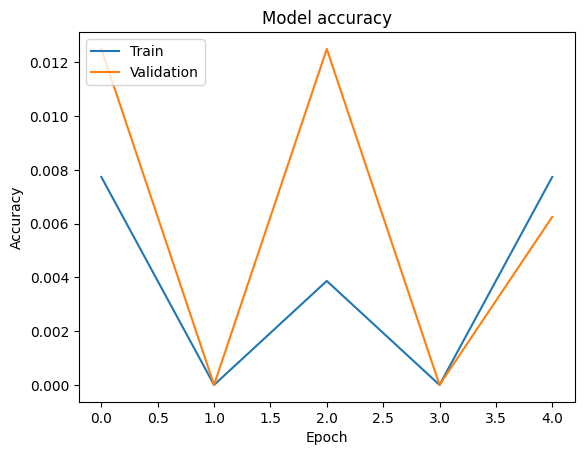

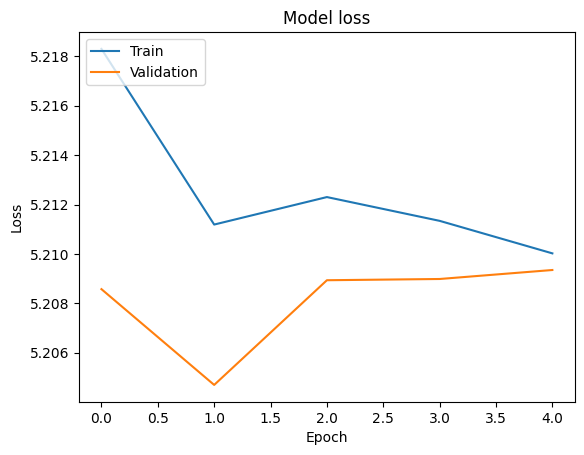

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Configure TensorFlow to limit GPU memory usage to 15 GB
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory usage to 15 GB on the GPU before any other operations
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=15360)]  # Set 15GB limit
        )
        print(f"Using GPU with 15GB memory limit")
    except RuntimeError as e:
        print(e)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Dataset directory: Update the path according to your folder structure
train_dir = '/content/drive/My Drive/segmentedsignatures/train'
test_dir = '/content/drive/My Drive/segmentedsignatures/test'

# Image parameters
img_width, img_height = 128, 128  # Resize to this size
batch_size = 32  # Adjust batch size to optimize memory usage
epochs = 10  # Max epochs for training

# Data Augmentation and Preprocessing for Training Data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data Preprocessing for Test Data (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load Training Data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Load Testing Data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Output the number of classes in train and test sets
print(f"Number of classes in training set: {train_generator.num_classes}")
print(f"Number of classes in testing set: {test_generator.num_classes}")

# Define CNN Model
model = Sequential()

# Input Layer to fix the warning
model.add(Input(shape=(img_width, img_height, 3)))

# First Conv Layer
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Conv Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Conv Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output
model.add(Flatten())

# Fully connected layer with dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Prevent overfitting

# Output Layer: Adjust to match the number of subfolders (classes)
model.add(Dense(train_generator.num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping Criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Save the best model during training
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stopping, model_checkpoint]
)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step
Classification Report:
              precision    recall  f1-score   support

        ID_1       0.00      0.00      0.00         1
       ID_10       0.00      0.00      0.00         1
      ID_100       0.00      0.00      0.00         1
      ID_101       0.00      0.00      0.00         1
      ID_102       0.00      0.00      0.00         1
      ID_103       0.00      0.00      0.00         1
      ID_104       0.00      0.00      0.00         1
      ID_105       0.00      0.00      0.00         1
      ID_106       0.00      0.00      0.00         1
      ID_107       0.00      0.00      0.00         1
      ID_108       0.00      0.00      0.00         1
      ID_109       0.00      0.00      0.00         1
       ID_11       0.00      0.00      0.00         1
      ID_110       0.00      0.00      0.00         1
      ID_111       0.00      0.00      0.00         1
      ID_112       0.00      0.00      0.00         1
      ID_113       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


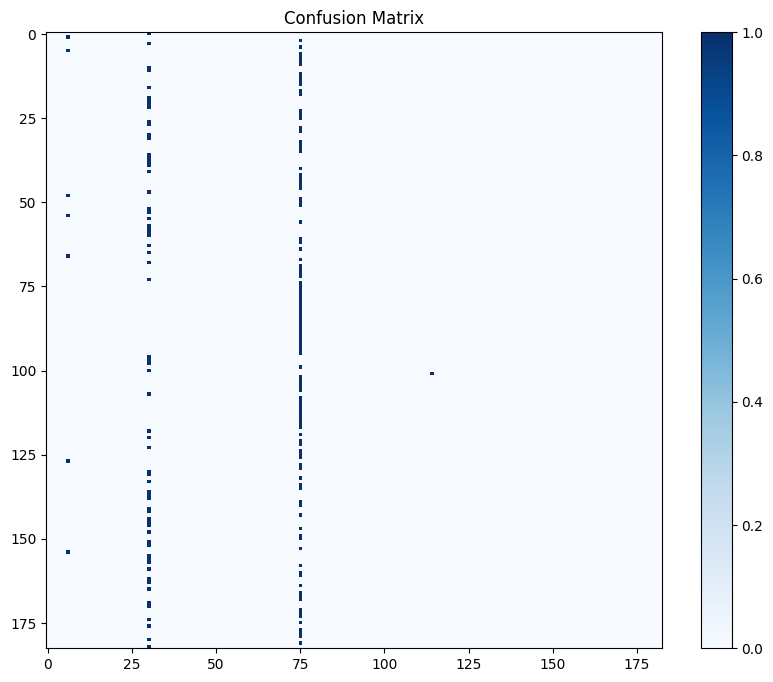

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


# Evaluate the model on the test data
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Generate a classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

# ANN Model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 411ms/step - accuracy: 0.0033 - loss: 5.4560 - val_accuracy: 0.0000e+00 - val_loss: 5.2412
Epoch 2/10
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 5.4151

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.0000e+00 - loss: 5.4151 - val_accuracy: 0.0435 - val_loss: 5.2243
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - accuracy: 0.0084 - loss: 5.3479 - val_accuracy: 0.0000e+00 - val_loss: 5.2135
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0000e+00 - loss: 5.3152 - val_accuracy: 0.0000e+00 - val_loss: 5.1965
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step - accuracy: 0.0021 - loss: 5.2742 - val_accuracy: 0.0063 - val_loss: 5.2072
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 5.2992 - val_accuracy: 0.0000e+00 - val_loss: 5.1968
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step - accuracy: 0.0132 - loss: 5.2641 - val_accuracy: 0.0063 - val_loss: 5.1921
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 0.0000e+00 - loss: 5.1878 - val_accuracy: 0.0000e+00 - val_loss: 5.2000
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - accuracy: 6.9672e-04 - loss: 5.23

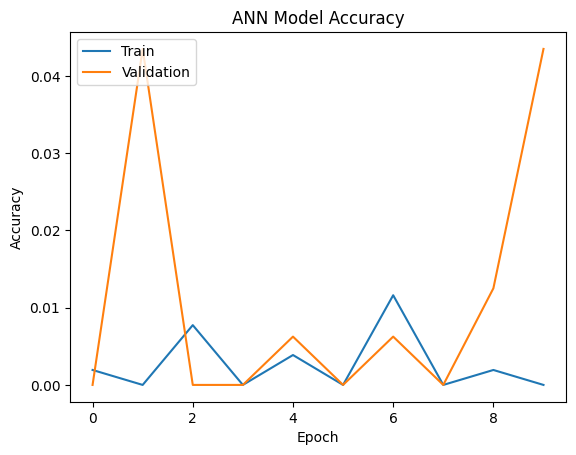

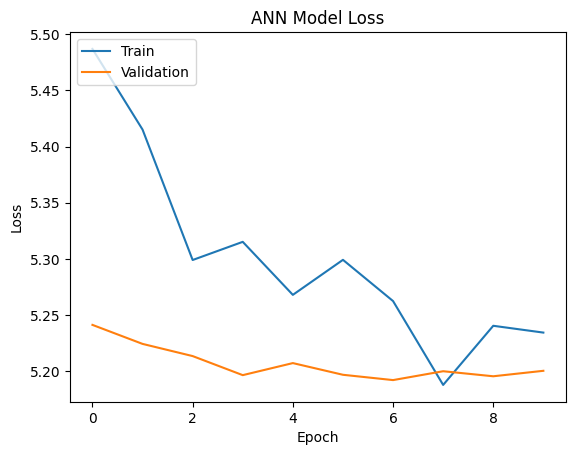

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step
Classification Report (ANN):
              precision    recall  f1-score   support

        ID_1       0.00      0.00      0.00         1
       ID_10       0.00      0.00      0.00         1
      ID_100       0.00      0.00      0.00         1
      ID_101       0.00      0.00      0.00         1
      ID_102       0.00      0.00      0.00         1
      ID_103       0.00      0.00      0.00         1
      ID_104       0.00      0.00      0.00         1
      ID_105       0.00      0.00      0.00         1
      ID_106       0.00      0.00      0.00         1
      ID_107       0.00      0.00      0.00         1
      ID_108       0.00      0.00      0.00         1
      ID_109       0.00      0.00      0.00         1
       ID_11       0.00      0.00      0.00         1
      ID_110       0.00      0.00      0.00         1
      ID_111       0.00      0.00      0.00         1
      ID_112       0.00      0.00      0.00         1
      ID_113 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


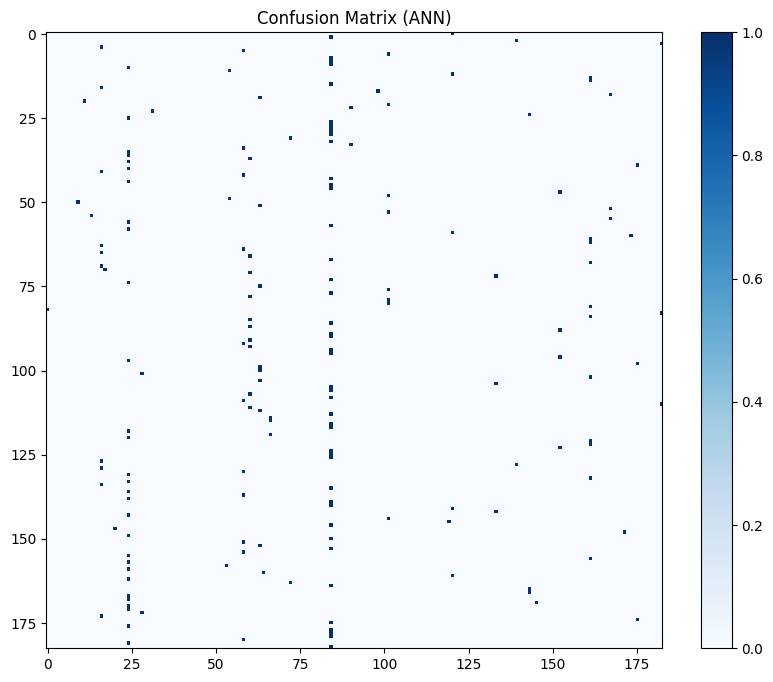

In [ ]:
# ANN Model
from tensorflow.keras.layers import Dense, Dropout, Flatten

# Define ANN Model
ann_model = Sequential()

# Input Layer
ann_model.add(Flatten(input_shape=(img_width, img_height, 3)))  # Flatten input into 1D vector

# First Dense Layer
ann_model.add(Dense(128, activation='relu'))
ann_model.add(Dropout(0.5))  # Dropout for regularization

# Second Dense Layer
ann_model.add(Dense(64, activation='relu'))
ann_model.add(Dropout(0.5))

# Output Layer: Adjust to match the number of subfolders (classes)
ann_model.add(Dense(train_generator.num_classes, activation='softmax'))

# Compile the ANN model
ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping Criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Save the best model during training
model_checkpoint = ModelCheckpoint('best_model_ann.keras', monitor='val_loss', save_best_only=True)

# Train the ANN model
history = ann_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stopping, model_checkpoint]
)

# Plot training & validation accuracy values for ANN
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ANN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values for ANN
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ANN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the ANN model on the test data
y_pred_ann = ann_model.predict(test_generator)
y_pred_classes_ann = np.argmax(y_pred_ann, axis=1)
y_true_ann = test_generator.classes

# Generate a classification report for ANN
print("Classification Report (ANN):")
print(classification_report(y_true_ann, y_pred_classes_ann, target_names=test_generator.class_indices.keys()))

# Confusion Matrix for ANN
conf_matrix_ann = confusion_matrix(y_true_ann, y_pred_classes_ann)

# Visualize the Confusion Matrix for ANN
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix_ann, cmap='Blues')
plt.title('Confusion Matrix (ANN)')
plt.colorbar()
plt.show()


# Histogram of Oriented Gradients (HOG) with SVM

Extracting HOG features for train dataset...
Extracting HOG features for test dataset...
Training the SVM classifier...
Evaluating the classifier...
Classification Report:
              precision    recall  f1-score   support

        ID_1       1.00      1.00      1.00         1
       ID_10       0.33      1.00      0.50         1
      ID_100       0.00      0.00      0.00         1
      ID_101       0.00      0.00      0.00         1
      ID_102       0.00      0.00      0.00         1
      ID_103       0.00      0.00      0.00         1
      ID_104       0.00      0.00      0.00         1
      ID_105       0.00      0.00      0.00         1
      ID_106       0.00      0.00      0.00         1
      ID_107       1.00      1.00      1.00         1
      ID_108       1.00      1.00      1.00         1
      ID_109       0.00      0.00      0.00         1
       ID_11       0.50      1.00      0.67         1
      ID_110       1.00      1.00      1.00         1
      ID_111     

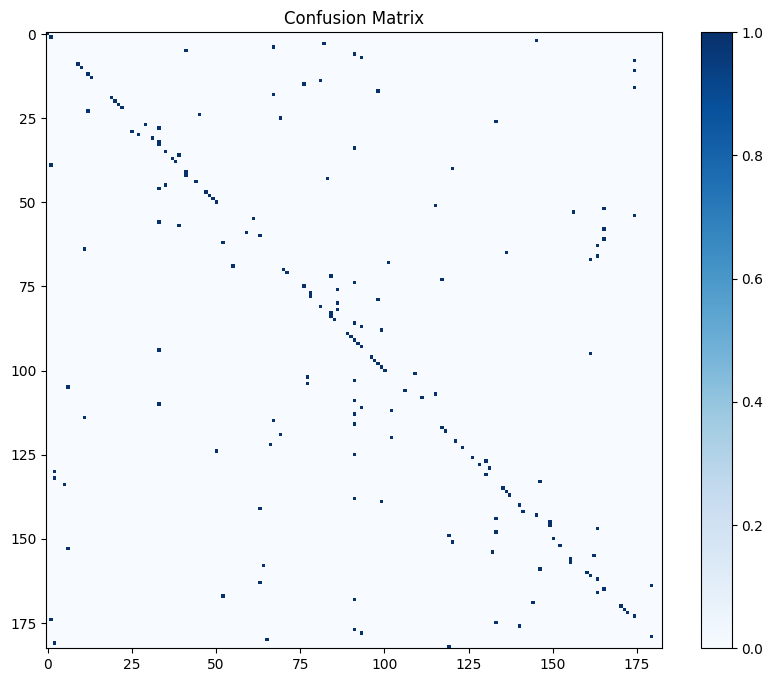

Accuracy: 0.3169


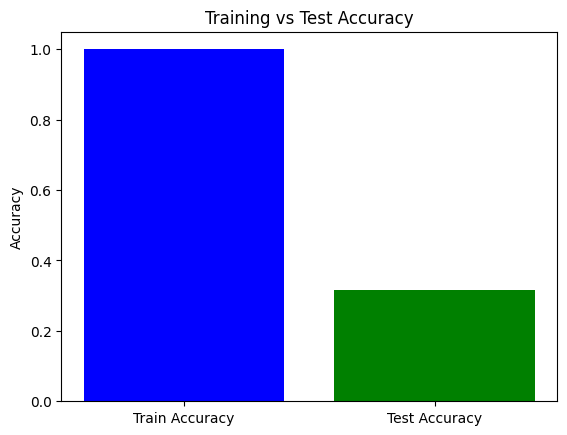

In [ ]:
from skimage.feature import hog
import cv2
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Dataset directory: Update the path according to your folder structure
dataset_dir = '/content/drive/My Drive/segmentedsignatures'
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

# Image parameters
img_width, img_height = 128, 128  # Resize images

# HOG parameters
hog_params = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys',
    'transform_sqrt': True
}

# Function to extract HOG features from an image
def extract_hog_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read the image as grayscale
    img_resized = cv2.resize(img, (img_width, img_height))  # Resize to 128x128
    hog_features, hog_image = hog(img_resized, **hog_params, visualize=True, feature_vector=True)
    return hog_features

# Load dataset and extract HOG features
def load_dataset(directory):
    X, y = [], []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                hog_features = extract_hog_features(img_path)
                X.append(hog_features)
                y.append(label)  # Class label is the folder name
    return np.array(X), np.array(y)

# Load train and test datasets
print("Extracting HOG features for train dataset...")
X_train, y_train = load_dataset(train_dir)
print("Extracting HOG features for test dataset...")
X_test, y_test = load_dataset(test_dir)

# Encode class labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Define SVM Classifier
svm_classifier = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))

# Train the SVM classifier
print("Training the SVM classifier...")
svm_classifier.fit(X_train, y_train_enc)

# Predict on test data
print("Evaluating the classifier...")
y_pred = svm_classifier.predict(X_test)

# Calculate precision, recall, f1-score, and accuracy
print("Classification Report:")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_, zero_division=0))  # Adjusted

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_enc, y_pred)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test_enc, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Plot training/test accuracy and loss (simulated for manual extraction since we're using a direct classifier)
# Note: No direct loss and training curves like deep learning, so we simulate basic output.

train_acc = svm_classifier.score(X_train, y_train_enc)
test_acc = accuracy

# Visualize accuracy
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc, test_acc], color=['blue', 'green'])
plt.title('Training vs Test Accuracy')
plt.ylabel('Accuracy')
plt.show()



## SIFT (Scale-Invariant Feature Transform) with SVM classifier.

In [ ]:
!pip install opencv-contrib-python


Epoch 1/30 complete
Epoch 2/30 complete
Epoch 3/30 complete
Epoch 4/30 complete
Epoch 5/30 complete
Epoch 6/30 complete
Epoch 7/30 complete
Epoch 8/30 complete
Epoch 9/30 complete
Epoch 10/30 complete
Epoch 11/30 complete
Epoch 12/30 complete
Epoch 13/30 complete
Epoch 14/30 complete
Epoch 15/30 complete
Epoch 16/30 complete
Epoch 17/30 complete
Epoch 18/30 complete
Epoch 19/30 complete
Epoch 20/30 complete
Epoch 21/30 complete
Epoch 22/30 complete
Epoch 23/30 complete
Epoch 24/30 complete
Epoch 25/30 complete
Epoch 26/30 complete
Epoch 27/30 complete
Epoch 28/30 complete
Epoch 29/30 complete
Epoch 30/30 complete
              precision    recall  f1-score   support

        ID_1       1.00      1.00      1.00         1
       ID_10       0.00      0.00      0.00         1
      ID_100       0.00      0.00      0.00         1
      ID_101       0.00      0.00      0.00         1
      ID_102       0.00      0.00      0.00         1
      ID_103       0.00      0.00      0.00         1


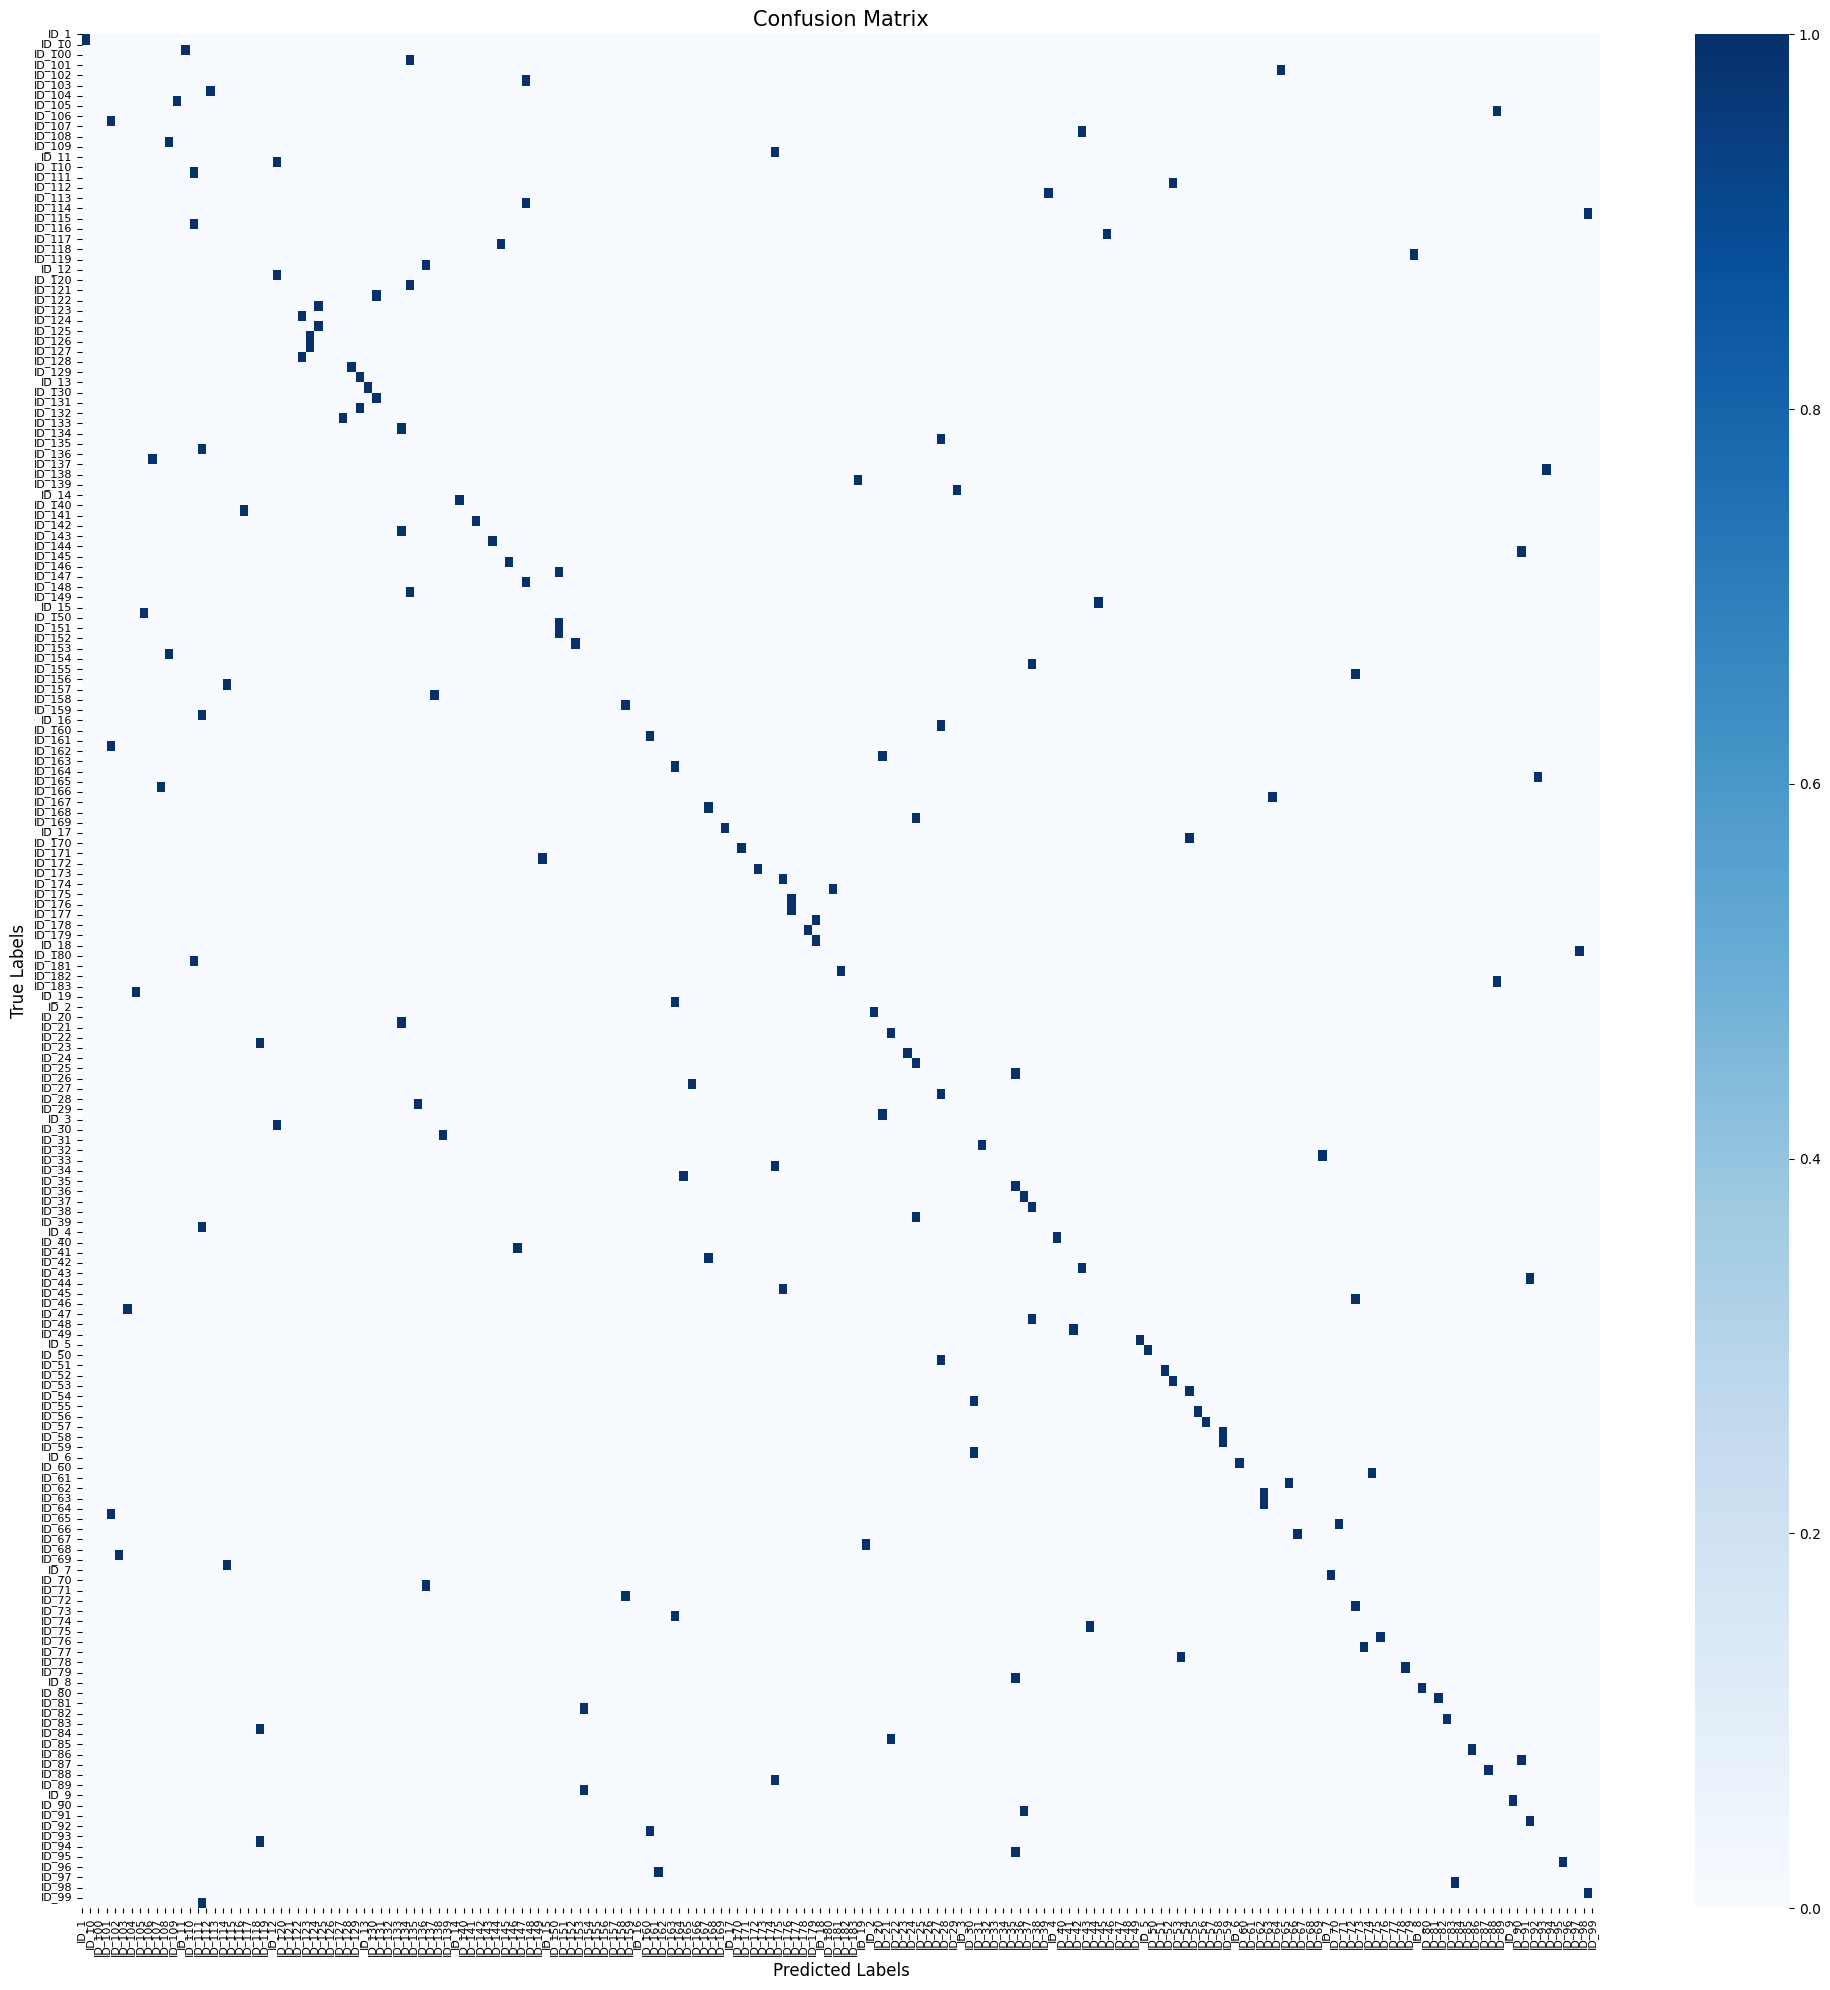

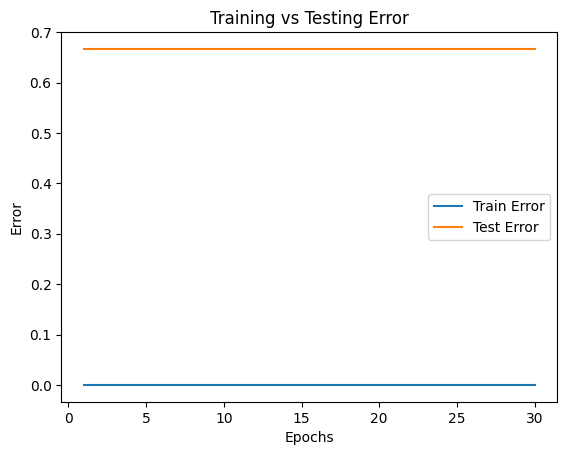

In [ ]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Function to extract SIFT features
def extract_sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return descriptors

# Function to prepare dataset by extracting SIFT features
def prepare_sift_dataset(data_dir):
    labels = []
    feature_list = []

    for label_dir in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label_dir)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if image is not None:
                    descriptors = extract_sift_features(image)
                    if descriptors is not None:
                        feature_list.append(descriptors.mean(axis=0))  # Use the mean of the descriptors
                        labels.append(label_dir)

    return np.array(feature_list), np.array(labels)

# Paths to train and test data
train_dir = '/content/drive/My Drive/segmentedsignatures/train'
test_dir = '/content/drive/My Drive/segmentedsignatures/test'

# Prepare the dataset using SIFT features
X_train, y_train = prepare_sift_dataset(train_dir)
X_test, y_test = prepare_sift_dataset(test_dir)

# Encode the labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Define and train the SVM classifier
svm_classifier = SVC(kernel='linear', probability=True)

# Train the classifier for 30 epochs (train/test loop)
epochs = 30
for epoch in range(epochs):
    svm_classifier.fit(X_train, y_train_enc)
    print(f'Epoch {epoch + 1}/{epochs} complete')

# Make predictions
y_pred = svm_classifier.predict(X_test)

# Using zero_division to handle undefined precision
print(classification_report(y_test_enc, y_pred, target_names=le.classes_, zero_division=0))

# Calculate accuracy
accuracy = accuracy_score(y_test_enc, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_enc, y_pred)

# Visualize Confusion Matrix with better visibility
plt.figure(figsize=(20, 20))  # Adjust figure size as needed
sns.heatmap(conf_matrix, annot=False, fmt="d", cmap="Blues", cbar=True)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

# Add x and y ticks for each class (rotate them to avoid overlap)
plt.xticks(np.arange(len(le.classes_)), le.classes_, rotation=90, fontsize=8)
plt.yticks(np.arange(len(le.classes_)), le.classes_, rotation=0, fontsize=8)

plt.title('Confusion Matrix', fontsize=15)
plt.tight_layout()  # Ensure everything fits without overlap
plt.show()

# Plot training & testing error values (for epochs)
train_errors = []
test_errors = []

for epoch in range(epochs):
    y_train_pred = svm_classifier.predict(X_train)
    train_error = 1 - accuracy_score(y_train_enc, y_train_pred)
    test_error = 1 - accuracy_score(y_test_enc, y_pred)
    train_errors.append(train_error)
    test_errors.append(test_error)

# Visualize training and testing errors
plt.plot(range(1, epochs+1), train_errors, label='Train Error')
plt.plot(range(1, epochs+1), test_errors, label='Test Error')
plt.title('Training vs Testing Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()
